In [1]:
# importing all the necessary libraries!

import os
import warnings
import json
from datetime import datetime 
import pandas as pd
import numpy as np
from math import sqrt
from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from keras.regularizers import L1L2
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor

import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
plt.rcParams['figure.facecolor'] = 'white'
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2022-11-01 20:53:15.283102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 20:53:15.382069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 20:53:15.382087: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-01 20:53:15.401068: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-01 20:53:15.845669: W tensorflow/stream_executor/platform/de

In [2]:
# function to create all the necessary directory!

def create_dir(path):
        isExist = os.path.exists(path)
        if not isExist:
            os.makedirs(path, exist_ok = False)
            print("New directory is created")


# dumping all the hyperparameters to json file!
def hyperparms(dictionary):
    # Serializing json
    json_object = json.dumps(dictionary, indent=4)
    
    # Writing to sample.json
    with open(path_metrics +'/'+ 'hyperparm.json', "w") as outfile:
        outfile.write(json_object)

#load and format data

class DataFormatting():
      
    def __init__(self):
       
        self.df_data = None
        self.df_datetime = None

    def dataset(df):

        # converting time colum from object type to datetime format
        df['date'] = pd.to_datetime(df['date'],dayfirst = True, format = '%Y-%m-%d')
        # creating a ema feature
        #df['SMA_10'] = df[['close']].rolling(10).mean().shift(1)
        #df['SMA_50'] = df[['close']].rolling(50).mean().shift(1)
        #df['SMA_200'] = df[['close']].rolling(200).mean().shift(1)
        df = df.dropna()
        # splitting the dataframe in to X and y 
        df_data = df[['open','high','low','close','CPI','EXCHANGE_RATE','INTEREST_RATE','CRUDE_OIL_CLOSE','US500_CLOSE']] #,open,low,close
        df_datetime =df[['date']]

        return df_data, df_datetime


# Data transformation (changing data shape to model requirement)

def data_transformation(data, lags = 5, n_fut = 1):
    
    """ this function transforms dataframe to required input shape for the model.
    It required 2 input arguments:
    1. data: this will be the pandas dataframe
    2. lags: how many previous price points to be used to predict the next future value, in
    this case the default is set to 5 for 'XAUUSD' commodity"""

    # initialize lists to store the dataset
    X_data = []
    y_data = []
    
    for i in range(lags, len(data)- n_fut +1):
        X_data.append(data[i-lags: i, 0: data.shape[1]])
        y_data.append(data[i+ n_fut-1:i+n_fut,3]) # extracts close price with specific lag as price to be predicted.

    # convert the list to numpy array

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

class LSTM_model():
    

    def __init__(self,n_hidden_layers, units, dropout, train_data_X, train_data_y, epochs, reg):

        self.n_hidden_layers = n_hidden_layers
        self.units = units
        self.dropout = dropout
        self.train_data_X = train_data_X
        self.train_data_y = train_data_y
        self.epochs = epochs
        self.reg = reg

    def build_model(self):
        
        model = Sequential()
        # first lstm layer
        model.add(LSTM(self.units, activation='tanh', input_shape=(self.train_data_X.shape[1], self.train_data_X.shape[2]), kernel_regularizer=self.reg, return_sequences=True))

        if self.n_hidden_layers !=1:

            # building hidden layers
            for i in range(1, self.n_hidden_layers):
                # for the last layer as the return sequence is False
                if i == self.n_hidden_layers -1:
                    model.add(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=False))
                else:
                    model.add(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=True))

        else:
            model.add(LSTM(int(self.units/2),  activation='tanh', return_sequences=False))

        # adding dropout layer
        model.add(Dropout(self.dropout))
        # final layer
        model.add(Dense(self.train_data_y.shape[1]))

        return model

# def build_model(space): #train_data_X.shape[1], train_data_X.shape[2]

#     with mlflow.start_run():
#         mlflow.set_tag('model','lstm')
#         mlflow.log_params(space)
        
#         model = Sequential()
#             # first lstm layer
#         model.add(LSTM(units = space['units'], activation='tanh', input_shape=(train_data_X.shape[1],train_data_X.shape[2]), kernel_regularizer=L1L2(l1=space['l1'], l2=space['l2']), return_sequences=True))

#         if space['layers'] !=1:

#             # building hidden layers
#             for i in range(1, space['layers']):
#                 # for the last layer as the return sequence is False
#                 if i == space['layers'] -1:
#                     model.add(LSTM(int(space['units']/(2**i)),  activation='tanh', return_sequences=False))
#                 else:
#                     model.add(LSTM(int(space['units']/(2**i)),  activation='tanh', return_sequences=True))

#         else:
#             model.add(LSTM(int(space['units']/2),  activation='tanh', return_sequences=False))

#         # adding dropout layer
#         model.add(Dropout(space['dropout']))
#         # final layer
#         model.add(Dense(train_data_y.shape[1])) #train_data_y.shape[1]
#         # metrics for evaluating the model
#         metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()]

#         # model compiler
#         model.compile(optimizer=Adam(learning_rate = space['rate']), loss='mse', metrics = metrics)

#         # setting the callback function
#         cb = [
#             tf.keras.callbacks.ModelCheckpoint(path_checkpoint),
#             tf.keras.callbacks.CSVLogger(path_metrics+'/'+'data.csv')]

#         # model fitting protocol
#         history = model.fit(train_data_X,train_data_y, 
#                             epochs = 500, 
#                             batch_size = space['batch_size'],  
#                             validation_split=0.1,
#                             verbose = 1,
#                             callbacks=[cb],
#                             shuffle= False,
#                             workers = 8,
#                             use_multiprocessing = True)
        
#         # training dataset
#         train_loss, RMSE, MAE, MAPE = model.evaluate(train_data_X,train_data_y)
#         print('\n','Evaluation of Training dataset:','\n''\n','train_loss:',round(train_loss,3),'\n','RMSE:',round(RMSE,3),'\n', 'MAE:',round(MAE,3),'\n','MAPE:',round(MAPE,3))
#         mlflow.log_metric('train_loss',train_loss)
#         mlflow.log_metric('RMSE', RMSE)
#         mlflow.log_metric('MAE', MAE)
#         mlflow.log_metric('MAPE',MAPE)

    
#         return {'loss': MAPE, 'status': STATUS_OK, 'model': model, 'space':space}


class Bi_LSTM_model():
    

    def __init__(self,n_hidden_layers, units, dropout, train_data_X, train_data_y, epochs, reg):

        self.n_hidden_layers = n_hidden_layers
        self.units = units
        self.dropout = dropout
        self.train_data_X = train_data_X
        self.train_data_y = train_data_y
        self.epochs = epochs
        self.reg = reg

    def build_model(self):
        
        model = Sequential()
        # first lstm layer
        model.add(Bidirectional(LSTM(self.units, activation='tanh', input_shape=(self.train_data_X.shape[1], self.train_data_X.shape[2]), kernel_regularizer=self.reg, return_sequences=True)))
        # building hidden layers
        
        if self.n_hidden_layers !=1:

            for i in range(1, self.n_hidden_layers):
                # for the last layer as the return sequence is False
                if i == self.n_hidden_layers -1:
                    model.add(Bidirectional(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=False)))
                else:
                    model.add(Bidirectional(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=True)))

        else:
            model.add(Bidirectional(LSTM(int(self.units/2),  activation='tanh', return_sequences=False)))
        
        # adding dropout layer
        model.add(Dropout(self.dropout))
        # final layer
        model.add(Dense(self.train_data_y.shape[1]))
    
        return model

def metricplot(df, xlab, ylab_1,ylab_2, path):
    
    """
    This function plots metric curves and saves it
    to respective folder
    inputs: df : pandas dataframe 
            xlab: x-axis
            ylab_1 : yaxis_1
            ylab_2 : yaxis_2
            path: full path for saving the plot
            """
    plt.figure()
    sns.set_theme(style="darkgrid")
    sns.lineplot(x = df[xlab], y = df[ylab_1])
    sns.lineplot(x = df[xlab], y = df[ylab_2])
    plt.xlabel('Epochs',fontsize = 12)
    plt.ylabel(ylab_1,fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend([ylab_1,ylab_2], prop={"size":12})
    plt.savefig(path+'/'+ ylab_1)

In [3]:
#DATEBASE_NAME = input('Enter new database name:')
mlflow.set_tracking_uri("sqlite:///lstm.db")
mlflow.set_experiment("Gold_Price_Forecasting")
mlflow.keras.autolog()
with mlflow.start_run():
    mlflow.set_tag('mleng','Jayesh')
    # loading the dataset!
    data = pd.read_csv('../data/macro_data/Gold_Macor_Data.csv',index_col=[0]) 

    #mlflow.log_param('train_data','../data/macro_data/Gold_Macor_Data.csv')
    # dropping rows iteratively from bottom for forecasting
    #data.drop(index=data.index[-j:],axis=0, inplace=True) 

    seed(42)
    tf.random.set_seed(42) 
    keras.backend.clear_session()

    # hyperparameters
    lag = 1
    n_fut = 1
    n_hidden_layers = 3
    batch_size = 56 #256
    units = 128 
    dropout = 0.5
    epochs = 500
    learning_rate = 1.4810983e-05
    l1 = 0.0747964436481689
    l2 = 0.05859337664551668
    reg = L1L2(l1=l1, l2=l2)

    # creating main folder
    today = datetime.now()
    today  = today.strftime('%Y_%m_%d')
    path = '../Model_Outputs/'+ today
    create_dir(path)

    # Which model to run: 
# MODEL_NAME = input('Enter the name LSTM or BILSTM:')
    # creating directory to save model and its output
    EXPERIMENT_NAME = input('Enter new Experiment name:')
    print('\n')
    print('A folder with',EXPERIMENT_NAME,'name has be created to store all the model details!')
    print('\n')
    folder = EXPERIMENT_NAME
    path_main = path + '/'+ folder
    create_dir(path_main)

    # creating directory to save model and its output
    folder = 'model_Bilstm'#+ str(units) + '_' + str(n_hidden_layers)
    path_dir = path_main + '/'+ folder
    create_dir(path_dir)

    # creating directory to save all the metric data
    folder = 'metrics'
    path_metrics = path_dir +'/'+ folder
    create_dir(path_metrics)

    # creating folder to save model.h5 file
    folder = 'model'
    path_model = path_dir +'/'+ folder
    create_dir(path_model)

    # creating folder to save model.h5 file
    folder = 'model_checkpoint'
    path_checkpoint = path_dir +'/'+ folder
    create_dir(path_checkpoint)

    # creating folder to save model.h5 file
    folder = 'forecasting_resutls'
    path_forecast = path_dir +'/'+ folder
    create_dir(path_forecast)




A folder with best_fit5 name has be created to store all the model details!


New directory is created
New directory is created
New directory is created
New directory is created
New directory is created
New directory is created


In [4]:
# hyperparameters to dictionary
dictionary = {
"lags": lag,
"n_fut": n_fut,
"n_hidden_layers": n_hidden_layers,
"batch_size": batch_size,
"units": units,
"dropout": dropout,
"epochs": epochs,
"learning_rate": learning_rate,
"reg_l1": l1,
"reg_l2": l2  
}

mlflow.log_param('dict',dictionary)

print('The hyperparameters for the current experiments:')
print(dictionary)
# dump all the hyperparameters in to a dictionary and save to .json file
hyperparms(dictionary)

# initializing DataFormatting class
data_init = DataFormatting()
df_data, df_datetime = DataFormatting.dataset(data)
print('\n')
print('Displaying top 5 rows of the dataset:')
print('\n')
print(df_data.head())
print(df_data.shape)

# normalize train, val and test dataset

# initialize StandartScaler()
scaler = StandardScaler()
scaler = scaler.fit(df_data)
data_fit_transformed = scaler.transform(df_data)


print('\n')
print('Displaying top 5 rows of all the scaled dataset:')
print('\n')
#print('The train dateset:','\n''\n',data_fit_transformed[0:5],'\n''\n', 'The validation dataset:','\n''\n',val_transformed[0:5],'\n''\n','The test dataset:','\n''\n',test_transformed[0:5])
print('The train dateset:','\n''\n',data_fit_transformed[0:10])

# changing shape of the data to match the model requirement!

X_data, y_data = data_transformation(data_fit_transformed, lags = lag, n_fut = n_fut)
print('\n')
print('Displaying the shape of the dataset required by the model:')
print('\n')
print(f' Input shape X:',X_data.shape, f'Input shape y:',y_data.shape)
print('\n')
#print(X_data)
print(y_data[0:10])
#setting the model file name
model_name = 'lstm_'+ str(units)+'.h5'


train_data_X = X_data
train_data_y = y_data

# split train and test

# traininig 
x_train = X_data[:5000,:]
y_train = y_data[:5000,:]

# testing

x_test = X_data[5000:,:]
y_test = y_data[5000:,:]

# print(x_test.shape)
# print(y_test.shape)

The hyperparameters for the current experiments:
{'lags': 1, 'n_fut': 1, 'n_hidden_layers': 3, 'batch_size': 56, 'units': 128, 'dropout': 0.5, 'epochs': 500, 'learning_rate': 1.4810983e-05, 'reg_l1': 0.0747964436481689, 'reg_l2': 0.05859337664551668}


Displaying top 5 rows of the dataset:


      open    high     low  close       CPI  EXCHANGE_RATE  INTEREST_RATE  \
612  272.5  274.00  272.10  274.0  0.000000         120.18           6.51   
613  273.8  279.10  272.70  278.2  0.000000         120.18           6.65   
614  277.5  278.50  275.00  277.0  0.520833         121.41           6.52   
616  276.8  278.00  274.40  276.1  0.520833         121.41           6.61   
617  275.4  277.15  273.05  275.0  0.520833         121.41           6.56   

     CRUDE_OIL_CLOSE  US500_CLOSE  
612        33.400002  1502.589966  
613        33.099998  1517.680054  
614        33.380001  1520.770020  
616        33.799999  1507.079956  
617        34.950001  1492.250000  
(5498, 9)


Displaying top 5

In [5]:
#if MODEL_NAME == 'LSTM':

# initializing model
model_init = LSTM_model(n_hidden_layers, units, dropout, x_train, x_train, epochs, reg)

# calling the model
model = model_init.build_model()
model.build((x_train.shape[0],x_train.shape[1], x_train.shape[2]))
print(model.summary())

2022-11-01 20:53:24.483495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-01 20:53:24.483534: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-01 20:53:24.483556: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning): /proc/driver/nvidia/version does not exist
2022-11-01 20:53:24.483781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            70656     
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 132,513
Trainable params: 132,513
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
#metrics for evaluating the model
metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()]

# model compiler
model.compile(optimizer=Adam(learning_rate = learning_rate), loss='mse', metrics = metrics)
print(model.summary())


#setting the callback function
cb = [
    tf.keras.callbacks.ModelCheckpoint(path_checkpoint),
    tf.keras.callbacks.CSVLogger(path_metrics+'/'+'data.csv')]
    #tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=, restore_best_weights=False)]






# model fitting protocol
history = model.fit(x_train, y_train,
                    epochs = epochs, 
                    batch_size = batch_size,  
                    validation_data=(x_test, y_test),
                    verbose = 1,
                    callbacks=[cb],
                    shuffle= False)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            70656     
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 132,513
Trainable params: 132,513
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
89/90 [==========================

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 11s 87ms/step - loss: 20.1593 - root_mean_squared_error: 0.9290 - mean_absolute_error: 0.8004 - mean_absolute_percentage_error: 99.9786 - val_loss: 21.3878 - val_root_mean_squared_error: 1.5306 - val_mean_absolute_error: 1.5245 - val_mean_absolute_percentage_error: 99.7050
Epoch 2/500
79/90 [=========================>....] - ETA: 0s - loss: 19.7195 - root_mean_squared_error: 0.9413 - mean_absolute_error: 0.8093 - mean_absolute_percentage_error: 99.8456

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 19.6661 - root_mean_squared_error: 0.9276 - mean_absolute_error: 0.7992 - mean_absolute_percentage_error: 99.8460 - val_loss: 20.8936 - val_root_mean_squared_error: 1.5283 - val_mean_absolute_error: 1.5222 - val_mean_absolute_percentage_error: 99.5540
Epoch 3/500
81/90 [==========================>...] - ETA: 0s - loss: 19.2083 - root_mean_squared_error: 0.9297 - mean_absolute_error: 0.7969 - mean_absolute_percentage_error: 99.8640

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 79ms/step - loss: 19.1791 - root_mean_squared_error: 0.9259 - mean_absolute_error: 0.7978 - mean_absolute_percentage_error: 99.8558 - val_loss: 20.4064 - val_root_mean_squared_error: 1.5260 - val_mean_absolute_error: 1.5199 - val_mean_absolute_percentage_error: 99.4024
Epoch 4/500
84/90 [===========================>..] - ETA: 0s - loss: 18.6958 - root_mean_squared_error: 0.9147 - mean_absolute_error: 0.7821 - mean_absolute_percentage_error: 99.7466

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 18.6992 - root_mean_squared_error: 0.9241 - mean_absolute_error: 0.7965 - mean_absolute_percentage_error: 99.7343 - val_loss: 19.9260 - val_root_mean_squared_error: 1.5236 - val_mean_absolute_error: 1.5176 - val_mean_absolute_percentage_error: 99.2500
Epoch 5/500
81/90 [==========================>...] - ETA: 0s - loss: 18.2542 - root_mean_squared_error: 0.9260 - mean_absolute_error: 0.7939 - mean_absolute_percentage_error: 99.6015

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 108ms/step - loss: 18.2261 - root_mean_squared_error: 0.9223 - mean_absolute_error: 0.7950 - mean_absolute_percentage_error: 99.6042 - val_loss: 19.4526 - val_root_mean_squared_error: 1.5212 - val_mean_absolute_error: 1.5152 - val_mean_absolute_percentage_error: 99.0913
Epoch 6/500
79/90 [=========================>....] - ETA: 0s - loss: 17.8115 - root_mean_squared_error: 0.9338 - mean_absolute_error: 0.8032 - mean_absolute_percentage_error: 99.5376

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 103ms/step - loss: 17.7607 - root_mean_squared_error: 0.9206 - mean_absolute_error: 0.7936 - mean_absolute_percentage_error: 99.5461 - val_loss: 18.9868 - val_root_mean_squared_error: 1.5187 - val_mean_absolute_error: 1.5127 - val_mean_absolute_percentage_error: 98.9302
Epoch 7/500
90/90 [==============================] - ETA: 0s - loss: 17.3022 - root_mean_squared_error: 0.9187 - mean_absolute_error: 0.7920 - mean_absolute_percentage_error: 99.4460

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 109ms/step - loss: 17.3022 - root_mean_squared_error: 0.9187 - mean_absolute_error: 0.7920 - mean_absolute_percentage_error: 99.4460 - val_loss: 18.5277 - val_root_mean_squared_error: 1.5162 - val_mean_absolute_error: 1.5102 - val_mean_absolute_percentage_error: 98.7651
Epoch 8/500
78/90 [=========================>....] - ETA: 0s - loss: 16.9099 - root_mean_squared_error: 0.9336 - mean_absolute_error: 0.8032 - mean_absolute_percentage_error: 99.1968

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 16.8506 - root_mean_squared_error: 0.9167 - mean_absolute_error: 0.7904 - mean_absolute_percentage_error: 99.2301 - val_loss: 18.0753 - val_root_mean_squared_error: 1.5136 - val_mean_absolute_error: 1.5075 - val_mean_absolute_percentage_error: 98.5929
Epoch 9/500
90/90 [==============================] - ETA: 0s - loss: 16.4057 - root_mean_squared_error: 0.9146 - mean_absolute_error: 0.7887 - mean_absolute_percentage_error: 99.2093

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 111ms/step - loss: 16.4057 - root_mean_squared_error: 0.9146 - mean_absolute_error: 0.7887 - mean_absolute_percentage_error: 99.2093 - val_loss: 17.6295 - val_root_mean_squared_error: 1.5108 - val_mean_absolute_error: 1.5048 - val_mean_absolute_percentage_error: 98.4143
Epoch 10/500
88/90 [============================>.] - ETA: 0s - loss: 15.9538 - root_mean_squared_error: 0.9031 - mean_absolute_error: 0.7781 - mean_absolute_percentage_error: 99.2269

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 15.9680 - root_mean_squared_error: 0.9126 - mean_absolute_error: 0.7871 - mean_absolute_percentage_error: 99.2162 - val_loss: 17.1906 - val_root_mean_squared_error: 1.5080 - val_mean_absolute_error: 1.5020 - val_mean_absolute_percentage_error: 98.2298
Epoch 11/500
78/90 [=========================>....] - ETA: 0s - loss: 15.5937 - root_mean_squared_error: 0.9267 - mean_absolute_error: 0.7976 - mean_absolute_percentage_error: 98.9186

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 15.5368 - root_mean_squared_error: 0.9102 - mean_absolute_error: 0.7852 - mean_absolute_percentage_error: 98.9599 - val_loss: 16.7584 - val_root_mean_squared_error: 1.5051 - val_mean_absolute_error: 1.4991 - val_mean_absolute_percentage_error: 98.0377
Epoch 12/500
80/90 [=========================>....] - ETA: 0s - loss: 15.1487 - root_mean_squared_error: 0.9160 - mean_absolute_error: 0.7879 - mean_absolute_percentage_error: 98.8060

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 78ms/step - loss: 15.1125 - root_mean_squared_error: 0.9079 - mean_absolute_error: 0.7833 - mean_absolute_percentage_error: 98.8397 - val_loss: 16.3326 - val_root_mean_squared_error: 1.5021 - val_mean_absolute_error: 1.4961 - val_mean_absolute_percentage_error: 97.8404
Epoch 13/500
85/90 [===========================>..] - ETA: 0s - loss: 14.6836 - root_mean_squared_error: 0.8940 - mean_absolute_error: 0.7665 - mean_absolute_percentage_error: 98.7686

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 14.6948 - root_mean_squared_error: 0.9057 - mean_absolute_error: 0.7815 - mean_absolute_percentage_error: 98.7491 - val_loss: 15.9126 - val_root_mean_squared_error: 1.4990 - val_mean_absolute_error: 1.4930 - val_mean_absolute_percentage_error: 97.6388
Epoch 14/500
89/90 [============================>.] - ETA: 0s - loss: 14.2756 - root_mean_squared_error: 0.8990 - mean_absolute_error: 0.7763 - mean_absolute_percentage_error: 98.6816

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 14.2817 - root_mean_squared_error: 0.9028 - mean_absolute_error: 0.7792 - mean_absolute_percentage_error: 98.6790 - val_loss: 15.4980 - val_root_mean_squared_error: 1.4958 - val_mean_absolute_error: 1.4898 - val_mean_absolute_percentage_error: 97.4286
Epoch 15/500
79/90 [=========================>....] - ETA: 0s - loss: 13.9192 - root_mean_squared_error: 0.9120 - mean_absolute_error: 0.7855 - mean_absolute_percentage_error: 98.3261

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 13.8747 - root_mean_squared_error: 0.9001 - mean_absolute_error: 0.7771 - mean_absolute_percentage_error: 98.3945 - val_loss: 15.0891 - val_root_mean_squared_error: 1.4925 - val_mean_absolute_error: 1.4865 - val_mean_absolute_percentage_error: 97.2154
Epoch 16/500
80/90 [=========================>....] - ETA: 0s - loss: 13.5077 - root_mean_squared_error: 0.9050 - mean_absolute_error: 0.7790 - mean_absolute_percentage_error: 98.2745

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 13.4739 - root_mean_squared_error: 0.8975 - mean_absolute_error: 0.7750 - mean_absolute_percentage_error: 98.3304 - val_loss: 14.6863 - val_root_mean_squared_error: 1.4892 - val_mean_absolute_error: 1.4832 - val_mean_absolute_percentage_error: 96.9989
Epoch 17/500
79/90 [=========================>....] - ETA: 0s - loss: 13.1222 - root_mean_squared_error: 0.9062 - mean_absolute_error: 0.7807 - mean_absolute_percentage_error: 98.2859

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 13.0793 - root_mean_squared_error: 0.8946 - mean_absolute_error: 0.7727 - mean_absolute_percentage_error: 98.3414 - val_loss: 14.2904 - val_root_mean_squared_error: 1.4859 - val_mean_absolute_error: 1.4799 - val_mean_absolute_percentage_error: 96.7815
Epoch 18/500
86/90 [===========================>..] - ETA: 0s - loss: 12.6769 - root_mean_squared_error: 0.8796 - mean_absolute_error: 0.7564 - mean_absolute_percentage_error: 97.8799

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 12.6917 - root_mean_squared_error: 0.8919 - mean_absolute_error: 0.7704 - mean_absolute_percentage_error: 97.8632 - val_loss: 13.9011 - val_root_mean_squared_error: 1.4825 - val_mean_absolute_error: 1.4766 - val_mean_absolute_percentage_error: 96.5638
Epoch 19/500
78/90 [=========================>....] - ETA: 0s - loss: 12.3602 - root_mean_squared_error: 0.9039 - mean_absolute_error: 0.7789 - mean_absolute_percentage_error: 97.8646

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 12.3099 - root_mean_squared_error: 0.8889 - mean_absolute_error: 0.7681 - mean_absolute_percentage_error: 97.9563 - val_loss: 13.5176 - val_root_mean_squared_error: 1.4792 - val_mean_absolute_error: 1.4732 - val_mean_absolute_percentage_error: 96.3434
Epoch 20/500
79/90 [=========================>....] - ETA: 0s - loss: 11.9742 - root_mean_squared_error: 0.8964 - mean_absolute_error: 0.7728 - mean_absolute_percentage_error: 97.7196

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 11.9338 - root_mean_squared_error: 0.8855 - mean_absolute_error: 0.7654 - mean_absolute_percentage_error: 97.8148 - val_loss: 13.1412 - val_root_mean_squared_error: 1.4757 - val_mean_absolute_error: 1.4698 - val_mean_absolute_percentage_error: 96.1212
Epoch 21/500
88/90 [============================>.] - ETA: 0s - loss: 11.5519 - root_mean_squared_error: 0.8730 - mean_absolute_error: 0.7541 - mean_absolute_percentage_error: 97.7873

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 111ms/step - loss: 11.5662 - root_mean_squared_error: 0.8827 - mean_absolute_error: 0.7631 - mean_absolute_percentage_error: 97.7689 - val_loss: 12.7724 - val_root_mean_squared_error: 1.4724 - val_mean_absolute_error: 1.4665 - val_mean_absolute_percentage_error: 95.9051
Epoch 22/500
87/90 [============================>.] - ETA: 0s - loss: 11.1863 - root_mean_squared_error: 0.8664 - mean_absolute_error: 0.7475 - mean_absolute_percentage_error: 97.6794

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 11.2036 - root_mean_squared_error: 0.8788 - mean_absolute_error: 0.7602 - mean_absolute_percentage_error: 97.6538 - val_loss: 12.4099 - val_root_mean_squared_error: 1.4692 - val_mean_absolute_error: 1.4632 - val_mean_absolute_percentage_error: 95.6911
Epoch 23/500
90/90 [==============================] - ETA: 0s - loss: 10.8486 - root_mean_squared_error: 0.8759 - mean_absolute_error: 0.7579 - mean_absolute_percentage_error: 97.5968

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 10.8486 - root_mean_squared_error: 0.8759 - mean_absolute_error: 0.7579 - mean_absolute_percentage_error: 97.5968 - val_loss: 12.0539 - val_root_mean_squared_error: 1.4659 - val_mean_absolute_error: 1.4600 - val_mean_absolute_percentage_error: 95.4766
Epoch 24/500
86/90 [===========================>..] - ETA: 0s - loss: 10.4839 - root_mean_squared_error: 0.8599 - mean_absolute_error: 0.7410 - mean_absolute_percentage_error: 97.4740

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 10.4997 - root_mean_squared_error: 0.8726 - mean_absolute_error: 0.7553 - mean_absolute_percentage_error: 97.4394 - val_loss: 11.7043 - val_root_mean_squared_error: 1.4626 - val_mean_absolute_error: 1.4567 - val_mean_absolute_percentage_error: 95.2665
Epoch 25/500
79/90 [=========================>....] - ETA: 0s - loss: 10.1924 - root_mean_squared_error: 0.8787 - mean_absolute_error: 0.7586 - mean_absolute_percentage_error: 97.0933

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 10.1566 - root_mean_squared_error: 0.8691 - mean_absolute_error: 0.7525 - mean_absolute_percentage_error: 97.2480 - val_loss: 11.3614 - val_root_mean_squared_error: 1.4595 - val_mean_absolute_error: 1.4536 - val_mean_absolute_percentage_error: 95.0604
Epoch 26/500
78/90 [=========================>....] - ETA: 0s - loss: 9.8642 - root_mean_squared_error: 0.8790 - mean_absolute_error: 0.7590 - mean_absolute_percentage_error: 97.2396 

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 95ms/step - loss: 9.8211 - root_mean_squared_error: 0.8660 - mean_absolute_error: 0.7502 - mean_absolute_percentage_error: 97.3740 - val_loss: 11.0260 - val_root_mean_squared_error: 1.4565 - val_mean_absolute_error: 1.4506 - val_mean_absolute_percentage_error: 94.8655
Epoch 27/500
79/90 [=========================>....] - ETA: 0s - loss: 9.5258 - root_mean_squared_error: 0.8717 - mean_absolute_error: 0.7530 - mean_absolute_percentage_error: 96.8729

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 9.4918 - root_mean_squared_error: 0.8627 - mean_absolute_error: 0.7475 - mean_absolute_percentage_error: 97.0554 - val_loss: 10.6970 - val_root_mean_squared_error: 1.4536 - val_mean_absolute_error: 1.4478 - val_mean_absolute_percentage_error: 94.6803
Epoch 28/500
89/90 [============================>.] - ETA: 0s - loss: 9.1611 - root_mean_squared_error: 0.8548 - mean_absolute_error: 0.7416 - mean_absolute_percentage_error: 97.1105

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 9.1671 - root_mean_squared_error: 0.8586 - mean_absolute_error: 0.7445 - mean_absolute_percentage_error: 97.1042 - val_loss: 10.3745 - val_root_mean_squared_error: 1.4508 - val_mean_absolute_error: 1.4450 - val_mean_absolute_percentage_error: 94.4983
Epoch 29/500
79/90 [=========================>....] - ETA: 0s - loss: 8.8813 - root_mean_squared_error: 0.8630 - mean_absolute_error: 0.7465 - mean_absolute_percentage_error: 97.1963

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 8.8494 - root_mean_squared_error: 0.8547 - mean_absolute_error: 0.7416 - mean_absolute_percentage_error: 97.3438 - val_loss: 10.0590 - val_root_mean_squared_error: 1.4482 - val_mean_absolute_error: 1.4423 - val_mean_absolute_percentage_error: 94.3255
Epoch 30/500
87/90 [============================>.] - ETA: 0s - loss: 8.5208 - root_mean_squared_error: 0.8385 - mean_absolute_error: 0.7262 - mean_absolute_percentage_error: 96.9802

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 114ms/step - loss: 8.5391 - root_mean_squared_error: 0.8515 - mean_absolute_error: 0.7391 - mean_absolute_percentage_error: 96.9436 - val_loss: 9.7500 - val_root_mean_squared_error: 1.4456 - val_mean_absolute_error: 1.4398 - val_mean_absolute_percentage_error: 94.1588
Epoch 31/500
90/90 [==============================] - ETA: 0s - loss: 8.2348 - root_mean_squared_error: 0.8476 - mean_absolute_error: 0.7361 - mean_absolute_percentage_error: 97.2004

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 8.2348 - root_mean_squared_error: 0.8476 - mean_absolute_error: 0.7361 - mean_absolute_percentage_error: 97.2004 - val_loss: 9.4485 - val_root_mean_squared_error: 1.4431 - val_mean_absolute_error: 1.4373 - val_mean_absolute_percentage_error: 93.9942
Epoch 32/500
90/90 [==============================] - ETA: 0s - loss: 7.9378 - root_mean_squared_error: 0.8441 - mean_absolute_error: 0.7336 - mean_absolute_percentage_error: 97.0437

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 7.9378 - root_mean_squared_error: 0.8441 - mean_absolute_error: 0.7336 - mean_absolute_percentage_error: 97.0437 - val_loss: 9.1540 - val_root_mean_squared_error: 1.4407 - val_mean_absolute_error: 1.4349 - val_mean_absolute_percentage_error: 93.8409
Epoch 33/500
90/90 [==============================] - ETA: 0s - loss: 7.6480 - root_mean_squared_error: 0.8411 - mean_absolute_error: 0.7311 - mean_absolute_percentage_error: 97.1988

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 7.6480 - root_mean_squared_error: 0.8411 - mean_absolute_error: 0.7311 - mean_absolute_percentage_error: 97.1988 - val_loss: 8.8656 - val_root_mean_squared_error: 1.4384 - val_mean_absolute_error: 1.4326 - val_mean_absolute_percentage_error: 93.6929
Epoch 34/500
78/90 [=========================>....] - ETA: 0s - loss: 7.3955 - root_mean_squared_error: 0.8462 - mean_absolute_error: 0.7336 - mean_absolute_percentage_error: 96.9777

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 111ms/step - loss: 7.3619 - root_mean_squared_error: 0.8366 - mean_absolute_error: 0.7279 - mean_absolute_percentage_error: 97.2194 - val_loss: 8.5840 - val_root_mean_squared_error: 1.4363 - val_mean_absolute_error: 1.4305 - val_mean_absolute_percentage_error: 93.5523
Epoch 35/500
89/90 [============================>.] - ETA: 0s - loss: 7.0772 - root_mean_squared_error: 0.8289 - mean_absolute_error: 0.7220 - mean_absolute_percentage_error: 97.2853

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 7.0833 - root_mean_squared_error: 0.8328 - mean_absolute_error: 0.7250 - mean_absolute_percentage_error: 97.2772 - val_loss: 8.3088 - val_root_mean_squared_error: 1.4342 - val_mean_absolute_error: 1.4285 - val_mean_absolute_percentage_error: 93.4200
Epoch 36/500
82/90 [==========================>...] - ETA: 0s - loss: 6.8109 - root_mean_squared_error: 0.8227 - mean_absolute_error: 0.7118 - mean_absolute_percentage_error: 97.6586

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 6.8117 - root_mean_squared_error: 0.8296 - mean_absolute_error: 0.7228 - mean_absolute_percentage_error: 97.6533 - val_loss: 8.0404 - val_root_mean_squared_error: 1.4323 - val_mean_absolute_error: 1.4266 - val_mean_absolute_percentage_error: 93.2985
Epoch 37/500
80/90 [=========================>....] - ETA: 0s - loss: 6.5629 - root_mean_squared_error: 0.8280 - mean_absolute_error: 0.7188 - mean_absolute_percentage_error: 97.4061

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 71ms/step - loss: 6.5473 - root_mean_squared_error: 0.8267 - mean_absolute_error: 0.7204 - mean_absolute_percentage_error: 97.6088 - val_loss: 7.7797 - val_root_mean_squared_error: 1.4307 - val_mean_absolute_error: 1.4250 - val_mean_absolute_percentage_error: 93.1935
Epoch 38/500
81/90 [==========================>...] - ETA: 0s - loss: 6.2944 - root_mean_squared_error: 0.8195 - mean_absolute_error: 0.7108 - mean_absolute_percentage_error: 97.7880

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 6.2884 - root_mean_squared_error: 0.8229 - mean_absolute_error: 0.7177 - mean_absolute_percentage_error: 97.8749 - val_loss: 7.5258 - val_root_mean_squared_error: 1.4293 - val_mean_absolute_error: 1.4236 - val_mean_absolute_percentage_error: 93.1021
Epoch 39/500
89/90 [============================>.] - ETA: 0s - loss: 6.0293 - root_mean_squared_error: 0.8152 - mean_absolute_error: 0.7121 - mean_absolute_percentage_error: 97.9667

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 6.0355 - root_mean_squared_error: 0.8192 - mean_absolute_error: 0.7150 - mean_absolute_percentage_error: 97.9548 - val_loss: 7.2779 - val_root_mean_squared_error: 1.4279 - val_mean_absolute_error: 1.4222 - val_mean_absolute_percentage_error: 93.0136
Epoch 40/500
88/90 [============================>.] - ETA: 0s - loss: 5.7732 - root_mean_squared_error: 0.8049 - mean_absolute_error: 0.7029 - mean_absolute_percentage_error: 97.5657

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 5.7886 - root_mean_squared_error: 0.8154 - mean_absolute_error: 0.7121 - mean_absolute_percentage_error: 97.5146 - val_loss: 7.0371 - val_root_mean_squared_error: 1.4267 - val_mean_absolute_error: 1.4210 - val_mean_absolute_percentage_error: 92.9376
Epoch 41/500
84/90 [===========================>..] - ETA: 0s - loss: 5.5316 - root_mean_squared_error: 0.7967 - mean_absolute_error: 0.6919 - mean_absolute_percentage_error: 98.7157

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 5.5487 - root_mean_squared_error: 0.8115 - mean_absolute_error: 0.7093 - mean_absolute_percentage_error: 98.5654 - val_loss: 6.8038 - val_root_mean_squared_error: 1.4255 - val_mean_absolute_error: 1.4199 - val_mean_absolute_percentage_error: 92.8643
Epoch 42/500
89/90 [============================>.] - ETA: 0s - loss: 5.3131 - root_mean_squared_error: 0.8058 - mean_absolute_error: 0.7050 - mean_absolute_percentage_error: 98.2004

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 5.3193 - root_mean_squared_error: 0.8099 - mean_absolute_error: 0.7080 - mean_absolute_percentage_error: 98.1870 - val_loss: 6.5773 - val_root_mean_squared_error: 1.4245 - val_mean_absolute_error: 1.4188 - val_mean_absolute_percentage_error: 92.7960
Epoch 43/500
79/90 [=========================>....] - ETA: 0s - loss: 5.1081 - root_mean_squared_error: 0.8075 - mean_absolute_error: 0.7041 - mean_absolute_percentage_error: 97.8537

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 5.0922 - root_mean_squared_error: 0.8054 - mean_absolute_error: 0.7049 - mean_absolute_percentage_error: 98.2095 - val_loss: 6.3576 - val_root_mean_squared_error: 1.4234 - val_mean_absolute_error: 1.4178 - val_mean_absolute_percentage_error: 92.7297
Epoch 44/500
80/90 [=========================>....] - ETA: 0s - loss: 4.8805 - root_mean_squared_error: 0.7997 - mean_absolute_error: 0.6977 - mean_absolute_percentage_error: 98.1854

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 4.8725 - root_mean_squared_error: 0.8016 - mean_absolute_error: 0.7022 - mean_absolute_percentage_error: 98.4850 - val_loss: 6.1435 - val_root_mean_squared_error: 1.4223 - val_mean_absolute_error: 1.4167 - val_mean_absolute_percentage_error: 92.6562
Epoch 45/500
80/90 [=========================>....] - ETA: 0s - loss: 4.6665 - root_mean_squared_error: 0.7962 - mean_absolute_error: 0.6953 - mean_absolute_percentage_error: 98.0974

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 4.6593 - root_mean_squared_error: 0.7984 - mean_absolute_error: 0.7000 - mean_absolute_percentage_error: 98.4331 - val_loss: 5.9353 - val_root_mean_squared_error: 1.4213 - val_mean_absolute_error: 1.4157 - val_mean_absolute_percentage_error: 92.5947
Epoch 46/500
83/90 [==========================>...] - ETA: 0s - loss: 4.4384 - root_mean_squared_error: 0.7822 - mean_absolute_error: 0.6817 - mean_absolute_percentage_error: 98.7753

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 4.4525 - root_mean_squared_error: 0.7955 - mean_absolute_error: 0.6976 - mean_absolute_percentage_error: 98.7095 - val_loss: 5.7331 - val_root_mean_squared_error: 1.4202 - val_mean_absolute_error: 1.4146 - val_mean_absolute_percentage_error: 92.5221
Epoch 47/500
79/90 [=========================>....] - ETA: 0s - loss: 4.2616 - root_mean_squared_error: 0.7916 - mean_absolute_error: 0.6923 - mean_absolute_percentage_error: 100.3037

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 4.2506 - root_mean_squared_error: 0.7917 - mean_absolute_error: 0.6951 - mean_absolute_percentage_error: 100.5143 - val_loss: 5.5364 - val_root_mean_squared_error: 1.4189 - val_mean_absolute_error: 1.4133 - val_mean_absolute_percentage_error: 92.4390
Epoch 48/500
81/90 [==========================>...] - ETA: 0s - loss: 4.0478 - root_mean_squared_error: 0.7779 - mean_absolute_error: 0.6801 - mean_absolute_percentage_error: 99.5761

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 4.0518 - root_mean_squared_error: 0.7861 - mean_absolute_error: 0.6909 - mean_absolute_percentage_error: 99.7078 - val_loss: 5.3450 - val_root_mean_squared_error: 1.4174 - val_mean_absolute_error: 1.4118 - val_mean_absolute_percentage_error: 92.3439
Epoch 49/500
87/90 [============================>.] - ETA: 0s - loss: 3.8417 - root_mean_squared_error: 0.7681 - mean_absolute_error: 0.6749 - mean_absolute_percentage_error: 99.1667

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 3.8632 - root_mean_squared_error: 0.7835 - mean_absolute_error: 0.6888 - mean_absolute_percentage_error: 99.0495 - val_loss: 5.1588 - val_root_mean_squared_error: 1.4158 - val_mean_absolute_error: 1.4103 - val_mean_absolute_percentage_error: 92.2453
Epoch 50/500
88/90 [============================>.] - ETA: 0s - loss: 3.6603 - root_mean_squared_error: 0.7670 - mean_absolute_error: 0.6754 - mean_absolute_percentage_error: 99.1097

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 3.6767 - root_mean_squared_error: 0.7785 - mean_absolute_error: 0.6849 - mean_absolute_percentage_error: 99.0336 - val_loss: 4.9782 - val_root_mean_squared_error: 1.4142 - val_mean_absolute_error: 1.4087 - val_mean_absolute_percentage_error: 92.1414
Epoch 51/500
78/90 [=========================>....] - ETA: 0s - loss: 3.5092 - root_mean_squared_error: 0.7751 - mean_absolute_error: 0.6790 - mean_absolute_percentage_error: 99.3449

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 3.4981 - root_mean_squared_error: 0.7751 - mean_absolute_error: 0.6823 - mean_absolute_percentage_error: 99.8257 - val_loss: 4.8022 - val_root_mean_squared_error: 1.4123 - val_mean_absolute_error: 1.4068 - val_mean_absolute_percentage_error: 92.0182
Epoch 52/500
84/90 [===========================>..] - ETA: 0s - loss: 3.3018 - root_mean_squared_error: 0.7531 - mean_absolute_error: 0.6600 - mean_absolute_percentage_error: 101.0838

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 3.3249 - root_mean_squared_error: 0.7715 - mean_absolute_error: 0.6795 - mean_absolute_percentage_error: 100.8259 - val_loss: 4.6314 - val_root_mean_squared_error: 1.4103 - val_mean_absolute_error: 1.4048 - val_mean_absolute_percentage_error: 91.8888
Epoch 53/500
79/90 [=========================>....] - ETA: 0s - loss: 3.1576 - root_mean_squared_error: 0.7617 - mean_absolute_error: 0.6689 - mean_absolute_percentage_error: 100.1269

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 3.1541 - root_mean_squared_error: 0.7656 - mean_absolute_error: 0.6750 - mean_absolute_percentage_error: 100.5437 - val_loss: 4.4656 - val_root_mean_squared_error: 1.4079 - val_mean_absolute_error: 1.4024 - val_mean_absolute_percentage_error: 91.7323
Epoch 54/500
79/90 [=========================>....] - ETA: 0s - loss: 2.9972 - root_mean_squared_error: 0.7590 - mean_absolute_error: 0.6667 - mean_absolute_percentage_error: 101.8806

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 2.9946 - root_mean_squared_error: 0.7632 - mean_absolute_error: 0.6732 - mean_absolute_percentage_error: 102.1223 - val_loss: 4.3062 - val_root_mean_squared_error: 1.4055 - val_mean_absolute_error: 1.4001 - val_mean_absolute_percentage_error: 91.5778
Epoch 55/500
79/90 [=========================>....] - ETA: 0s - loss: 2.8382 - root_mean_squared_error: 0.7525 - mean_absolute_error: 0.6614 - mean_absolute_percentage_error: 101.6250

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 2.8369 - root_mean_squared_error: 0.7575 - mean_absolute_error: 0.6686 - mean_absolute_percentage_error: 101.9198 - val_loss: 4.1533 - val_root_mean_squared_error: 1.4030 - val_mean_absolute_error: 1.3976 - val_mean_absolute_percentage_error: 91.4179
Epoch 56/500
84/90 [===========================>..] - ETA: 0s - loss: 2.6618 - root_mean_squared_error: 0.7328 - mean_absolute_error: 0.6444 - mean_absolute_percentage_error: 101.3737

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 2.6871 - root_mean_squared_error: 0.7527 - mean_absolute_error: 0.6648 - mean_absolute_percentage_error: 101.0982 - val_loss: 4.0073 - val_root_mean_squared_error: 1.4006 - val_mean_absolute_error: 1.3952 - val_mean_absolute_percentage_error: 91.2623
Epoch 57/500
78/90 [=========================>....] - ETA: 0s - loss: 2.5446 - root_mean_squared_error: 0.7422 - mean_absolute_error: 0.6526 - mean_absolute_percentage_error: 101.4814

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 2.5425 - root_mean_squared_error: 0.7468 - mean_absolute_error: 0.6599 - mean_absolute_percentage_error: 101.8609 - val_loss: 3.8663 - val_root_mean_squared_error: 1.3977 - val_mean_absolute_error: 1.3923 - val_mean_absolute_percentage_error: 91.0746
Epoch 58/500
80/90 [=========================>....] - ETA: 0s - loss: 2.3977 - root_mean_squared_error: 0.7323 - mean_absolute_error: 0.6450 - mean_absolute_percentage_error: 101.1913

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 2.4049 - root_mean_squared_error: 0.7420 - mean_absolute_error: 0.6561 - mean_absolute_percentage_error: 101.5492 - val_loss: 3.7299 - val_root_mean_squared_error: 1.3947 - val_mean_absolute_error: 1.3894 - val_mean_absolute_percentage_error: 90.8845
Epoch 59/500
86/90 [===========================>..] - ETA: 0s - loss: 2.2486 - root_mean_squared_error: 0.7190 - mean_absolute_error: 0.6353 - mean_absolute_percentage_error: 102.8940

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 97ms/step - loss: 2.2740 - root_mean_squared_error: 0.7381 - mean_absolute_error: 0.6525 - mean_absolute_percentage_error: 102.5939 - val_loss: 3.5984 - val_root_mean_squared_error: 1.3916 - val_mean_absolute_error: 1.3863 - val_mean_absolute_percentage_error: 90.6811
Epoch 60/500
79/90 [=========================>....] - ETA: 0s - loss: 2.1384 - root_mean_squared_error: 0.7224 - mean_absolute_error: 0.6369 - mean_absolute_percentage_error: 102.3127

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 2.1439 - root_mean_squared_error: 0.7312 - mean_absolute_error: 0.6473 - mean_absolute_percentage_error: 102.6616 - val_loss: 3.4715 - val_root_mean_squared_error: 1.3879 - val_mean_absolute_error: 1.3827 - val_mean_absolute_percentage_error: 90.4447
Epoch 61/500
79/90 [=========================>....] - ETA: 0s - loss: 2.0163 - root_mean_squared_error: 0.7164 - mean_absolute_error: 0.6322 - mean_absolute_percentage_error: 102.8751

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 2.0227 - root_mean_squared_error: 0.7257 - mean_absolute_error: 0.6430 - mean_absolute_percentage_error: 103.1592 - val_loss: 3.3493 - val_root_mean_squared_error: 1.3837 - val_mean_absolute_error: 1.3785 - val_mean_absolute_percentage_error: 90.1721
Epoch 62/500
90/90 [==============================] - ETA: 0s - loss: 1.9053 - root_mean_squared_error: 0.7193 - mean_absolute_error: 0.6371 - mean_absolute_percentage_error: 102.2688

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 1.9053 - root_mean_squared_error: 0.7193 - mean_absolute_error: 0.6371 - mean_absolute_percentage_error: 102.2688 - val_loss: 3.2304 - val_root_mean_squared_error: 1.3791 - val_mean_absolute_error: 1.3738 - val_mean_absolute_percentage_error: 89.8681
Epoch 63/500
78/90 [=========================>....] - ETA: 0s - loss: 1.7843 - root_mean_squared_error: 0.7019 - mean_absolute_error: 0.6189 - mean_absolute_percentage_error: 103.4197

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 1.7907 - root_mean_squared_error: 0.7114 - mean_absolute_error: 0.6305 - mean_absolute_percentage_error: 103.6666 - val_loss: 3.1153 - val_root_mean_squared_error: 1.3739 - val_mean_absolute_error: 1.3687 - val_mean_absolute_percentage_error: 89.5312
Epoch 64/500
87/90 [============================>.] - ETA: 0s - loss: 1.6604 - root_mean_squared_error: 0.6876 - mean_absolute_error: 0.6105 - mean_absolute_percentage_error: 100.3857

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 1.6842 - root_mean_squared_error: 0.7057 - mean_absolute_error: 0.6254 - mean_absolute_percentage_error: 100.1855 - val_loss: 3.0040 - val_root_mean_squared_error: 1.3684 - val_mean_absolute_error: 1.3632 - val_mean_absolute_percentage_error: 89.1725
Epoch 65/500
86/90 [===========================>..] - ETA: 0s - loss: 1.5530 - root_mean_squared_error: 0.6767 - mean_absolute_error: 0.6004 - mean_absolute_percentage_error: 103.3231

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 1.5793 - root_mean_squared_error: 0.6973 - mean_absolute_error: 0.6182 - mean_absolute_percentage_error: 102.9509 - val_loss: 2.8972 - val_root_mean_squared_error: 1.3623 - val_mean_absolute_error: 1.3571 - val_mean_absolute_percentage_error: 88.7756
Epoch 66/500
84/90 [===========================>..] - ETA: 0s - loss: 1.4531 - root_mean_squared_error: 0.6663 - mean_absolute_error: 0.5898 - mean_absolute_percentage_error: 103.9745

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 1.4826 - root_mean_squared_error: 0.6902 - mean_absolute_error: 0.6122 - mean_absolute_percentage_error: 103.4473 - val_loss: 2.7945 - val_root_mean_squared_error: 1.3554 - val_mean_absolute_error: 1.3503 - val_mean_absolute_percentage_error: 88.3295
Epoch 67/500
78/90 [=========================>....] - ETA: 0s - loss: 1.3739 - root_mean_squared_error: 0.6658 - mean_absolute_error: 0.5878 - mean_absolute_percentage_error: 101.0423

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 1.3861 - root_mean_squared_error: 0.6790 - mean_absolute_error: 0.6025 - mean_absolute_percentage_error: 101.5477 - val_loss: 2.6957 - val_root_mean_squared_error: 1.3479 - val_mean_absolute_error: 1.3428 - val_mean_absolute_percentage_error: 87.8391
Epoch 68/500
90/90 [==============================] - ETA: 0s - loss: 1.3017 - root_mean_squared_error: 0.6727 - mean_absolute_error: 0.5962 - mean_absolute_percentage_error: 102.0108

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 79ms/step - loss: 1.3017 - root_mean_squared_error: 0.6727 - mean_absolute_error: 0.5962 - mean_absolute_percentage_error: 102.0108 - val_loss: 2.6013 - val_root_mean_squared_error: 1.3399 - val_mean_absolute_error: 1.3348 - val_mean_absolute_percentage_error: 87.3191
Epoch 69/500
80/90 [=========================>....] - ETA: 0s - loss: 1.2011 - root_mean_squared_error: 0.6464 - mean_absolute_error: 0.5715 - mean_absolute_percentage_error: 101.3331

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 92ms/step - loss: 1.2203 - root_mean_squared_error: 0.6642 - mean_absolute_error: 0.5889 - mean_absolute_percentage_error: 101.6526 - val_loss: 2.5116 - val_root_mean_squared_error: 1.3314 - val_mean_absolute_error: 1.3264 - val_mean_absolute_percentage_error: 86.7682
Epoch 70/500
88/90 [============================>.] - ETA: 0s - loss: 1.1260 - root_mean_squared_error: 0.6408 - mean_absolute_error: 0.5698 - mean_absolute_percentage_error: 102.9216

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 1.1430 - root_mean_squared_error: 0.6544 - mean_absolute_error: 0.5798 - mean_absolute_percentage_error: 102.7177 - val_loss: 2.4260 - val_root_mean_squared_error: 1.3223 - val_mean_absolute_error: 1.3173 - val_mean_absolute_percentage_error: 86.1749
Epoch 71/500
87/90 [============================>.] - ETA: 0s - loss: 1.0463 - root_mean_squared_error: 0.6240 - mean_absolute_error: 0.5542 - mean_absolute_percentage_error: 99.6316

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 1.0701 - root_mean_squared_error: 0.6434 - mean_absolute_error: 0.5695 - mean_absolute_percentage_error: 99.3676 - val_loss: 2.3450 - val_root_mean_squared_error: 1.3128 - val_mean_absolute_error: 1.3078 - val_mean_absolute_percentage_error: 85.5495
Epoch 72/500
80/90 [=========================>....] - ETA: 0s - loss: 0.9818 - root_mean_squared_error: 0.6128 - mean_absolute_error: 0.5402 - mean_absolute_percentage_error: 96.6229

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 1.0040 - root_mean_squared_error: 0.6332 - mean_absolute_error: 0.5598 - mean_absolute_percentage_error: 97.3216 - val_loss: 2.2682 - val_root_mean_squared_error: 1.3027 - val_mean_absolute_error: 1.2977 - val_mean_absolute_percentage_error: 84.8907
Epoch 73/500
80/90 [=========================>....] - ETA: 0s - loss: 0.9196 - root_mean_squared_error: 0.6014 - mean_absolute_error: 0.5308 - mean_absolute_percentage_error: 99.2962

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.9426 - root_mean_squared_error: 0.6225 - mean_absolute_error: 0.5508 - mean_absolute_percentage_error: 99.6499 - val_loss: 2.1948 - val_root_mean_squared_error: 1.2918 - val_mean_absolute_error: 1.2869 - val_mean_absolute_percentage_error: 84.1808
Epoch 74/500
90/90 [==============================] - ETA: 0s - loss: 0.8882 - root_mean_squared_error: 0.6130 - mean_absolute_error: 0.5418 - mean_absolute_percentage_error: 99.0702

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.8882 - root_mean_squared_error: 0.6130 - mean_absolute_error: 0.5418 - mean_absolute_percentage_error: 99.0702 - val_loss: 2.1261 - val_root_mean_squared_error: 1.2806 - val_mean_absolute_error: 1.2757 - val_mean_absolute_percentage_error: 83.4447
Epoch 75/500
90/90 [==============================] - ETA: 0s - loss: 0.8360 - root_mean_squared_error: 0.6006 - mean_absolute_error: 0.5304 - mean_absolute_percentage_error: 98.6866

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 0.8360 - root_mean_squared_error: 0.6006 - mean_absolute_error: 0.5304 - mean_absolute_percentage_error: 98.6866 - val_loss: 2.0626 - val_root_mean_squared_error: 1.2691 - val_mean_absolute_error: 1.2642 - val_mean_absolute_percentage_error: 82.6960
Epoch 76/500
90/90 [==============================] - ETA: 0s - loss: 0.7923 - root_mean_squared_error: 0.5906 - mean_absolute_error: 0.5202 - mean_absolute_percentage_error: 95.9349

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.7923 - root_mean_squared_error: 0.5906 - mean_absolute_error: 0.5202 - mean_absolute_percentage_error: 95.9349 - val_loss: 2.0040 - val_root_mean_squared_error: 1.2574 - val_mean_absolute_error: 1.2525 - val_mean_absolute_percentage_error: 81.9295
Epoch 77/500
86/90 [===========================>..] - ETA: 0s - loss: 0.7289 - root_mean_squared_error: 0.5581 - mean_absolute_error: 0.4928 - mean_absolute_percentage_error: 96.0988

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.7550 - root_mean_squared_error: 0.5815 - mean_absolute_error: 0.5114 - mean_absolute_percentage_error: 95.7210 - val_loss: 1.9509 - val_root_mean_squared_error: 1.2457 - val_mean_absolute_error: 1.2409 - val_mean_absolute_percentage_error: 81.1656
Epoch 78/500
88/90 [============================>.] - ETA: 0s - loss: 0.7041 - root_mean_squared_error: 0.5559 - mean_absolute_error: 0.4893 - mean_absolute_percentage_error: 95.6181

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.7200 - root_mean_squared_error: 0.5703 - mean_absolute_error: 0.4993 - mean_absolute_percentage_error: 95.4375 - val_loss: 1.9014 - val_root_mean_squared_error: 1.2339 - val_mean_absolute_error: 1.2290 - val_mean_absolute_percentage_error: 80.3881
Epoch 79/500
86/90 [===========================>..] - ETA: 0s - loss: 0.6662 - root_mean_squared_error: 0.5377 - mean_absolute_error: 0.4724 - mean_absolute_percentage_error: 97.4261

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.6921 - root_mean_squared_error: 0.5617 - mean_absolute_error: 0.4911 - mean_absolute_percentage_error: 96.9428 - val_loss: 1.8559 - val_root_mean_squared_error: 1.2217 - val_mean_absolute_error: 1.2169 - val_mean_absolute_percentage_error: 79.5903
Epoch 80/500
87/90 [============================>.] - ETA: 0s - loss: 0.6438 - root_mean_squared_error: 0.5296 - mean_absolute_error: 0.4637 - mean_absolute_percentage_error: 96.2182

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 0.6656 - root_mean_squared_error: 0.5501 - mean_absolute_error: 0.4788 - mean_absolute_percentage_error: 95.8590 - val_loss: 1.8148 - val_root_mean_squared_error: 1.2094 - val_mean_absolute_error: 1.2046 - val_mean_absolute_percentage_error: 78.7861
Epoch 81/500
89/90 [============================>.] - ETA: 0s - loss: 0.6405 - root_mean_squared_error: 0.5357 - mean_absolute_error: 0.4675 - mean_absolute_percentage_error: 94.7169

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.6458 - root_mean_squared_error: 0.5406 - mean_absolute_error: 0.4705 - mean_absolute_percentage_error: 94.6688 - val_loss: 1.7774 - val_root_mean_squared_error: 1.1970 - val_mean_absolute_error: 1.1922 - val_mean_absolute_percentage_error: 77.9723
Epoch 82/500
86/90 [===========================>..] - ETA: 0s - loss: 0.6046 - root_mean_squared_error: 0.5064 - mean_absolute_error: 0.4417 - mean_absolute_percentage_error: 93.5227

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.6293 - root_mean_squared_error: 0.5305 - mean_absolute_error: 0.4602 - mean_absolute_percentage_error: 93.0664 - val_loss: 1.7449 - val_root_mean_squared_error: 1.1846 - val_mean_absolute_error: 1.1798 - val_mean_absolute_percentage_error: 77.1563
Epoch 83/500
86/90 [===========================>..] - ETA: 0s - loss: 0.5913 - root_mean_squared_error: 0.4952 - mean_absolute_error: 0.4295 - mean_absolute_percentage_error: 89.1732

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.6158 - root_mean_squared_error: 0.5195 - mean_absolute_error: 0.4482 - mean_absolute_percentage_error: 88.8509 - val_loss: 1.7148 - val_root_mean_squared_error: 1.1723 - val_mean_absolute_error: 1.1675 - val_mean_absolute_percentage_error: 76.3508
Epoch 84/500
81/90 [==========================>...] - ETA: 0s - loss: 0.5765 - root_mean_squared_error: 0.4811 - mean_absolute_error: 0.4127 - mean_absolute_percentage_error: 88.6345

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.6048 - root_mean_squared_error: 0.5101 - mean_absolute_error: 0.4385 - mean_absolute_percentage_error: 88.7850 - val_loss: 1.6850 - val_root_mean_squared_error: 1.1600 - val_mean_absolute_error: 1.1552 - val_mean_absolute_percentage_error: 75.5432
Epoch 85/500
88/90 [============================>.] - ETA: 0s - loss: 0.5819 - root_mean_squared_error: 0.4883 - mean_absolute_error: 0.4208 - mean_absolute_percentage_error: 89.0372

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 0.5964 - root_mean_squared_error: 0.5030 - mean_absolute_error: 0.4307 - mean_absolute_percentage_error: 88.8717 - val_loss: 1.6557 - val_root_mean_squared_error: 1.1478 - val_mean_absolute_error: 1.1430 - val_mean_absolute_percentage_error: 74.7394
Epoch 86/500
81/90 [==========================>...] - ETA: 0s - loss: 0.5553 - root_mean_squared_error: 0.4613 - mean_absolute_error: 0.3934 - mean_absolute_percentage_error: 87.3948

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.5825 - root_mean_squared_error: 0.4905 - mean_absolute_error: 0.4192 - mean_absolute_percentage_error: 87.4298 - val_loss: 1.6268 - val_root_mean_squared_error: 1.1357 - val_mean_absolute_error: 1.1308 - val_mean_absolute_percentage_error: 73.9417
Epoch 87/500
88/90 [============================>.] - ETA: 0s - loss: 0.5598 - root_mean_squared_error: 0.4684 - mean_absolute_error: 0.3995 - mean_absolute_percentage_error: 84.1644

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.5731 - root_mean_squared_error: 0.4825 - mean_absolute_error: 0.4090 - mean_absolute_percentage_error: 84.0202 - val_loss: 1.5984 - val_root_mean_squared_error: 1.1238 - val_mean_absolute_error: 1.1190 - val_mean_absolute_percentage_error: 73.1621
Epoch 88/500
86/90 [===========================>..] - ETA: 0s - loss: 0.5423 - root_mean_squared_error: 0.4511 - mean_absolute_error: 0.3851 - mean_absolute_percentage_error: 85.7675

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 0.5639 - root_mean_squared_error: 0.4746 - mean_absolute_error: 0.4029 - mean_absolute_percentage_error: 85.3538 - val_loss: 1.5701 - val_root_mean_squared_error: 1.1118 - val_mean_absolute_error: 1.1069 - val_mean_absolute_percentage_error: 72.3714
Epoch 89/500
81/90 [==========================>...] - ETA: 0s - loss: 0.5303 - root_mean_squared_error: 0.4392 - mean_absolute_error: 0.3697 - mean_absolute_percentage_error: 82.4284

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.5566 - root_mean_squared_error: 0.4687 - mean_absolute_error: 0.3956 - mean_absolute_percentage_error: 82.6216 - val_loss: 1.5421 - val_root_mean_squared_error: 1.0999 - val_mean_absolute_error: 1.0950 - val_mean_absolute_percentage_error: 71.5873
Epoch 90/500
79/90 [=========================>....] - ETA: 0s - loss: 0.5222 - root_mean_squared_error: 0.4321 - mean_absolute_error: 0.3599 - mean_absolute_percentage_error: 81.6780

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.5457 - root_mean_squared_error: 0.4592 - mean_absolute_error: 0.3853 - mean_absolute_percentage_error: 82.1691 - val_loss: 1.5148 - val_root_mean_squared_error: 1.0883 - val_mean_absolute_error: 1.0835 - val_mean_absolute_percentage_error: 70.8285
Epoch 91/500
87/90 [============================>.] - ETA: 0s - loss: 0.5184 - root_mean_squared_error: 0.4308 - mean_absolute_error: 0.3636 - mean_absolute_percentage_error: 81.0116

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.5364 - root_mean_squared_error: 0.4514 - mean_absolute_error: 0.3780 - mean_absolute_percentage_error: 80.7768 - val_loss: 1.4879 - val_root_mean_squared_error: 1.0769 - val_mean_absolute_error: 1.0720 - val_mean_absolute_percentage_error: 70.0738
Epoch 92/500
89/90 [============================>.] - ETA: 0s - loss: 0.5241 - root_mean_squared_error: 0.4400 - mean_absolute_error: 0.3699 - mean_absolute_percentage_error: 77.9657

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.5283 - root_mean_squared_error: 0.4448 - mean_absolute_error: 0.3727 - mean_absolute_percentage_error: 77.9425 - val_loss: 1.4610 - val_root_mean_squared_error: 1.0654 - val_mean_absolute_error: 1.0605 - val_mean_absolute_percentage_error: 69.3156
Epoch 93/500
90/90 [==============================] - ETA: 0s - loss: 0.5180 - root_mean_squared_error: 0.4361 - mean_absolute_error: 0.3623 - mean_absolute_percentage_error: 75.5625

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.5180 - root_mean_squared_error: 0.4361 - mean_absolute_error: 0.3623 - mean_absolute_percentage_error: 75.5625 - val_loss: 1.4349 - val_root_mean_squared_error: 1.0544 - val_mean_absolute_error: 1.0494 - val_mean_absolute_percentage_error: 68.5903
Epoch 94/500
87/90 [============================>.] - ETA: 0s - loss: 0.4930 - root_mean_squared_error: 0.4094 - mean_absolute_error: 0.3431 - mean_absolute_percentage_error: 74.8772

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.5100 - root_mean_squared_error: 0.4298 - mean_absolute_error: 0.3573 - mean_absolute_percentage_error: 74.7477 - val_loss: 1.4086 - val_root_mean_squared_error: 1.0430 - val_mean_absolute_error: 1.0380 - val_mean_absolute_percentage_error: 67.8416
Epoch 95/500
84/90 [===========================>..] - ETA: 0s - loss: 0.4788 - root_mean_squared_error: 0.3950 - mean_absolute_error: 0.3282 - mean_absolute_percentage_error: 74.4944

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.5018 - root_mean_squared_error: 0.4235 - mean_absolute_error: 0.3511 - mean_absolute_percentage_error: 74.2288 - val_loss: 1.3829 - val_root_mean_squared_error: 1.0320 - val_mean_absolute_error: 1.0270 - val_mean_absolute_percentage_error: 67.1131
Epoch 96/500
88/90 [============================>.] - ETA: 0s - loss: 0.4806 - root_mean_squared_error: 0.4015 - mean_absolute_error: 0.3322 - mean_absolute_percentage_error: 71.3300

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.4920 - root_mean_squared_error: 0.4155 - mean_absolute_error: 0.3413 - mean_absolute_percentage_error: 71.2738 - val_loss: 1.3579 - val_root_mean_squared_error: 1.0213 - val_mean_absolute_error: 1.0162 - val_mean_absolute_percentage_error: 66.4076
Epoch 97/500
79/90 [=========================>....] - ETA: 0s - loss: 0.4670 - root_mean_squared_error: 0.3872 - mean_absolute_error: 0.3170 - mean_absolute_percentage_error: 69.5870

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 0.4861 - root_mean_squared_error: 0.4117 - mean_absolute_error: 0.3401 - mean_absolute_percentage_error: 70.3268 - val_loss: 1.3322 - val_root_mean_squared_error: 1.0100 - val_mean_absolute_error: 1.0050 - val_mean_absolute_percentage_error: 65.6652
Epoch 98/500
84/90 [===========================>..] - ETA: 0s - loss: 0.4564 - root_mean_squared_error: 0.3773 - mean_absolute_error: 0.3104 - mean_absolute_percentage_error: 68.6553

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.4779 - root_mean_squared_error: 0.4051 - mean_absolute_error: 0.3328 - mean_absolute_percentage_error: 68.5741 - val_loss: 1.3068 - val_root_mean_squared_error: 0.9987 - val_mean_absolute_error: 0.9936 - val_mean_absolute_percentage_error: 64.9179
Epoch 99/500
87/90 [============================>.] - ETA: 0s - loss: 0.4516 - root_mean_squared_error: 0.3756 - mean_absolute_error: 0.3100 - mean_absolute_percentage_error: 67.2560

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 0.4667 - root_mean_squared_error: 0.3953 - mean_absolute_error: 0.3236 - mean_absolute_percentage_error: 67.2058 - val_loss: 1.2824 - val_root_mean_squared_error: 0.9880 - val_mean_absolute_error: 0.9829 - val_mean_absolute_percentage_error: 64.2123
Epoch 100/500
88/90 [============================>.] - ETA: 0s - loss: 0.4505 - root_mean_squared_error: 0.3783 - mean_absolute_error: 0.3099 - mean_absolute_percentage_error: 65.0464

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 98ms/step - loss: 0.4609 - root_mean_squared_error: 0.3919 - mean_absolute_error: 0.3187 - mean_absolute_percentage_error: 65.0348 - val_loss: 1.2584 - val_root_mean_squared_error: 0.9774 - val_mean_absolute_error: 0.9722 - val_mean_absolute_percentage_error: 63.5094
Epoch 101/500
87/90 [============================>.] - ETA: 0s - loss: 0.4388 - root_mean_squared_error: 0.3667 - mean_absolute_error: 0.3004 - mean_absolute_percentage_error: 63.5421

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 106ms/step - loss: 0.4531 - root_mean_squared_error: 0.3858 - mean_absolute_error: 0.3136 - mean_absolute_percentage_error: 63.5256 - val_loss: 1.2344 - val_root_mean_squared_error: 0.9666 - val_mean_absolute_error: 0.9614 - val_mean_absolute_percentage_error: 62.8005
Epoch 102/500
85/90 [===========================>..] - ETA: 0s - loss: 0.4277 - root_mean_squared_error: 0.3554 - mean_absolute_error: 0.2899 - mean_absolute_percentage_error: 62.6515

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.4460 - root_mean_squared_error: 0.3805 - mean_absolute_error: 0.3091 - mean_absolute_percentage_error: 62.6433 - val_loss: 1.2108 - val_root_mean_squared_error: 0.9559 - val_mean_absolute_error: 0.9507 - val_mean_absolute_percentage_error: 62.0930
Epoch 103/500
90/90 [==============================] - ETA: 0s - loss: 0.4394 - root_mean_squared_error: 0.3757 - mean_absolute_error: 0.3035 - mean_absolute_percentage_error: 59.2474

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.4394 - root_mean_squared_error: 0.3757 - mean_absolute_error: 0.3035 - mean_absolute_percentage_error: 59.2474 - val_loss: 1.1870 - val_root_mean_squared_error: 0.9450 - val_mean_absolute_error: 0.9397 - val_mean_absolute_percentage_error: 61.3716
Epoch 104/500
78/90 [=========================>....] - ETA: 0s - loss: 0.4150 - root_mean_squared_error: 0.3459 - mean_absolute_error: 0.2743 - mean_absolute_percentage_error: 56.2160

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.4308 - root_mean_squared_error: 0.3687 - mean_absolute_error: 0.2961 - mean_absolute_percentage_error: 57.3593 - val_loss: 1.1641 - val_root_mean_squared_error: 0.9346 - val_mean_absolute_error: 0.9293 - val_mean_absolute_percentage_error: 60.6842
Epoch 105/500
88/90 [============================>.] - ETA: 0s - loss: 0.4146 - root_mean_squared_error: 0.3507 - mean_absolute_error: 0.2827 - mean_absolute_percentage_error: 54.8908

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.4236 - root_mean_squared_error: 0.3634 - mean_absolute_error: 0.2909 - mean_absolute_percentage_error: 54.9589 - val_loss: 1.1416 - val_root_mean_squared_error: 0.9243 - val_mean_absolute_error: 0.9189 - val_mean_absolute_percentage_error: 60.0012
Epoch 106/500
89/90 [============================>.] - ETA: 0s - loss: 0.4143 - root_mean_squared_error: 0.3545 - mean_absolute_error: 0.2862 - mean_absolute_percentage_error: 54.1954

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.4176 - root_mean_squared_error: 0.3591 - mean_absolute_error: 0.2887 - mean_absolute_percentage_error: 54.2163 - val_loss: 1.1185 - val_root_mean_squared_error: 0.9132 - val_mean_absolute_error: 0.9078 - val_mean_absolute_percentage_error: 59.2693
Epoch 107/500
87/90 [============================>.] - ETA: 0s - loss: 0.3953 - root_mean_squared_error: 0.3309 - mean_absolute_error: 0.2680 - mean_absolute_percentage_error: 51.0407

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 110ms/step - loss: 0.4078 - root_mean_squared_error: 0.3495 - mean_absolute_error: 0.2804 - mean_absolute_percentage_error: 51.2210 - val_loss: 1.0958 - val_root_mean_squared_error: 0.9023 - val_mean_absolute_error: 0.8969 - val_mean_absolute_percentage_error: 58.5521
Epoch 108/500
78/90 [=========================>....] - ETA: 0s - loss: 0.3909 - root_mean_squared_error: 0.3283 - mean_absolute_error: 0.2586 - mean_absolute_percentage_error: 49.7434

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.4033 - root_mean_squared_error: 0.3475 - mean_absolute_error: 0.2773 - mean_absolute_percentage_error: 50.8956 - val_loss: 1.0740 - val_root_mean_squared_error: 0.8919 - val_mean_absolute_error: 0.8864 - val_mean_absolute_percentage_error: 57.8618
Epoch 109/500
79/90 [=========================>....] - ETA: 0s - loss: 0.3841 - root_mean_squared_error: 0.3224 - mean_absolute_error: 0.2531 - mean_absolute_percentage_error: 47.6890

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 0.3971 - root_mean_squared_error: 0.3427 - mean_absolute_error: 0.2715 - mean_absolute_percentage_error: 48.8613 - val_loss: 1.0522 - val_root_mean_squared_error: 0.8812 - val_mean_absolute_error: 0.8757 - val_mean_absolute_percentage_error: 57.1586
Epoch 110/500
80/90 [=========================>....] - ETA: 0s - loss: 0.3760 - root_mean_squared_error: 0.3145 - mean_absolute_error: 0.2468 - mean_absolute_percentage_error: 45.3100

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 112ms/step - loss: 0.3888 - root_mean_squared_error: 0.3349 - mean_absolute_error: 0.2649 - mean_absolute_percentage_error: 46.5072 - val_loss: 1.0305 - val_root_mean_squared_error: 0.8706 - val_mean_absolute_error: 0.8650 - val_mean_absolute_percentage_error: 56.4539
Epoch 111/500
88/90 [============================>.] - ETA: 0s - loss: 0.3758 - root_mean_squared_error: 0.3193 - mean_absolute_error: 0.2541 - mean_absolute_percentage_error: 44.7354

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 110ms/step - loss: 0.3838 - root_mean_squared_error: 0.3317 - mean_absolute_error: 0.2619 - mean_absolute_percentage_error: 44.8891 - val_loss: 1.0095 - val_root_mean_squared_error: 0.8601 - val_mean_absolute_error: 0.8545 - val_mean_absolute_percentage_error: 55.7643
Epoch 112/500
78/90 [=========================>....] - ETA: 0s - loss: 0.3645 - root_mean_squared_error: 0.3060 - mean_absolute_error: 0.2378 - mean_absolute_percentage_error: 42.2125

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.3755 - root_mean_squared_error: 0.3243 - mean_absolute_error: 0.2547 - mean_absolute_percentage_error: 43.5043 - val_loss: 0.9892 - val_root_mean_squared_error: 0.8502 - val_mean_absolute_error: 0.8445 - val_mean_absolute_percentage_error: 55.1067
Epoch 113/500
86/90 [===========================>..] - ETA: 0s - loss: 0.3600 - root_mean_squared_error: 0.3043 - mean_absolute_error: 0.2396 - mean_absolute_percentage_error: 41.2171

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.3717 - root_mean_squared_error: 0.3231 - mean_absolute_error: 0.2532 - mean_absolute_percentage_error: 41.5848 - val_loss: 0.9690 - val_root_mean_squared_error: 0.8401 - val_mean_absolute_error: 0.8344 - val_mean_absolute_percentage_error: 54.4383
Epoch 114/500
80/90 [=========================>....] - ETA: 0s - loss: 0.3545 - root_mean_squared_error: 0.2998 - mean_absolute_error: 0.2331 - mean_absolute_percentage_error: 39.5288

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.3650 - root_mean_squared_error: 0.3175 - mean_absolute_error: 0.2485 - mean_absolute_percentage_error: 40.6655 - val_loss: 0.9490 - val_root_mean_squared_error: 0.8299 - val_mean_absolute_error: 0.8241 - val_mean_absolute_percentage_error: 53.7648
Epoch 115/500
79/90 [=========================>....] - ETA: 0s - loss: 0.3506 - root_mean_squared_error: 0.2983 - mean_absolute_error: 0.2315 - mean_absolute_percentage_error: 38.3833

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 0.3605 - root_mean_squared_error: 0.3153 - mean_absolute_error: 0.2462 - mean_absolute_percentage_error: 39.5753 - val_loss: 0.9297 - val_root_mean_squared_error: 0.8200 - val_mean_absolute_error: 0.8142 - val_mean_absolute_percentage_error: 53.1119
Epoch 116/500
83/90 [==========================>...] - ETA: 0s - loss: 0.3418 - root_mean_squared_error: 0.2882 - mean_absolute_error: 0.2217 - mean_absolute_percentage_error: 35.8704

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.3534 - root_mean_squared_error: 0.3082 - mean_absolute_error: 0.2381 - mean_absolute_percentage_error: 36.6942 - val_loss: 0.9105 - val_root_mean_squared_error: 0.8099 - val_mean_absolute_error: 0.8040 - val_mean_absolute_percentage_error: 52.4412
Epoch 117/500
90/90 [==============================] - ETA: 0s - loss: 0.3485 - root_mean_squared_error: 0.3050 - mean_absolute_error: 0.2358 - mean_absolute_percentage_error: 36.0809

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 102ms/step - loss: 0.3485 - root_mean_squared_error: 0.3050 - mean_absolute_error: 0.2358 - mean_absolute_percentage_error: 36.0809 - val_loss: 0.8922 - val_root_mean_squared_error: 0.8004 - val_mean_absolute_error: 0.7944 - val_mean_absolute_percentage_error: 51.8111
Epoch 118/500
84/90 [===========================>..] - ETA: 0s - loss: 0.3309 - root_mean_squared_error: 0.2793 - mean_absolute_error: 0.2139 - mean_absolute_percentage_error: 33.5233

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.3425 - root_mean_squared_error: 0.2998 - mean_absolute_error: 0.2304 - mean_absolute_percentage_error: 34.3319 - val_loss: 0.8742 - val_root_mean_squared_error: 0.7908 - val_mean_absolute_error: 0.7848 - val_mean_absolute_percentage_error: 51.1775
Epoch 119/500
82/90 [==========================>...] - ETA: 0s - loss: 0.3228 - root_mean_squared_error: 0.2713 - mean_absolute_error: 0.2064 - mean_absolute_percentage_error: 31.8114

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 91ms/step - loss: 0.3336 - root_mean_squared_error: 0.2909 - mean_absolute_error: 0.2221 - mean_absolute_percentage_error: 32.8236 - val_loss: 0.8580 - val_root_mean_squared_error: 0.7828 - val_mean_absolute_error: 0.7768 - val_mean_absolute_percentage_error: 50.6523
Epoch 120/500
79/90 [=========================>....] - ETA: 0s - loss: 0.3262 - root_mean_squared_error: 0.2807 - mean_absolute_error: 0.2128 - mean_absolute_percentage_error: 30.8017

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.3338 - root_mean_squared_error: 0.2947 - mean_absolute_error: 0.2252 - mean_absolute_percentage_error: 32.1614 - val_loss: 0.8393 - val_root_mean_squared_error: 0.7721 - val_mean_absolute_error: 0.7660 - val_mean_absolute_percentage_error: 49.9429
Epoch 121/500
86/90 [===========================>..] - ETA: 0s - loss: 0.3187 - root_mean_squared_error: 0.2724 - mean_absolute_error: 0.2081 - mean_absolute_percentage_error: 30.6094

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.3289 - root_mean_squared_error: 0.2907 - mean_absolute_error: 0.2208 - mean_absolute_percentage_error: 31.1826 - val_loss: 0.8220 - val_root_mean_squared_error: 0.7624 - val_mean_absolute_error: 0.7563 - val_mean_absolute_percentage_error: 49.2997
Epoch 122/500
86/90 [===========================>..] - ETA: 0s - loss: 0.3139 - root_mean_squared_error: 0.2683 - mean_absolute_error: 0.2037 - mean_absolute_percentage_error: 29.6214

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.3225 - root_mean_squared_error: 0.2842 - mean_absolute_error: 0.2154 - mean_absolute_percentage_error: 30.1467 - val_loss: 0.8060 - val_root_mean_squared_error: 0.7536 - val_mean_absolute_error: 0.7475 - val_mean_absolute_percentage_error: 48.7216
Epoch 123/500
85/90 [===========================>..] - ETA: 0s - loss: 0.3076 - root_mean_squared_error: 0.2620 - mean_absolute_error: 0.1966 - mean_absolute_percentage_error: 28.4372

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 79ms/step - loss: 0.3175 - root_mean_squared_error: 0.2807 - mean_absolute_error: 0.2105 - mean_absolute_percentage_error: 29.1440 - val_loss: 0.7904 - val_root_mean_squared_error: 0.7452 - val_mean_absolute_error: 0.7390 - val_mean_absolute_percentage_error: 48.1652
Epoch 124/500
82/90 [==========================>...] - ETA: 0s - loss: 0.3055 - root_mean_squared_error: 0.2629 - mean_absolute_error: 0.1953 - mean_absolute_percentage_error: 27.8515

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.3137 - root_mean_squared_error: 0.2786 - mean_absolute_error: 0.2087 - mean_absolute_percentage_error: 28.7930 - val_loss: 0.7746 - val_root_mean_squared_error: 0.7363 - val_mean_absolute_error: 0.7301 - val_mean_absolute_percentage_error: 47.5765
Epoch 125/500
89/90 [============================>.] - ETA: 0s - loss: 0.3080 - root_mean_squared_error: 0.2730 - mean_absolute_error: 0.2048 - mean_absolute_percentage_error: 28.4928

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.3102 - root_mean_squared_error: 0.2771 - mean_absolute_error: 0.2069 - mean_absolute_percentage_error: 28.5599 - val_loss: 0.7596 - val_root_mean_squared_error: 0.7279 - val_mean_absolute_error: 0.7216 - val_mean_absolute_percentage_error: 47.0203
Epoch 126/500
78/90 [=========================>....] - ETA: 0s - loss: 0.2973 - root_mean_squared_error: 0.2583 - mean_absolute_error: 0.1916 - mean_absolute_percentage_error: 26.9308

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 100ms/step - loss: 0.3024 - root_mean_squared_error: 0.2690 - mean_absolute_error: 0.2010 - mean_absolute_percentage_error: 27.9299 - val_loss: 0.7458 - val_root_mean_squared_error: 0.7206 - val_mean_absolute_error: 0.7143 - val_mean_absolute_percentage_error: 46.5382
Epoch 127/500
87/90 [============================>.] - ETA: 0s - loss: 0.2926 - root_mean_squared_error: 0.2546 - mean_absolute_error: 0.1891 - mean_absolute_percentage_error: 27.4926

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.3004 - root_mean_squared_error: 0.2697 - mean_absolute_error: 0.1990 - mean_absolute_percentage_error: 27.9145 - val_loss: 0.7316 - val_root_mean_squared_error: 0.7125 - val_mean_absolute_error: 0.7061 - val_mean_absolute_percentage_error: 46.0008
Epoch 128/500
87/90 [============================>.] - ETA: 0s - loss: 0.2874 - root_mean_squared_error: 0.2496 - mean_absolute_error: 0.1860 - mean_absolute_percentage_error: 27.5079

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.2951 - root_mean_squared_error: 0.2649 - mean_absolute_error: 0.1958 - mean_absolute_percentage_error: 27.9070 - val_loss: 0.7179 - val_root_mean_squared_error: 0.7046 - val_mean_absolute_error: 0.6982 - val_mean_absolute_percentage_error: 45.4834
Epoch 129/500
88/90 [============================>.] - ETA: 0s - loss: 0.2868 - root_mean_squared_error: 0.2538 - mean_absolute_error: 0.1882 - mean_absolute_percentage_error: 27.4622

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.2917 - root_mean_squared_error: 0.2633 - mean_absolute_error: 0.1942 - mean_absolute_percentage_error: 27.6667 - val_loss: 0.7043 - val_root_mean_squared_error: 0.6968 - val_mean_absolute_error: 0.6904 - val_mean_absolute_percentage_error: 44.9681
Epoch 130/500
86/90 [===========================>..] - ETA: 0s - loss: 0.2795 - root_mean_squared_error: 0.2440 - mean_absolute_error: 0.1791 - mean_absolute_percentage_error: 26.7498

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.2875 - root_mean_squared_error: 0.2603 - mean_absolute_error: 0.1904 - mean_absolute_percentage_error: 27.2514 - val_loss: 0.6912 - val_root_mean_squared_error: 0.6892 - val_mean_absolute_error: 0.6827 - val_mean_absolute_percentage_error: 44.4648
Epoch 131/500
89/90 [============================>.] - ETA: 0s - loss: 0.2807 - root_mean_squared_error: 0.2530 - mean_absolute_error: 0.1857 - mean_absolute_percentage_error: 27.4409

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.2828 - root_mean_squared_error: 0.2570 - mean_absolute_error: 0.1877 - mean_absolute_percentage_error: 27.5031 - val_loss: 0.6791 - val_root_mean_squared_error: 0.6825 - val_mean_absolute_error: 0.6760 - val_mean_absolute_percentage_error: 44.0251
Epoch 132/500
80/90 [=========================>....] - ETA: 0s - loss: 0.2744 - root_mean_squared_error: 0.2449 - mean_absolute_error: 0.1770 - mean_absolute_percentage_error: 26.9171

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.2800 - root_mean_squared_error: 0.2568 - mean_absolute_error: 0.1863 - mean_absolute_percentage_error: 27.3825 - val_loss: 0.6669 - val_root_mean_squared_error: 0.6755 - val_mean_absolute_error: 0.6690 - val_mean_absolute_percentage_error: 43.5636
Epoch 133/500
88/90 [============================>.] - ETA: 0s - loss: 0.2686 - root_mean_squared_error: 0.2402 - mean_absolute_error: 0.1750 - mean_absolute_percentage_error: 27.0508

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.2737 - root_mean_squared_error: 0.2507 - mean_absolute_error: 0.1813 - mean_absolute_percentage_error: 27.2759 - val_loss: 0.6558 - val_root_mean_squared_error: 0.6695 - val_mean_absolute_error: 0.6630 - val_mean_absolute_percentage_error: 43.1682
Epoch 134/500
83/90 [==========================>...] - ETA: 0s - loss: 0.2662 - root_mean_squared_error: 0.2390 - mean_absolute_error: 0.1725 - mean_absolute_percentage_error: 27.1353

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.2732 - root_mean_squared_error: 0.2540 - mean_absolute_error: 0.1842 - mean_absolute_percentage_error: 27.6238 - val_loss: 0.6436 - val_root_mean_squared_error: 0.6621 - val_mean_absolute_error: 0.6555 - val_mean_absolute_percentage_error: 42.6772
Epoch 135/500
82/90 [==========================>...] - ETA: 0s - loss: 0.2628 - root_mean_squared_error: 0.2372 - mean_absolute_error: 0.1698 - mean_absolute_percentage_error: 27.0067

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 11s 120ms/step - loss: 0.2691 - root_mean_squared_error: 0.2507 - mean_absolute_error: 0.1807 - mean_absolute_percentage_error: 27.4216 - val_loss: 0.6319 - val_root_mean_squared_error: 0.6550 - val_mean_absolute_error: 0.6484 - val_mean_absolute_percentage_error: 42.2076
Epoch 136/500
89/90 [============================>.] - ETA: 0s - loss: 0.2629 - root_mean_squared_error: 0.2424 - mean_absolute_error: 0.1758 - mean_absolute_percentage_error: 26.8269

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.2650 - root_mean_squared_error: 0.2468 - mean_absolute_error: 0.1778 - mean_absolute_percentage_error: 26.8885 - val_loss: 0.6202 - val_root_mean_squared_error: 0.6477 - val_mean_absolute_error: 0.6411 - val_mean_absolute_percentage_error: 41.7314
Epoch 137/500
82/90 [==========================>...] - ETA: 0s - loss: 0.2533 - root_mean_squared_error: 0.2277 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 26.2175

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.2594 - root_mean_squared_error: 0.2414 - mean_absolute_error: 0.1741 - mean_absolute_percentage_error: 26.6403 - val_loss: 0.6100 - val_root_mean_squared_error: 0.6419 - val_mean_absolute_error: 0.6353 - val_mean_absolute_percentage_error: 41.3478
Epoch 138/500
89/90 [============================>.] - ETA: 0s - loss: 0.2554 - root_mean_squared_error: 0.2385 - mean_absolute_error: 0.1737 - mean_absolute_percentage_error: 27.0911

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.2573 - root_mean_squared_error: 0.2423 - mean_absolute_error: 0.1756 - mean_absolute_percentage_error: 27.1467 - val_loss: 0.5998 - val_root_mean_squared_error: 0.6360 - val_mean_absolute_error: 0.6294 - val_mean_absolute_percentage_error: 40.9608
Epoch 139/500
89/90 [============================>.] - ETA: 0s - loss: 0.2525 - root_mean_squared_error: 0.2380 - mean_absolute_error: 0.1732 - mean_absolute_percentage_error: 28.0422

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 96ms/step - loss: 0.2545 - root_mean_squared_error: 0.2421 - mean_absolute_error: 0.1752 - mean_absolute_percentage_error: 28.0966 - val_loss: 0.5898 - val_root_mean_squared_error: 0.6301 - val_mean_absolute_error: 0.6234 - val_mean_absolute_percentage_error: 40.5692
Epoch 140/500
80/90 [=========================>....] - ETA: 0s - loss: 0.2483 - root_mean_squared_error: 0.2337 - mean_absolute_error: 0.1676 - mean_absolute_percentage_error: 27.2741

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.2514 - root_mean_squared_error: 0.2411 - mean_absolute_error: 0.1733 - mean_absolute_percentage_error: 27.0959 - val_loss: 0.5800 - val_root_mean_squared_error: 0.6243 - val_mean_absolute_error: 0.6176 - val_mean_absolute_percentage_error: 40.1916
Epoch 141/500
85/90 [===========================>..] - ETA: 0s - loss: 0.2420 - root_mean_squared_error: 0.2251 - mean_absolute_error: 0.1613 - mean_absolute_percentage_error: 27.1672

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.2485 - root_mean_squared_error: 0.2395 - mean_absolute_error: 0.1719 - mean_absolute_percentage_error: 27.4726 - val_loss: 0.5702 - val_root_mean_squared_error: 0.6183 - val_mean_absolute_error: 0.6116 - val_mean_absolute_percentage_error: 39.7945
Epoch 142/500
80/90 [=========================>....] - ETA: 0s - loss: 0.2408 - root_mean_squared_error: 0.2273 - mean_absolute_error: 0.1637 - mean_absolute_percentage_error: 27.5586

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.2442 - root_mean_squared_error: 0.2354 - mean_absolute_error: 0.1699 - mean_absolute_percentage_error: 27.4111 - val_loss: 0.5604 - val_root_mean_squared_error: 0.6121 - val_mean_absolute_error: 0.6053 - val_mean_absolute_percentage_error: 39.3858
Epoch 143/500
86/90 [===========================>..] - ETA: 0s - loss: 0.2352 - root_mean_squared_error: 0.2206 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 26.4098

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.2409 - root_mean_squared_error: 0.2335 - mean_absolute_error: 0.1663 - mean_absolute_percentage_error: 26.6571 - val_loss: 0.5513 - val_root_mean_squared_error: 0.6066 - val_mean_absolute_error: 0.5999 - val_mean_absolute_percentage_error: 39.0259
Epoch 144/500
86/90 [===========================>..] - ETA: 0s - loss: 0.2335 - root_mean_squared_error: 0.2233 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 27.0746

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.2385 - root_mean_squared_error: 0.2345 - mean_absolute_error: 0.1675 - mean_absolute_percentage_error: 27.2723 - val_loss: 0.5433 - val_root_mean_squared_error: 0.6023 - val_mean_absolute_error: 0.5955 - val_mean_absolute_percentage_error: 38.7430
Epoch 145/500
86/90 [===========================>..] - ETA: 0s - loss: 0.2297 - root_mean_squared_error: 0.2201 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 27.4390

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.2358 - root_mean_squared_error: 0.2338 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 27.6687 - val_loss: 0.5348 - val_root_mean_squared_error: 0.5972 - val_mean_absolute_error: 0.5904 - val_mean_absolute_percentage_error: 38.4081
Epoch 146/500
90/90 [==============================] - ETA: 0s - loss: 0.2318 - root_mean_squared_error: 0.2304 - mean_absolute_error: 0.1640 - mean_absolute_percentage_error: 27.1260

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 116ms/step - loss: 0.2318 - root_mean_squared_error: 0.2304 - mean_absolute_error: 0.1640 - mean_absolute_percentage_error: 27.1260 - val_loss: 0.5263 - val_root_mean_squared_error: 0.5921 - val_mean_absolute_error: 0.5853 - val_mean_absolute_percentage_error: 38.0723
Epoch 147/500
90/90 [==============================] - ETA: 0s - loss: 0.2302 - root_mean_squared_error: 0.2315 - mean_absolute_error: 0.1651 - mean_absolute_percentage_error: 26.8413

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.2302 - root_mean_squared_error: 0.2315 - mean_absolute_error: 0.1651 - mean_absolute_percentage_error: 26.8413 - val_loss: 0.5178 - val_root_mean_squared_error: 0.5867 - val_mean_absolute_error: 0.5799 - val_mean_absolute_percentage_error: 37.7166
Epoch 148/500
88/90 [============================>.] - ETA: 0s - loss: 0.2203 - root_mean_squared_error: 0.2139 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 26.4613

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.2242 - root_mean_squared_error: 0.2229 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 26.6024 - val_loss: 0.5093 - val_root_mean_squared_error: 0.5812 - val_mean_absolute_error: 0.5744 - val_mean_absolute_percentage_error: 37.3554
Epoch 149/500
86/90 [===========================>..] - ETA: 0s - loss: 0.2207 - root_mean_squared_error: 0.2199 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 27.1720

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.2256 - root_mean_squared_error: 0.2311 - mean_absolute_error: 0.1634 - mean_absolute_percentage_error: 27.3313 - val_loss: 0.5013 - val_root_mean_squared_error: 0.5762 - val_mean_absolute_error: 0.5694 - val_mean_absolute_percentage_error: 37.0276
Epoch 150/500
86/90 [===========================>..] - ETA: 0s - loss: 0.2143 - root_mean_squared_error: 0.2111 - mean_absolute_error: 0.1500 - mean_absolute_percentage_error: 27.1604

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.2195 - root_mean_squared_error: 0.2231 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 27.3159 - val_loss: 0.4941 - val_root_mean_squared_error: 0.5721 - val_mean_absolute_error: 0.5652 - val_mean_absolute_percentage_error: 36.7573
Epoch 151/500
90/90 [==============================] - ETA: 0s - loss: 0.2188 - root_mean_squared_error: 0.2270 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 26.7299

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.2188 - root_mean_squared_error: 0.2270 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 26.7299 - val_loss: 0.4869 - val_root_mean_squared_error: 0.5678 - val_mean_absolute_error: 0.5610 - val_mean_absolute_percentage_error: 36.4786
Epoch 152/500
88/90 [============================>.] - ETA: 0s - loss: 0.2137 - root_mean_squared_error: 0.2191 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 27.3295

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.2175 - root_mean_squared_error: 0.2277 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 27.4465 - val_loss: 0.4784 - val_root_mean_squared_error: 0.5619 - val_mean_absolute_error: 0.5550 - val_mean_absolute_percentage_error: 36.0901
Epoch 153/500
78/90 [=========================>....] - ETA: 0s - loss: 0.2123 - root_mean_squared_error: 0.2214 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 28.4430

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.2136 - root_mean_squared_error: 0.2252 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 27.4949 - val_loss: 0.4714 - val_root_mean_squared_error: 0.5577 - val_mean_absolute_error: 0.5509 - val_mean_absolute_percentage_error: 35.8175
Epoch 154/500
81/90 [==========================>...] - ETA: 0s - loss: 0.2064 - root_mean_squared_error: 0.2113 - mean_absolute_error: 0.1504 - mean_absolute_percentage_error: 26.6826

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.2102 - root_mean_squared_error: 0.2208 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 26.4471 - val_loss: 0.4627 - val_root_mean_squared_error: 0.5513 - val_mean_absolute_error: 0.5444 - val_mean_absolute_percentage_error: 35.3921
Epoch 155/500
82/90 [==========================>...] - ETA: 0s - loss: 0.2038 - root_mean_squared_error: 0.2104 - mean_absolute_error: 0.1492 - mean_absolute_percentage_error: 27.1245

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 113ms/step - loss: 0.2071 - root_mean_squared_error: 0.2186 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 26.8548 - val_loss: 0.4555 - val_root_mean_squared_error: 0.5466 - val_mean_absolute_error: 0.5397 - val_mean_absolute_percentage_error: 35.0854
Epoch 156/500
86/90 [===========================>..] - ETA: 0s - loss: 0.2000 - root_mean_squared_error: 0.2065 - mean_absolute_error: 0.1466 - mean_absolute_percentage_error: 26.7444

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 98ms/step - loss: 0.2040 - root_mean_squared_error: 0.2163 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 26.7898 - val_loss: 0.4488 - val_root_mean_squared_error: 0.5425 - val_mean_absolute_error: 0.5356 - val_mean_absolute_percentage_error: 34.8166
Epoch 157/500
79/90 [=========================>....] - ETA: 0s - loss: 0.2030 - root_mean_squared_error: 0.2175 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 27.4859

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.2047 - root_mean_squared_error: 0.2221 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 26.7521 - val_loss: 0.4420 - val_root_mean_squared_error: 0.5378 - val_mean_absolute_error: 0.5309 - val_mean_absolute_percentage_error: 34.5070
Epoch 158/500
78/90 [=========================>....] - ETA: 0s - loss: 0.1990 - root_mean_squared_error: 0.2130 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 27.4458

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.2001 - root_mean_squared_error: 0.2163 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 26.6288 - val_loss: 0.4353 - val_root_mean_squared_error: 0.5333 - val_mean_absolute_error: 0.5264 - val_mean_absolute_percentage_error: 34.2135
Epoch 159/500
85/90 [===========================>..] - ETA: 0s - loss: 0.1936 - root_mean_squared_error: 0.2060 - mean_absolute_error: 0.1454 - mean_absolute_percentage_error: 26.6926

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.1980 - root_mean_squared_error: 0.2166 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 26.6861 - val_loss: 0.4299 - val_root_mean_squared_error: 0.5304 - val_mean_absolute_error: 0.5235 - val_mean_absolute_percentage_error: 34.0268
Epoch 160/500
90/90 [==============================] - ETA: 0s - loss: 0.1977 - root_mean_squared_error: 0.2208 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 27.2187

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.1977 - root_mean_squared_error: 0.2208 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 27.2187 - val_loss: 0.4237 - val_root_mean_squared_error: 0.5265 - val_mean_absolute_error: 0.5196 - val_mean_absolute_percentage_error: 33.7676
Epoch 161/500
84/90 [===========================>..] - ETA: 0s - loss: 0.1890 - root_mean_squared_error: 0.2032 - mean_absolute_error: 0.1444 - mean_absolute_percentage_error: 26.2465

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.1933 - root_mean_squared_error: 0.2140 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 26.1996 - val_loss: 0.4165 - val_root_mean_squared_error: 0.5210 - val_mean_absolute_error: 0.5142 - val_mean_absolute_percentage_error: 33.4128
Epoch 162/500
86/90 [===========================>..] - ETA: 0s - loss: 0.1868 - root_mean_squared_error: 0.2021 - mean_absolute_error: 0.1430 - mean_absolute_percentage_error: 26.3815

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.1913 - root_mean_squared_error: 0.2131 - mean_absolute_error: 0.1507 - mean_absolute_percentage_error: 26.4843 - val_loss: 0.4095 - val_root_mean_squared_error: 0.5158 - val_mean_absolute_error: 0.5089 - val_mean_absolute_percentage_error: 33.0690
Epoch 163/500
86/90 [===========================>..] - ETA: 0s - loss: 0.1864 - root_mean_squared_error: 0.2056 - mean_absolute_error: 0.1470 - mean_absolute_percentage_error: 26.8913

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 11s 121ms/step - loss: 0.1902 - root_mean_squared_error: 0.2150 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 26.8886 - val_loss: 0.4029 - val_root_mean_squared_error: 0.5112 - val_mean_absolute_error: 0.5043 - val_mean_absolute_percentage_error: 32.7677
Epoch 164/500
81/90 [==========================>...] - ETA: 0s - loss: 0.1836 - root_mean_squared_error: 0.2046 - mean_absolute_error: 0.1450 - mean_absolute_percentage_error: 28.0047

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.1860 - root_mean_squared_error: 0.2110 - mean_absolute_error: 0.1494 - mean_absolute_percentage_error: 27.3637 - val_loss: 0.3986 - val_root_mean_squared_error: 0.5093 - val_mean_absolute_error: 0.5024 - val_mean_absolute_percentage_error: 32.6432
Epoch 165/500
85/90 [===========================>..] - ETA: 0s - loss: 0.1811 - root_mean_squared_error: 0.2027 - mean_absolute_error: 0.1421 - mean_absolute_percentage_error: 26.5195

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.1860 - root_mean_squared_error: 0.2148 - mean_absolute_error: 0.1503 - mean_absolute_percentage_error: 26.5273 - val_loss: 0.3931 - val_root_mean_squared_error: 0.5055 - val_mean_absolute_error: 0.4986 - val_mean_absolute_percentage_error: 32.3955
Epoch 166/500
79/90 [=========================>....] - ETA: 0s - loss: 0.1832 - root_mean_squared_error: 0.2107 - mean_absolute_error: 0.1502 - mean_absolute_percentage_error: 27.6312

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.1842 - root_mean_squared_error: 0.2138 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 26.7111 - val_loss: 0.3863 - val_root_mean_squared_error: 0.5002 - val_mean_absolute_error: 0.4933 - val_mean_absolute_percentage_error: 32.0474
Epoch 167/500
89/90 [============================>.] - ETA: 0s - loss: 0.1772 - root_mean_squared_error: 0.2017 - mean_absolute_error: 0.1449 - mean_absolute_percentage_error: 26.1678

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 108ms/step - loss: 0.1783 - root_mean_squared_error: 0.2044 - mean_absolute_error: 0.1463 - mean_absolute_percentage_error: 26.1930 - val_loss: 0.3806 - val_root_mean_squared_error: 0.4962 - val_mean_absolute_error: 0.4893 - val_mean_absolute_percentage_error: 31.7850
Epoch 168/500
86/90 [===========================>..] - ETA: 0s - loss: 0.1744 - root_mean_squared_error: 0.1988 - mean_absolute_error: 0.1397 - mean_absolute_percentage_error: 26.0829

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.1782 - root_mean_squared_error: 0.2082 - mean_absolute_error: 0.1466 - mean_absolute_percentage_error: 26.1117 - val_loss: 0.3751 - val_root_mean_squared_error: 0.4925 - val_mean_absolute_error: 0.4856 - val_mean_absolute_percentage_error: 31.5427
Epoch 169/500
86/90 [===========================>..] - ETA: 0s - loss: 0.1712 - root_mean_squared_error: 0.1951 - mean_absolute_error: 0.1385 - mean_absolute_percentage_error: 26.0929

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 92ms/step - loss: 0.1749 - root_mean_squared_error: 0.2044 - mean_absolute_error: 0.1449 - mean_absolute_percentage_error: 26.0771 - val_loss: 0.3698 - val_root_mean_squared_error: 0.4888 - val_mean_absolute_error: 0.4819 - val_mean_absolute_percentage_error: 31.3036
Epoch 170/500
77/90 [========================>.....] - ETA: 0s - loss: 0.1742 - root_mean_squared_error: 0.2061 - mean_absolute_error: 0.1460 - mean_absolute_percentage_error: 27.5160

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.1749 - root_mean_squared_error: 0.2085 - mean_absolute_error: 0.1468 - mean_absolute_percentage_error: 26.4008 - val_loss: 0.3642 - val_root_mean_squared_error: 0.4848 - val_mean_absolute_error: 0.4779 - val_mean_absolute_percentage_error: 31.0420
Epoch 171/500
90/90 [==============================] - ETA: 0s - loss: 0.1733 - root_mean_squared_error: 0.2097 - mean_absolute_error: 0.1492 - mean_absolute_percentage_error: 26.5756

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 118ms/step - loss: 0.1733 - root_mean_squared_error: 0.2097 - mean_absolute_error: 0.1492 - mean_absolute_percentage_error: 26.5756 - val_loss: 0.3598 - val_root_mean_squared_error: 0.4822 - val_mean_absolute_error: 0.4753 - val_mean_absolute_percentage_error: 30.8683
Epoch 172/500
78/90 [=========================>....] - ETA: 0s - loss: 0.1690 - root_mean_squared_error: 0.2012 - mean_absolute_error: 0.1442 - mean_absolute_percentage_error: 27.1447

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 94ms/step - loss: 0.1698 - root_mean_squared_error: 0.2042 - mean_absolute_error: 0.1453 - mean_absolute_percentage_error: 26.1093 - val_loss: 0.3548 - val_root_mean_squared_error: 0.4784 - val_mean_absolute_error: 0.4715 - val_mean_absolute_percentage_error: 30.6245
Epoch 173/500
85/90 [===========================>..] - ETA: 0s - loss: 0.1642 - root_mean_squared_error: 0.1937 - mean_absolute_error: 0.1377 - mean_absolute_percentage_error: 26.3254

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.1679 - root_mean_squared_error: 0.2032 - mean_absolute_error: 0.1444 - mean_absolute_percentage_error: 26.2130 - val_loss: 0.3489 - val_root_mean_squared_error: 0.4737 - val_mean_absolute_error: 0.4668 - val_mean_absolute_percentage_error: 30.3156
Epoch 174/500
81/90 [==========================>...] - ETA: 0s - loss: 0.1654 - root_mean_squared_error: 0.1998 - mean_absolute_error: 0.1418 - mean_absolute_percentage_error: 26.3335

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.1676 - root_mean_squared_error: 0.2058 - mean_absolute_error: 0.1458 - mean_absolute_percentage_error: 25.7738 - val_loss: 0.3431 - val_root_mean_squared_error: 0.4691 - val_mean_absolute_error: 0.4622 - val_mean_absolute_percentage_error: 30.0121
Epoch 175/500
78/90 [=========================>....] - ETA: 0s - loss: 0.1646 - root_mean_squared_error: 0.2021 - mean_absolute_error: 0.1428 - mean_absolute_percentage_error: 26.7140

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.1651 - root_mean_squared_error: 0.2039 - mean_absolute_error: 0.1434 - mean_absolute_percentage_error: 25.6606 - val_loss: 0.3383 - val_root_mean_squared_error: 0.4654 - val_mean_absolute_error: 0.4585 - val_mean_absolute_percentage_error: 29.7711
Epoch 176/500
79/90 [=========================>....] - ETA: 0s - loss: 0.1626 - root_mean_squared_error: 0.2000 - mean_absolute_error: 0.1415 - mean_absolute_percentage_error: 26.5101

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 0.1637 - root_mean_squared_error: 0.2031 - mean_absolute_error: 0.1430 - mean_absolute_percentage_error: 25.6045 - val_loss: 0.3325 - val_root_mean_squared_error: 0.4605 - val_mean_absolute_error: 0.4536 - val_mean_absolute_percentage_error: 29.4513
Epoch 177/500
85/90 [===========================>..] - ETA: 0s - loss: 0.1593 - root_mean_squared_error: 0.1951 - mean_absolute_error: 0.1371 - mean_absolute_percentage_error: 26.4273

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.1629 - root_mean_squared_error: 0.2044 - mean_absolute_error: 0.1442 - mean_absolute_percentage_error: 26.3495 - val_loss: 0.3270 - val_root_mean_squared_error: 0.4559 - val_mean_absolute_error: 0.4489 - val_mean_absolute_percentage_error: 29.1432
Epoch 178/500
89/90 [============================>.] - ETA: 0s - loss: 0.1581 - root_mean_squared_error: 0.1974 - mean_absolute_error: 0.1402 - mean_absolute_percentage_error: 25.8056

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 0.1593 - root_mean_squared_error: 0.2003 - mean_absolute_error: 0.1417 - mean_absolute_percentage_error: 25.8346 - val_loss: 0.3239 - val_root_mean_squared_error: 0.4544 - val_mean_absolute_error: 0.4475 - val_mean_absolute_percentage_error: 29.0498
Epoch 179/500
79/90 [=========================>....] - ETA: 0s - loss: 0.1564 - root_mean_squared_error: 0.1947 - mean_absolute_error: 0.1386 - mean_absolute_percentage_error: 25.4155

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.1574 - root_mean_squared_error: 0.1979 - mean_absolute_error: 0.1398 - mean_absolute_percentage_error: 24.5872 - val_loss: 0.3191 - val_root_mean_squared_error: 0.4503 - val_mean_absolute_error: 0.4433 - val_mean_absolute_percentage_error: 28.7815
Epoch 180/500
86/90 [===========================>..] - ETA: 0s - loss: 0.1536 - root_mean_squared_error: 0.1917 - mean_absolute_error: 0.1346 - mean_absolute_percentage_error: 25.4994

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.1566 - root_mean_squared_error: 0.1997 - mean_absolute_error: 0.1407 - mean_absolute_percentage_error: 25.4964 - val_loss: 0.3145 - val_root_mean_squared_error: 0.4466 - val_mean_absolute_error: 0.4397 - val_mean_absolute_percentage_error: 28.5415
Epoch 181/500
88/90 [============================>.] - ETA: 0s - loss: 0.1520 - root_mean_squared_error: 0.1920 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 25.8416

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.1545 - root_mean_squared_error: 0.1984 - mean_absolute_error: 0.1400 - mean_absolute_percentage_error: 25.8879 - val_loss: 0.3109 - val_root_mean_squared_error: 0.4443 - val_mean_absolute_error: 0.4373 - val_mean_absolute_percentage_error: 28.3897
Epoch 182/500
90/90 [==============================] - ETA: 0s - loss: 0.1543 - root_mean_squared_error: 0.2007 - mean_absolute_error: 0.1417 - mean_absolute_percentage_error: 25.7783

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.1543 - root_mean_squared_error: 0.2007 - mean_absolute_error: 0.1417 - mean_absolute_percentage_error: 25.7783 - val_loss: 0.3058 - val_root_mean_squared_error: 0.4399 - val_mean_absolute_error: 0.4329 - val_mean_absolute_percentage_error: 28.1001
Epoch 183/500
82/90 [==========================>...] - ETA: 0s - loss: 0.1486 - root_mean_squared_error: 0.1886 - mean_absolute_error: 0.1338 - mean_absolute_percentage_error: 25.8456

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 0.1516 - root_mean_squared_error: 0.1969 - mean_absolute_error: 0.1393 - mean_absolute_percentage_error: 25.4319 - val_loss: 0.3014 - val_root_mean_squared_error: 0.4361 - val_mean_absolute_error: 0.4292 - val_mean_absolute_percentage_error: 27.8564
Epoch 184/500
88/90 [============================>.] - ETA: 0s - loss: 0.1485 - root_mean_squared_error: 0.1926 - mean_absolute_error: 0.1355 - mean_absolute_percentage_error: 25.2154

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.1507 - root_mean_squared_error: 0.1985 - mean_absolute_error: 0.1392 - mean_absolute_percentage_error: 25.2427 - val_loss: 0.2983 - val_root_mean_squared_error: 0.4343 - val_mean_absolute_error: 0.4274 - val_mean_absolute_percentage_error: 27.7403
Epoch 185/500
86/90 [===========================>..] - ETA: 0s - loss: 0.1472 - root_mean_squared_error: 0.1921 - mean_absolute_error: 0.1356 - mean_absolute_percentage_error: 25.4567

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 72ms/step - loss: 0.1502 - root_mean_squared_error: 0.1999 - mean_absolute_error: 0.1412 - mean_absolute_percentage_error: 25.3973 - val_loss: 0.2941 - val_root_mean_squared_error: 0.4308 - val_mean_absolute_error: 0.4239 - val_mean_absolute_percentage_error: 27.5084
Epoch 186/500
84/90 [===========================>..] - ETA: 0s - loss: 0.1447 - root_mean_squared_error: 0.1882 - mean_absolute_error: 0.1327 - mean_absolute_percentage_error: 24.9780

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 11s 123ms/step - loss: 0.1480 - root_mean_squared_error: 0.1971 - mean_absolute_error: 0.1390 - mean_absolute_percentage_error: 24.7936 - val_loss: 0.2891 - val_root_mean_squared_error: 0.4261 - val_mean_absolute_error: 0.4192 - val_mean_absolute_percentage_error: 27.2038
Epoch 187/500
78/90 [=========================>....] - ETA: 0s - loss: 0.1468 - root_mean_squared_error: 0.1974 - mean_absolute_error: 0.1390 - mean_absolute_percentage_error: 26.9474

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 99ms/step - loss: 0.1468 - root_mean_squared_error: 0.1979 - mean_absolute_error: 0.1387 - mean_absolute_percentage_error: 25.7377 - val_loss: 0.2863 - val_root_mean_squared_error: 0.4246 - val_mean_absolute_error: 0.4177 - val_mean_absolute_percentage_error: 27.1071
Epoch 188/500
87/90 [============================>.] - ETA: 0s - loss: 0.1419 - root_mean_squared_error: 0.1885 - mean_absolute_error: 0.1314 - mean_absolute_percentage_error: 25.2250

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.1441 - root_mean_squared_error: 0.1943 - mean_absolute_error: 0.1358 - mean_absolute_percentage_error: 25.1642 - val_loss: 0.2825 - val_root_mean_squared_error: 0.4216 - val_mean_absolute_error: 0.4146 - val_mean_absolute_percentage_error: 26.9061
Epoch 189/500
87/90 [============================>.] - ETA: 0s - loss: 0.1408 - root_mean_squared_error: 0.1879 - mean_absolute_error: 0.1335 - mean_absolute_percentage_error: 25.5239

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.1436 - root_mean_squared_error: 0.1955 - mean_absolute_error: 0.1382 - mean_absolute_percentage_error: 25.4794 - val_loss: 0.2779 - val_root_mean_squared_error: 0.4171 - val_mean_absolute_error: 0.4102 - val_mean_absolute_percentage_error: 26.6146
Epoch 190/500
80/90 [=========================>....] - ETA: 0s - loss: 0.1413 - root_mean_squared_error: 0.1914 - mean_absolute_error: 0.1351 - mean_absolute_percentage_error: 25.8292

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.1423 - root_mean_squared_error: 0.1943 - mean_absolute_error: 0.1365 - mean_absolute_percentage_error: 24.9675 - val_loss: 0.2736 - val_root_mean_squared_error: 0.4131 - val_mean_absolute_error: 0.4061 - val_mean_absolute_percentage_error: 26.3512
Epoch 191/500
90/90 [==============================] - ETA: 0s - loss: 0.1426 - root_mean_squared_error: 0.1978 - mean_absolute_error: 0.1384 - mean_absolute_percentage_error: 24.2768

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.1426 - root_mean_squared_error: 0.1978 - mean_absolute_error: 0.1384 - mean_absolute_percentage_error: 24.2768 - val_loss: 0.2694 - val_root_mean_squared_error: 0.4092 - val_mean_absolute_error: 0.4022 - val_mean_absolute_percentage_error: 26.0937
Epoch 192/500
79/90 [=========================>....] - ETA: 0s - loss: 0.1403 - root_mean_squared_error: 0.1940 - mean_absolute_error: 0.1369 - mean_absolute_percentage_error: 25.8795

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.1405 - root_mean_squared_error: 0.1950 - mean_absolute_error: 0.1369 - mean_absolute_percentage_error: 24.8517 - val_loss: 0.2652 - val_root_mean_squared_error: 0.4053 - val_mean_absolute_error: 0.3984 - val_mean_absolute_percentage_error: 25.8426
Epoch 193/500
88/90 [============================>.] - ETA: 0s - loss: 0.1357 - root_mean_squared_error: 0.1860 - mean_absolute_error: 0.1320 - mean_absolute_percentage_error: 24.7927

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.1377 - root_mean_squared_error: 0.1913 - mean_absolute_error: 0.1353 - mean_absolute_percentage_error: 24.7916 - val_loss: 0.2628 - val_root_mean_squared_error: 0.4038 - val_mean_absolute_error: 0.3968 - val_mean_absolute_percentage_error: 25.7429
Epoch 194/500
89/90 [============================>.] - ETA: 0s - loss: 0.1371 - root_mean_squared_error: 0.1923 - mean_absolute_error: 0.1365 - mean_absolute_percentage_error: 24.3441

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.1382 - root_mean_squared_error: 0.1952 - mean_absolute_error: 0.1379 - mean_absolute_percentage_error: 24.3722 - val_loss: 0.2592 - val_root_mean_squared_error: 0.4006 - val_mean_absolute_error: 0.3937 - val_mean_absolute_percentage_error: 25.5362
Epoch 195/500
90/90 [==============================] - ETA: 0s - loss: 0.1350 - root_mean_squared_error: 0.1895 - mean_absolute_error: 0.1334 - mean_absolute_percentage_error: 24.4997

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.1350 - root_mean_squared_error: 0.1895 - mean_absolute_error: 0.1334 - mean_absolute_percentage_error: 24.4997 - val_loss: 0.2566 - val_root_mean_squared_error: 0.3986 - val_mean_absolute_error: 0.3917 - val_mean_absolute_percentage_error: 25.4098
Epoch 196/500
83/90 [==========================>...] - ETA: 0s - loss: 0.1330 - root_mean_squared_error: 0.1870 - mean_absolute_error: 0.1324 - mean_absolute_percentage_error: 25.5381

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.1353 - root_mean_squared_error: 0.1933 - mean_absolute_error: 0.1370 - mean_absolute_percentage_error: 25.1294 - val_loss: 0.2533 - val_root_mean_squared_error: 0.3960 - val_mean_absolute_error: 0.3890 - val_mean_absolute_percentage_error: 25.2345
Epoch 197/500
78/90 [=========================>....] - ETA: 0s - loss: 0.1351 - root_mean_squared_error: 0.1949 - mean_absolute_error: 0.1381 - mean_absolute_percentage_error: 25.2031

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.1352 - root_mean_squared_error: 0.1955 - mean_absolute_error: 0.1381 - mean_absolute_percentage_error: 24.2363 - val_loss: 0.2496 - val_root_mean_squared_error: 0.3923 - val_mean_absolute_error: 0.3854 - val_mean_absolute_percentage_error: 24.9945
Epoch 198/500
79/90 [=========================>....] - ETA: 0s - loss: 0.1326 - root_mean_squared_error: 0.1905 - mean_absolute_error: 0.1334 - mean_absolute_percentage_error: 25.5110

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.1327 - root_mean_squared_error: 0.1912 - mean_absolute_error: 0.1335 - mean_absolute_percentage_error: 24.5426 - val_loss: 0.2462 - val_root_mean_squared_error: 0.3892 - val_mean_absolute_error: 0.3823 - val_mean_absolute_percentage_error: 24.7948
Epoch 199/500
82/90 [==========================>...] - ETA: 0s - loss: 0.1306 - root_mean_squared_error: 0.1882 - mean_absolute_error: 0.1312 - mean_absolute_percentage_error: 24.3353

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.1326 - root_mean_squared_error: 0.1938 - mean_absolute_error: 0.1353 - mean_absolute_percentage_error: 23.9078 - val_loss: 0.2451 - val_root_mean_squared_error: 0.3891 - val_mean_absolute_error: 0.3823 - val_mean_absolute_percentage_error: 24.7938
Epoch 200/500
85/90 [===========================>..] - ETA: 0s - loss: 0.1268 - root_mean_squared_error: 0.1814 - mean_absolute_error: 0.1284 - mean_absolute_percentage_error: 24.7640

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.1295 - root_mean_squared_error: 0.1888 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 24.5605 - val_loss: 0.2438 - val_root_mean_squared_error: 0.3890 - val_mean_absolute_error: 0.3821 - val_mean_absolute_percentage_error: 24.7871
Epoch 201/500
90/90 [==============================] - ETA: 0s - loss: 0.1301 - root_mean_squared_error: 0.1928 - mean_absolute_error: 0.1354 - mean_absolute_percentage_error: 23.8618

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 0.1301 - root_mean_squared_error: 0.1928 - mean_absolute_error: 0.1354 - mean_absolute_percentage_error: 23.8618 - val_loss: 0.2389 - val_root_mean_squared_error: 0.3837 - val_mean_absolute_error: 0.3768 - val_mean_absolute_percentage_error: 24.4378
Epoch 202/500
87/90 [============================>.] - ETA: 0s - loss: 0.1258 - root_mean_squared_error: 0.1834 - mean_absolute_error: 0.1294 - mean_absolute_percentage_error: 24.4779

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.1282 - root_mean_squared_error: 0.1899 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 24.4456 - val_loss: 0.2351 - val_root_mean_squared_error: 0.3799 - val_mean_absolute_error: 0.3730 - val_mean_absolute_percentage_error: 24.1888
Epoch 203/500
88/90 [============================>.] - ETA: 0s - loss: 0.1258 - root_mean_squared_error: 0.1852 - mean_absolute_error: 0.1309 - mean_absolute_percentage_error: 23.8905

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.1278 - root_mean_squared_error: 0.1905 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 23.8800 - val_loss: 0.2305 - val_root_mean_squared_error: 0.3746 - val_mean_absolute_error: 0.3676 - val_mean_absolute_percentage_error: 23.8374
Epoch 204/500
79/90 [=========================>....] - ETA: 0s - loss: 0.1258 - root_mean_squared_error: 0.1876 - mean_absolute_error: 0.1326 - mean_absolute_percentage_error: 25.0273

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.1256 - root_mean_squared_error: 0.1875 - mean_absolute_error: 0.1320 - mean_absolute_percentage_error: 24.0276 - val_loss: 0.2279 - val_root_mean_squared_error: 0.3723 - val_mean_absolute_error: 0.3654 - val_mean_absolute_percentage_error: 23.6922
Epoch 205/500
89/90 [============================>.] - ETA: 0s - loss: 0.1246 - root_mean_squared_error: 0.1874 - mean_absolute_error: 0.1329 - mean_absolute_percentage_error: 24.3688

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 100ms/step - loss: 0.1252 - root_mean_squared_error: 0.1891 - mean_absolute_error: 0.1338 - mean_absolute_percentage_error: 24.3689 - val_loss: 0.2250 - val_root_mean_squared_error: 0.3697 - val_mean_absolute_error: 0.3628 - val_mean_absolute_percentage_error: 23.5192
Epoch 206/500
89/90 [============================>.] - ETA: 0s - loss: 0.1235 - root_mean_squared_error: 0.1869 - mean_absolute_error: 0.1306 - mean_absolute_percentage_error: 23.1769

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.1243 - root_mean_squared_error: 0.1890 - mean_absolute_error: 0.1318 - mean_absolute_percentage_error: 23.1928 - val_loss: 0.2230 - val_root_mean_squared_error: 0.3683 - val_mean_absolute_error: 0.3614 - val_mean_absolute_percentage_error: 23.4292
Epoch 207/500
86/90 [===========================>..] - ETA: 0s - loss: 0.1210 - root_mean_squared_error: 0.1819 - mean_absolute_error: 0.1287 - mean_absolute_percentage_error: 24.5797

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.1229 - root_mean_squared_error: 0.1875 - mean_absolute_error: 0.1327 - mean_absolute_percentage_error: 24.3961 - val_loss: 0.2209 - val_root_mean_squared_error: 0.3667 - val_mean_absolute_error: 0.3598 - val_mean_absolute_percentage_error: 23.3241
Epoch 208/500
86/90 [===========================>..] - ETA: 0s - loss: 0.1211 - root_mean_squared_error: 0.1845 - mean_absolute_error: 0.1297 - mean_absolute_percentage_error: 23.7963

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.1232 - root_mean_squared_error: 0.1903 - mean_absolute_error: 0.1340 - mean_absolute_percentage_error: 23.6684 - val_loss: 0.2185 - val_root_mean_squared_error: 0.3644 - val_mean_absolute_error: 0.3575 - val_mean_absolute_percentage_error: 23.1781
Epoch 209/500
90/90 [==============================] - ETA: 0s - loss: 0.1211 - root_mean_squared_error: 0.1874 - mean_absolute_error: 0.1319 - mean_absolute_percentage_error: 23.7271

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 79ms/step - loss: 0.1211 - root_mean_squared_error: 0.1874 - mean_absolute_error: 0.1319 - mean_absolute_percentage_error: 23.7271 - val_loss: 0.2158 - val_root_mean_squared_error: 0.3619 - val_mean_absolute_error: 0.3551 - val_mean_absolute_percentage_error: 23.0169
Epoch 210/500
88/90 [============================>.] - ETA: 0s - loss: 0.1168 - root_mean_squared_error: 0.1776 - mean_absolute_error: 0.1259 - mean_absolute_percentage_error: 23.6838

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 98ms/step - loss: 0.1188 - root_mean_squared_error: 0.1831 - mean_absolute_error: 0.1293 - mean_absolute_percentage_error: 23.7041 - val_loss: 0.2127 - val_root_mean_squared_error: 0.3587 - val_mean_absolute_error: 0.3518 - val_mean_absolute_percentage_error: 22.8059
Epoch 211/500
87/90 [============================>.] - ETA: 0s - loss: 0.1182 - root_mean_squared_error: 0.1834 - mean_absolute_error: 0.1290 - mean_absolute_percentage_error: 23.9399

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.1199 - root_mean_squared_error: 0.1881 - mean_absolute_error: 0.1325 - mean_absolute_percentage_error: 23.8490 - val_loss: 0.2111 - val_root_mean_squared_error: 0.3576 - val_mean_absolute_error: 0.3507 - val_mean_absolute_percentage_error: 22.7331
Epoch 212/500
85/90 [===========================>..] - ETA: 0s - loss: 0.1168 - root_mean_squared_error: 0.1829 - mean_absolute_error: 0.1288 - mean_absolute_percentage_error: 24.8701

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 96ms/step - loss: 0.1195 - root_mean_squared_error: 0.1902 - mean_absolute_error: 0.1337 - mean_absolute_percentage_error: 24.6189 - val_loss: 0.2095 - val_root_mean_squared_error: 0.3568 - val_mean_absolute_error: 0.3499 - val_mean_absolute_percentage_error: 22.6839
Epoch 213/500
81/90 [==========================>...] - ETA: 0s - loss: 0.1170 - root_mean_squared_error: 0.1851 - mean_absolute_error: 0.1299 - mean_absolute_percentage_error: 24.0498

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.1178 - root_mean_squared_error: 0.1877 - mean_absolute_error: 0.1316 - mean_absolute_percentage_error: 23.3569 - val_loss: 0.2064 - val_root_mean_squared_error: 0.3534 - val_mean_absolute_error: 0.3465 - val_mean_absolute_percentage_error: 22.4596
Epoch 214/500
87/90 [============================>.] - ETA: 0s - loss: 0.1151 - root_mean_squared_error: 0.1823 - mean_absolute_error: 0.1270 - mean_absolute_percentage_error: 23.5573

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.1167 - root_mean_squared_error: 0.1866 - mean_absolute_error: 0.1302 - mean_absolute_percentage_error: 23.4453 - val_loss: 0.2042 - val_root_mean_squared_error: 0.3513 - val_mean_absolute_error: 0.3445 - val_mean_absolute_percentage_error: 22.3292
Epoch 215/500
85/90 [===========================>..] - ETA: 0s - loss: 0.1150 - root_mean_squared_error: 0.1843 - mean_absolute_error: 0.1279 - mean_absolute_percentage_error: 23.5204

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 113ms/step - loss: 0.1172 - root_mean_squared_error: 0.1903 - mean_absolute_error: 0.1325 - mean_absolute_percentage_error: 23.3304 - val_loss: 0.2024 - val_root_mean_squared_error: 0.3497 - val_mean_absolute_error: 0.3429 - val_mean_absolute_percentage_error: 22.2268
Epoch 216/500
79/90 [=========================>....] - ETA: 0s - loss: 0.1145 - root_mean_squared_error: 0.1848 - mean_absolute_error: 0.1305 - mean_absolute_percentage_error: 23.7790

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.1153 - root_mean_squared_error: 0.1873 - mean_absolute_error: 0.1315 - mean_absolute_percentage_error: 23.0519 - val_loss: 0.1998 - val_root_mean_squared_error: 0.3470 - val_mean_absolute_error: 0.3402 - val_mean_absolute_percentage_error: 22.0500
Epoch 217/500
86/90 [===========================>..] - ETA: 0s - loss: 0.1119 - root_mean_squared_error: 0.1791 - mean_absolute_error: 0.1256 - mean_absolute_percentage_error: 23.1808

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.1139 - root_mean_squared_error: 0.1849 - mean_absolute_error: 0.1297 - mean_absolute_percentage_error: 23.0511 - val_loss: 0.1975 - val_root_mean_squared_error: 0.3449 - val_mean_absolute_error: 0.3381 - val_mean_absolute_percentage_error: 21.9132
Epoch 218/500
89/90 [============================>.] - ETA: 0s - loss: 0.1113 - root_mean_squared_error: 0.1798 - mean_absolute_error: 0.1260 - mean_absolute_percentage_error: 22.3864

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.1121 - root_mean_squared_error: 0.1820 - mean_absolute_error: 0.1271 - mean_absolute_percentage_error: 22.3979 - val_loss: 0.1952 - val_root_mean_squared_error: 0.3428 - val_mean_absolute_error: 0.3360 - val_mean_absolute_percentage_error: 21.7733
Epoch 219/500
85/90 [===========================>..] - ETA: 0s - loss: 0.1114 - root_mean_squared_error: 0.1818 - mean_absolute_error: 0.1273 - mean_absolute_percentage_error: 23.5980

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.1129 - root_mean_squared_error: 0.1860 - mean_absolute_error: 0.1312 - mean_absolute_percentage_error: 23.3669 - val_loss: 0.1937 - val_root_mean_squared_error: 0.3415 - val_mean_absolute_error: 0.3347 - val_mean_absolute_percentage_error: 21.6927
Epoch 220/500
79/90 [=========================>....] - ETA: 0s - loss: 0.1138 - root_mean_squared_error: 0.1903 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 23.5331

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.1135 - root_mean_squared_error: 0.1900 - mean_absolute_error: 0.1331 - mean_absolute_percentage_error: 22.7171 - val_loss: 0.1916 - val_root_mean_squared_error: 0.3394 - val_mean_absolute_error: 0.3326 - val_mean_absolute_percentage_error: 21.5584
Epoch 221/500
87/90 [============================>.] - ETA: 0s - loss: 0.1093 - root_mean_squared_error: 0.1795 - mean_absolute_error: 0.1250 - mean_absolute_percentage_error: 22.5119

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 108ms/step - loss: 0.1110 - root_mean_squared_error: 0.1842 - mean_absolute_error: 0.1285 - mean_absolute_percentage_error: 22.4497 - val_loss: 0.1879 - val_root_mean_squared_error: 0.3349 - val_mean_absolute_error: 0.3280 - val_mean_absolute_percentage_error: 21.2555
Epoch 222/500
88/90 [============================>.] - ETA: 0s - loss: 0.1081 - root_mean_squared_error: 0.1790 - mean_absolute_error: 0.1268 - mean_absolute_percentage_error: 23.0347

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.1096 - root_mean_squared_error: 0.1833 - mean_absolute_error: 0.1294 - mean_absolute_percentage_error: 23.0056 - val_loss: 0.1869 - val_root_mean_squared_error: 0.3346 - val_mean_absolute_error: 0.3278 - val_mean_absolute_percentage_error: 21.2426
Epoch 223/500
87/90 [============================>.] - ETA: 0s - loss: 0.1062 - root_mean_squared_error: 0.1763 - mean_absolute_error: 0.1257 - mean_absolute_percentage_error: 23.9279

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.1078 - root_mean_squared_error: 0.1808 - mean_absolute_error: 0.1290 - mean_absolute_percentage_error: 23.8162 - val_loss: 0.1853 - val_root_mean_squared_error: 0.3335 - val_mean_absolute_error: 0.3267 - val_mean_absolute_percentage_error: 21.1686
Epoch 224/500
90/90 [==============================] - ETA: 0s - loss: 0.1081 - root_mean_squared_error: 0.1824 - mean_absolute_error: 0.1298 - mean_absolute_percentage_error: 22.7886

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.1081 - root_mean_squared_error: 0.1824 - mean_absolute_error: 0.1298 - mean_absolute_percentage_error: 22.7886 - val_loss: 0.1816 - val_root_mean_squared_error: 0.3284 - val_mean_absolute_error: 0.3216 - val_mean_absolute_percentage_error: 20.8355
Epoch 225/500
85/90 [===========================>..] - ETA: 0s - loss: 0.1067 - root_mean_squared_error: 0.1803 - mean_absolute_error: 0.1257 - mean_absolute_percentage_error: 22.9390

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.1087 - root_mean_squared_error: 0.1859 - mean_absolute_error: 0.1298 - mean_absolute_percentage_error: 22.7196 - val_loss: 0.1789 - val_root_mean_squared_error: 0.3252 - val_mean_absolute_error: 0.3184 - val_mean_absolute_percentage_error: 20.6265
Epoch 226/500
85/90 [===========================>..] - ETA: 0s - loss: 0.1044 - root_mean_squared_error: 0.1762 - mean_absolute_error: 0.1233 - mean_absolute_percentage_error: 23.1416

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.1063 - root_mean_squared_error: 0.1816 - mean_absolute_error: 0.1274 - mean_absolute_percentage_error: 22.9026 - val_loss: 0.1771 - val_root_mean_squared_error: 0.3235 - val_mean_absolute_error: 0.3166 - val_mean_absolute_percentage_error: 20.5116
Epoch 227/500
78/90 [=========================>....] - ETA: 0s - loss: 0.1068 - root_mean_squared_error: 0.1835 - mean_absolute_error: 0.1285 - mean_absolute_percentage_error: 24.5255

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.1060 - root_mean_squared_error: 0.1820 - mean_absolute_error: 0.1272 - mean_absolute_percentage_error: 23.4335 - val_loss: 0.1769 - val_root_mean_squared_error: 0.3245 - val_mean_absolute_error: 0.3177 - val_mean_absolute_percentage_error: 20.5854
Epoch 228/500
79/90 [=========================>....] - ETA: 0s - loss: 0.1048 - root_mean_squared_error: 0.1813 - mean_absolute_error: 0.1284 - mean_absolute_percentage_error: 23.5749

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.1042 - root_mean_squared_error: 0.1798 - mean_absolute_error: 0.1274 - mean_absolute_percentage_error: 22.7040 - val_loss: 0.1764 - val_root_mean_squared_error: 0.3250 - val_mean_absolute_error: 0.3183 - val_mean_absolute_percentage_error: 20.6218
Epoch 229/500
83/90 [==========================>...] - ETA: 0s - loss: 0.1025 - root_mean_squared_error: 0.1763 - mean_absolute_error: 0.1232 - mean_absolute_percentage_error: 22.8550

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 117ms/step - loss: 0.1039 - root_mean_squared_error: 0.1803 - mean_absolute_error: 0.1261 - mean_absolute_percentage_error: 22.4074 - val_loss: 0.1741 - val_root_mean_squared_error: 0.3222 - val_mean_absolute_error: 0.3155 - val_mean_absolute_percentage_error: 20.4385
Epoch 230/500
83/90 [==========================>...] - ETA: 0s - loss: 0.1023 - root_mean_squared_error: 0.1769 - mean_absolute_error: 0.1239 - mean_absolute_percentage_error: 23.2203

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.1035 - root_mean_squared_error: 0.1807 - mean_absolute_error: 0.1272 - mean_absolute_percentage_error: 22.7991 - val_loss: 0.1709 - val_root_mean_squared_error: 0.3179 - val_mean_absolute_error: 0.3111 - val_mean_absolute_percentage_error: 20.1549
Epoch 231/500
87/90 [============================>.] - ETA: 0s - loss: 0.1017 - root_mean_squared_error: 0.1766 - mean_absolute_error: 0.1239 - mean_absolute_percentage_error: 22.2769

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.1035 - root_mean_squared_error: 0.1817 - mean_absolute_error: 0.1272 - mean_absolute_percentage_error: 22.1936 - val_loss: 0.1682 - val_root_mean_squared_error: 0.3144 - val_mean_absolute_error: 0.3076 - val_mean_absolute_percentage_error: 19.9276
Epoch 232/500
78/90 [=========================>....] - ETA: 0s - loss: 0.1031 - root_mean_squared_error: 0.1823 - mean_absolute_error: 0.1284 - mean_absolute_percentage_error: 23.5290

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.1032 - root_mean_squared_error: 0.1829 - mean_absolute_error: 0.1279 - mean_absolute_percentage_error: 22.5992 - val_loss: 0.1656 - val_root_mean_squared_error: 0.3110 - val_mean_absolute_error: 0.3042 - val_mean_absolute_percentage_error: 19.7019
Epoch 233/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0995 - root_mean_squared_error: 0.1745 - mean_absolute_error: 0.1230 - mean_absolute_percentage_error: 22.8289

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.1016 - root_mean_squared_error: 0.1805 - mean_absolute_error: 0.1272 - mean_absolute_percentage_error: 22.7088 - val_loss: 0.1634 - val_root_mean_squared_error: 0.3084 - val_mean_absolute_error: 0.3016 - val_mean_absolute_percentage_error: 19.5283
Epoch 234/500
78/90 [=========================>....] - ETA: 0s - loss: 0.1012 - root_mean_squared_error: 0.1809 - mean_absolute_error: 0.1287 - mean_absolute_percentage_error: 24.1379

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.1005 - root_mean_squared_error: 0.1796 - mean_absolute_error: 0.1274 - mean_absolute_percentage_error: 23.1215 - val_loss: 0.1636 - val_root_mean_squared_error: 0.3102 - val_mean_absolute_error: 0.3034 - val_mean_absolute_percentage_error: 19.6540
Epoch 235/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0979 - root_mean_squared_error: 0.1738 - mean_absolute_error: 0.1230 - mean_absolute_percentage_error: 22.5595

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.0998 - root_mean_squared_error: 0.1792 - mean_absolute_error: 0.1267 - mean_absolute_percentage_error: 22.4149 - val_loss: 0.1627 - val_root_mean_squared_error: 0.3095 - val_mean_absolute_error: 0.3028 - val_mean_absolute_percentage_error: 19.6137
Epoch 236/500
88/90 [============================>.] - ETA: 0s - loss: 0.0987 - root_mean_squared_error: 0.1778 - mean_absolute_error: 0.1249 - mean_absolute_percentage_error: 22.5233

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.1001 - root_mean_squared_error: 0.1816 - mean_absolute_error: 0.1274 - mean_absolute_percentage_error: 22.4933 - val_loss: 0.1606 - val_root_mean_squared_error: 0.3072 - val_mean_absolute_error: 0.3004 - val_mean_absolute_percentage_error: 19.4563
Epoch 237/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0985 - root_mean_squared_error: 0.1780 - mean_absolute_error: 0.1264 - mean_absolute_percentage_error: 23.5282

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0986 - root_mean_squared_error: 0.1785 - mean_absolute_error: 0.1268 - mean_absolute_percentage_error: 22.7831 - val_loss: 0.1586 - val_root_mean_squared_error: 0.3046 - val_mean_absolute_error: 0.2979 - val_mean_absolute_percentage_error: 19.2904
Epoch 238/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0954 - root_mean_squared_error: 0.1710 - mean_absolute_error: 0.1211 - mean_absolute_percentage_error: 22.5852

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.0974 - root_mean_squared_error: 0.1770 - mean_absolute_error: 0.1254 - mean_absolute_percentage_error: 22.3915 - val_loss: 0.1562 - val_root_mean_squared_error: 0.3013 - val_mean_absolute_error: 0.2945 - val_mean_absolute_percentage_error: 19.0734
Epoch 239/500
77/90 [========================>.....] - ETA: 0s - loss: 0.0976 - root_mean_squared_error: 0.1780 - mean_absolute_error: 0.1265 - mean_absolute_percentage_error: 23.5912

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.0969 - root_mean_squared_error: 0.1767 - mean_absolute_error: 0.1248 - mean_absolute_percentage_error: 22.4889 - val_loss: 0.1554 - val_root_mean_squared_error: 0.3010 - val_mean_absolute_error: 0.2943 - val_mean_absolute_percentage_error: 19.0572
Epoch 240/500
88/90 [============================>.] - ETA: 0s - loss: 0.0968 - root_mean_squared_error: 0.1786 - mean_absolute_error: 0.1260 - mean_absolute_percentage_error: 23.3698

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0982 - root_mean_squared_error: 0.1826 - mean_absolute_error: 0.1288 - mean_absolute_percentage_error: 23.3523 - val_loss: 0.1561 - val_root_mean_squared_error: 0.3036 - val_mean_absolute_error: 0.2969 - val_mean_absolute_percentage_error: 19.2310
Epoch 241/500
81/90 [==========================>...] - ETA: 0s - loss: 0.0970 - root_mean_squared_error: 0.1798 - mean_absolute_error: 0.1259 - mean_absolute_percentage_error: 23.0473

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.0977 - root_mean_squared_error: 0.1822 - mean_absolute_error: 0.1272 - mean_absolute_percentage_error: 22.3955 - val_loss: 0.1521 - val_root_mean_squared_error: 0.2972 - val_mean_absolute_error: 0.2904 - val_mean_absolute_percentage_error: 18.8051
Epoch 242/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0970 - root_mean_squared_error: 0.1808 - mean_absolute_error: 0.1280 - mean_absolute_percentage_error: 23.0236

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0972 - root_mean_squared_error: 0.1816 - mean_absolute_error: 0.1282 - mean_absolute_percentage_error: 22.3283 - val_loss: 0.1490 - val_root_mean_squared_error: 0.2927 - val_mean_absolute_error: 0.2858 - val_mean_absolute_percentage_error: 18.5062
Epoch 243/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0945 - root_mean_squared_error: 0.1759 - mean_absolute_error: 0.1239 - mean_absolute_percentage_error: 23.1590

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 93ms/step - loss: 0.0959 - root_mean_squared_error: 0.1799 - mean_absolute_error: 0.1266 - mean_absolute_percentage_error: 22.8021 - val_loss: 0.1486 - val_root_mean_squared_error: 0.2930 - val_mean_absolute_error: 0.2863 - val_mean_absolute_percentage_error: 18.5350
Epoch 244/500
87/90 [============================>.] - ETA: 0s - loss: 0.0942 - root_mean_squared_error: 0.1765 - mean_absolute_error: 0.1241 - mean_absolute_percentage_error: 21.6810

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0958 - root_mean_squared_error: 0.1810 - mean_absolute_error: 0.1272 - mean_absolute_percentage_error: 21.6016 - val_loss: 0.1476 - val_root_mean_squared_error: 0.2921 - val_mean_absolute_error: 0.2854 - val_mean_absolute_percentage_error: 18.4796
Epoch 245/500
90/90 [==============================] - ETA: 0s - loss: 0.0944 - root_mean_squared_error: 0.1779 - mean_absolute_error: 0.1251 - mean_absolute_percentage_error: 21.5026

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0944 - root_mean_squared_error: 0.1779 - mean_absolute_error: 0.1251 - mean_absolute_percentage_error: 21.5026 - val_loss: 0.1458 - val_root_mean_squared_error: 0.2899 - val_mean_absolute_error: 0.2831 - val_mean_absolute_percentage_error: 18.3310
Epoch 246/500
88/90 [============================>.] - ETA: 0s - loss: 0.0922 - root_mean_squared_error: 0.1732 - mean_absolute_error: 0.1206 - mean_absolute_percentage_error: 21.4203

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0935 - root_mean_squared_error: 0.1769 - mean_absolute_error: 0.1232 - mean_absolute_percentage_error: 21.4139 - val_loss: 0.1447 - val_root_mean_squared_error: 0.2889 - val_mean_absolute_error: 0.2822 - val_mean_absolute_percentage_error: 18.2716
Epoch 247/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0923 - root_mean_squared_error: 0.1750 - mean_absolute_error: 0.1218 - mean_absolute_percentage_error: 21.0871

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.0940 - root_mean_squared_error: 0.1798 - mean_absolute_error: 0.1253 - mean_absolute_percentage_error: 20.9744 - val_loss: 0.1421 - val_root_mean_squared_error: 0.2850 - val_mean_absolute_error: 0.2783 - val_mean_absolute_percentage_error: 18.0136
Epoch 248/500
87/90 [============================>.] - ETA: 0s - loss: 0.0916 - root_mean_squared_error: 0.1746 - mean_absolute_error: 0.1232 - mean_absolute_percentage_error: 21.9552

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0927 - root_mean_squared_error: 0.1778 - mean_absolute_error: 0.1258 - mean_absolute_percentage_error: 21.8313 - val_loss: 0.1420 - val_root_mean_squared_error: 0.2858 - val_mean_absolute_error: 0.2792 - val_mean_absolute_percentage_error: 18.0746
Epoch 249/500
88/90 [============================>.] - ETA: 0s - loss: 0.0909 - root_mean_squared_error: 0.1741 - mean_absolute_error: 0.1231 - mean_absolute_percentage_error: 21.0977

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.0924 - root_mean_squared_error: 0.1785 - mean_absolute_error: 0.1258 - mean_absolute_percentage_error: 21.1019 - val_loss: 0.1411 - val_root_mean_squared_error: 0.2850 - val_mean_absolute_error: 0.2783 - val_mean_absolute_percentage_error: 18.0174
Epoch 250/500
83/90 [==========================>...] - ETA: 0s - loss: 0.0910 - root_mean_squared_error: 0.1754 - mean_absolute_error: 0.1240 - mean_absolute_percentage_error: 22.7205

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0919 - root_mean_squared_error: 0.1784 - mean_absolute_error: 0.1268 - mean_absolute_percentage_error: 22.3159 - val_loss: 0.1389 - val_root_mean_squared_error: 0.2819 - val_mean_absolute_error: 0.2752 - val_mean_absolute_percentage_error: 17.8136
Epoch 251/500
89/90 [============================>.] - ETA: 0s - loss: 0.0906 - root_mean_squared_error: 0.1754 - mean_absolute_error: 0.1248 - mean_absolute_percentage_error: 22.6285

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0915 - root_mean_squared_error: 0.1779 - mean_absolute_error: 0.1259 - mean_absolute_percentage_error: 22.6385 - val_loss: 0.1377 - val_root_mean_squared_error: 0.2809 - val_mean_absolute_error: 0.2742 - val_mean_absolute_percentage_error: 17.7481
Epoch 252/500
82/90 [==========================>...] - ETA: 0s - loss: 0.0906 - root_mean_squared_error: 0.1771 - mean_absolute_error: 0.1241 - mean_absolute_percentage_error: 22.9854

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0918 - root_mean_squared_error: 0.1809 - mean_absolute_error: 0.1271 - mean_absolute_percentage_error: 22.5217 - val_loss: 0.1360 - val_root_mean_squared_error: 0.2784 - val_mean_absolute_error: 0.2716 - val_mean_absolute_percentage_error: 17.5802
Epoch 253/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0913 - root_mean_squared_error: 0.1803 - mean_absolute_error: 0.1273 - mean_absolute_percentage_error: 23.0061

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 102ms/step - loss: 0.0915 - root_mean_squared_error: 0.1812 - mean_absolute_error: 0.1275 - mean_absolute_percentage_error: 22.2682 - val_loss: 0.1350 - val_root_mean_squared_error: 0.2776 - val_mean_absolute_error: 0.2708 - val_mean_absolute_percentage_error: 17.5311
Epoch 254/500
88/90 [============================>.] - ETA: 0s - loss: 0.0894 - root_mean_squared_error: 0.1762 - mean_absolute_error: 0.1241 - mean_absolute_percentage_error: 21.1090

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.0906 - root_mean_squared_error: 0.1797 - mean_absolute_error: 0.1263 - mean_absolute_percentage_error: 21.0789 - val_loss: 0.1336 - val_root_mean_squared_error: 0.2756 - val_mean_absolute_error: 0.2690 - val_mean_absolute_percentage_error: 17.4096
Epoch 255/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0888 - root_mean_squared_error: 0.1756 - mean_absolute_error: 0.1248 - mean_absolute_percentage_error: 22.1918

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0880 - root_mean_squared_error: 0.1738 - mean_absolute_error: 0.1225 - mean_absolute_percentage_error: 21.2112 - val_loss: 0.1326 - val_root_mean_squared_error: 0.2748 - val_mean_absolute_error: 0.2682 - val_mean_absolute_percentage_error: 17.3573
Epoch 256/500
87/90 [============================>.] - ETA: 0s - loss: 0.0876 - root_mean_squared_error: 0.1729 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 20.4978

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0891 - root_mean_squared_error: 0.1774 - mean_absolute_error: 0.1246 - mean_absolute_percentage_error: 20.4491 - val_loss: 0.1305 - val_root_mean_squared_error: 0.2714 - val_mean_absolute_error: 0.2647 - val_mean_absolute_percentage_error: 17.1314
Epoch 257/500
89/90 [============================>.] - ETA: 0s - loss: 0.0868 - root_mean_squared_error: 0.1726 - mean_absolute_error: 0.1220 - mean_absolute_percentage_error: 21.4175

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 112ms/step - loss: 0.0874 - root_mean_squared_error: 0.1744 - mean_absolute_error: 0.1228 - mean_absolute_percentage_error: 21.4201 - val_loss: 0.1293 - val_root_mean_squared_error: 0.2702 - val_mean_absolute_error: 0.2635 - val_mean_absolute_percentage_error: 17.0533
Epoch 258/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0884 - root_mean_squared_error: 0.1782 - mean_absolute_error: 0.1258 - mean_absolute_percentage_error: 22.8440

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 94ms/step - loss: 0.0877 - root_mean_squared_error: 0.1767 - mean_absolute_error: 0.1247 - mean_absolute_percentage_error: 21.9350 - val_loss: 0.1289 - val_root_mean_squared_error: 0.2704 - val_mean_absolute_error: 0.2637 - val_mean_absolute_percentage_error: 17.0654
Epoch 259/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0851 - root_mean_squared_error: 0.1704 - mean_absolute_error: 0.1199 - mean_absolute_percentage_error: 21.9523

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0867 - root_mean_squared_error: 0.1752 - mean_absolute_error: 0.1234 - mean_absolute_percentage_error: 21.7099 - val_loss: 0.1281 - val_root_mean_squared_error: 0.2697 - val_mean_absolute_error: 0.2630 - val_mean_absolute_percentage_error: 17.0231
Epoch 260/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0867 - root_mean_squared_error: 0.1751 - mean_absolute_error: 0.1227 - mean_absolute_percentage_error: 22.4306

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0869 - root_mean_squared_error: 0.1759 - mean_absolute_error: 0.1225 - mean_absolute_percentage_error: 21.6502 - val_loss: 0.1260 - val_root_mean_squared_error: 0.2662 - val_mean_absolute_error: 0.2595 - val_mean_absolute_percentage_error: 16.7912
Epoch 261/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0866 - root_mean_squared_error: 0.1769 - mean_absolute_error: 0.1261 - mean_absolute_percentage_error: 23.8758

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 0.0866 - root_mean_squared_error: 0.1770 - mean_absolute_error: 0.1259 - mean_absolute_percentage_error: 23.0075 - val_loss: 0.1253 - val_root_mean_squared_error: 0.2660 - val_mean_absolute_error: 0.2593 - val_mean_absolute_percentage_error: 16.7771
Epoch 262/500
88/90 [============================>.] - ETA: 0s - loss: 0.0861 - root_mean_squared_error: 0.1758 - mean_absolute_error: 0.1222 - mean_absolute_percentage_error: 21.0455

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0872 - root_mean_squared_error: 0.1790 - mean_absolute_error: 0.1244 - mean_absolute_percentage_error: 21.0131 - val_loss: 0.1242 - val_root_mean_squared_error: 0.2646 - val_mean_absolute_error: 0.2580 - val_mean_absolute_percentage_error: 16.6944
Epoch 263/500
82/90 [==========================>...] - ETA: 0s - loss: 0.0863 - root_mean_squared_error: 0.1779 - mean_absolute_error: 0.1251 - mean_absolute_percentage_error: 23.0420

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.0872 - root_mean_squared_error: 0.1808 - mean_absolute_error: 0.1272 - mean_absolute_percentage_error: 22.4888 - val_loss: 0.1242 - val_root_mean_squared_error: 0.2656 - val_mean_absolute_error: 0.2589 - val_mean_absolute_percentage_error: 16.7564
Epoch 264/500
89/90 [============================>.] - ETA: 0s - loss: 0.0852 - root_mean_squared_error: 0.1764 - mean_absolute_error: 0.1244 - mean_absolute_percentage_error: 21.9745

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0858 - root_mean_squared_error: 0.1782 - mean_absolute_error: 0.1253 - mean_absolute_percentage_error: 21.9783 - val_loss: 0.1233 - val_root_mean_squared_error: 0.2647 - val_mean_absolute_error: 0.2581 - val_mean_absolute_percentage_error: 16.7063
Epoch 265/500
88/90 [============================>.] - ETA: 0s - loss: 0.0823 - root_mean_squared_error: 0.1696 - mean_absolute_error: 0.1196 - mean_absolute_percentage_error: 20.8810

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0831 - root_mean_squared_error: 0.1721 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 20.8323 - val_loss: 0.1227 - val_root_mean_squared_error: 0.2641 - val_mean_absolute_error: 0.2575 - val_mean_absolute_percentage_error: 16.6690
Epoch 266/500
87/90 [============================>.] - ETA: 0s - loss: 0.0835 - root_mean_squared_error: 0.1742 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 21.4272

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0850 - root_mean_squared_error: 0.1784 - mean_absolute_error: 0.1243 - mean_absolute_percentage_error: 21.3252 - val_loss: 0.1218 - val_root_mean_squared_error: 0.2634 - val_mean_absolute_error: 0.2568 - val_mean_absolute_percentage_error: 16.6212
Epoch 267/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0843 - root_mean_squared_error: 0.1770 - mean_absolute_error: 0.1231 - mean_absolute_percentage_error: 21.1004

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.0836 - root_mean_squared_error: 0.1753 - mean_absolute_error: 0.1218 - mean_absolute_percentage_error: 20.3504 - val_loss: 0.1203 - val_root_mean_squared_error: 0.2611 - val_mean_absolute_error: 0.2545 - val_mean_absolute_percentage_error: 16.4705
Epoch 268/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0837 - root_mean_squared_error: 0.1767 - mean_absolute_error: 0.1257 - mean_absolute_percentage_error: 22.2392

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.0836 - root_mean_squared_error: 0.1770 - mean_absolute_error: 0.1254 - mean_absolute_percentage_error: 21.5293 - val_loss: 0.1187 - val_root_mean_squared_error: 0.2588 - val_mean_absolute_error: 0.2521 - val_mean_absolute_percentage_error: 16.3146
Epoch 269/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0844 - root_mean_squared_error: 0.1793 - mean_absolute_error: 0.1265 - mean_absolute_percentage_error: 22.8378

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0834 - root_mean_squared_error: 0.1769 - mean_absolute_error: 0.1246 - mean_absolute_percentage_error: 21.9467 - val_loss: 0.1178 - val_root_mean_squared_error: 0.2578 - val_mean_absolute_error: 0.2512 - val_mean_absolute_percentage_error: 16.2524
Epoch 270/500
89/90 [============================>.] - ETA: 0s - loss: 0.0824 - root_mean_squared_error: 0.1752 - mean_absolute_error: 0.1227 - mean_absolute_percentage_error: 21.2835

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0830 - root_mean_squared_error: 0.1770 - mean_absolute_error: 0.1237 - mean_absolute_percentage_error: 21.2930 - val_loss: 0.1169 - val_root_mean_squared_error: 0.2568 - val_mean_absolute_error: 0.2501 - val_mean_absolute_percentage_error: 16.1863
Epoch 271/500
87/90 [============================>.] - ETA: 0s - loss: 0.0813 - root_mean_squared_error: 0.1722 - mean_absolute_error: 0.1209 - mean_absolute_percentage_error: 21.1687

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 78ms/step - loss: 0.0826 - root_mean_squared_error: 0.1759 - mean_absolute_error: 0.1239 - mean_absolute_percentage_error: 21.0948 - val_loss: 0.1150 - val_root_mean_squared_error: 0.2534 - val_mean_absolute_error: 0.2467 - val_mean_absolute_percentage_error: 15.9614
Epoch 272/500
88/90 [============================>.] - ETA: 0s - loss: 0.0811 - root_mean_squared_error: 0.1726 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 21.7627

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0821 - root_mean_squared_error: 0.1756 - mean_absolute_error: 0.1235 - mean_absolute_percentage_error: 21.7025 - val_loss: 0.1151 - val_root_mean_squared_error: 0.2545 - val_mean_absolute_error: 0.2479 - val_mean_absolute_percentage_error: 16.0413
Epoch 273/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0796 - root_mean_squared_error: 0.1691 - mean_absolute_error: 0.1190 - mean_absolute_percentage_error: 21.1252

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0805 - root_mean_squared_error: 0.1721 - mean_absolute_error: 0.1219 - mean_absolute_percentage_error: 20.8780 - val_loss: 0.1128 - val_root_mean_squared_error: 0.2507 - val_mean_absolute_error: 0.2440 - val_mean_absolute_percentage_error: 15.7833
Epoch 274/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0803 - root_mean_squared_error: 0.1732 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 22.8355

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.0817 - root_mean_squared_error: 0.1773 - mean_absolute_error: 0.1247 - mean_absolute_percentage_error: 22.5425 - val_loss: 0.1122 - val_root_mean_squared_error: 0.2503 - val_mean_absolute_error: 0.2436 - val_mean_absolute_percentage_error: 15.7588
Epoch 275/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0829 - root_mean_squared_error: 0.1803 - mean_absolute_error: 0.1259 - mean_absolute_percentage_error: 21.7419

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.0817 - root_mean_squared_error: 0.1775 - mean_absolute_error: 0.1239 - mean_absolute_percentage_error: 20.9183 - val_loss: 0.1120 - val_root_mean_squared_error: 0.2504 - val_mean_absolute_error: 0.2438 - val_mean_absolute_percentage_error: 15.7772
Epoch 276/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0813 - root_mean_squared_error: 0.1778 - mean_absolute_error: 0.1234 - mean_absolute_percentage_error: 20.9251

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 111ms/step - loss: 0.0813 - root_mean_squared_error: 0.1780 - mean_absolute_error: 0.1232 - mean_absolute_percentage_error: 20.3266 - val_loss: 0.1118 - val_root_mean_squared_error: 0.2507 - val_mean_absolute_error: 0.2441 - val_mean_absolute_percentage_error: 15.7968
Epoch 277/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0779 - root_mean_squared_error: 0.1688 - mean_absolute_error: 0.1180 - mean_absolute_percentage_error: 20.2250

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 91ms/step - loss: 0.0790 - root_mean_squared_error: 0.1721 - mean_absolute_error: 0.1206 - mean_absolute_percentage_error: 20.0687 - val_loss: 0.1103 - val_root_mean_squared_error: 0.2483 - val_mean_absolute_error: 0.2417 - val_mean_absolute_percentage_error: 15.6379
Epoch 278/500
77/90 [========================>.....] - ETA: 0s - loss: 0.0792 - root_mean_squared_error: 0.1739 - mean_absolute_error: 0.1229 - mean_absolute_percentage_error: 20.9464

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0781 - root_mean_squared_error: 0.1710 - mean_absolute_error: 0.1204 - mean_absolute_percentage_error: 20.0684 - val_loss: 0.1108 - val_root_mean_squared_error: 0.2502 - val_mean_absolute_error: 0.2437 - val_mean_absolute_percentage_error: 15.7721
Epoch 279/500
90/90 [==============================] - ETA: 0s - loss: 0.0794 - root_mean_squared_error: 0.1756 - mean_absolute_error: 0.1232 - mean_absolute_percentage_error: 20.9347

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0794 - root_mean_squared_error: 0.1756 - mean_absolute_error: 0.1232 - mean_absolute_percentage_error: 20.9347 - val_loss: 0.1070 - val_root_mean_squared_error: 0.2426 - val_mean_absolute_error: 0.2358 - val_mean_absolute_percentage_error: 15.2547
Epoch 280/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0786 - root_mean_squared_error: 0.1732 - mean_absolute_error: 0.1218 - mean_absolute_percentage_error: 21.6424

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0780 - root_mean_squared_error: 0.1717 - mean_absolute_error: 0.1207 - mean_absolute_percentage_error: 20.9040 - val_loss: 0.1052 - val_root_mean_squared_error: 0.2398 - val_mean_absolute_error: 0.2330 - val_mean_absolute_percentage_error: 15.0686
Epoch 281/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0798 - root_mean_squared_error: 0.1778 - mean_absolute_error: 0.1250 - mean_absolute_percentage_error: 22.7385

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0788 - root_mean_squared_error: 0.1752 - mean_absolute_error: 0.1230 - mean_absolute_percentage_error: 21.7744 - val_loss: 0.1055 - val_root_mean_squared_error: 0.2412 - val_mean_absolute_error: 0.2345 - val_mean_absolute_percentage_error: 15.1681
Epoch 282/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0785 - root_mean_squared_error: 0.1753 - mean_absolute_error: 0.1221 - mean_absolute_percentage_error: 20.4683

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 99ms/step - loss: 0.0799 - root_mean_squared_error: 0.1794 - mean_absolute_error: 0.1253 - mean_absolute_percentage_error: 20.2323 - val_loss: 0.1034 - val_root_mean_squared_error: 0.2368 - val_mean_absolute_error: 0.2300 - val_mean_absolute_percentage_error: 14.8759
Epoch 283/500
83/90 [==========================>...] - ETA: 0s - loss: 0.0764 - root_mean_squared_error: 0.1696 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 21.6472

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.0775 - root_mean_squared_error: 0.1730 - mean_absolute_error: 0.1218 - mean_absolute_percentage_error: 21.2308 - val_loss: 0.1029 - val_root_mean_squared_error: 0.2367 - val_mean_absolute_error: 0.2300 - val_mean_absolute_percentage_error: 14.8741
Epoch 284/500
90/90 [==============================] - ETA: 0s - loss: 0.0770 - root_mean_squared_error: 0.1730 - mean_absolute_error: 0.1214 - mean_absolute_percentage_error: 19.7706

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0770 - root_mean_squared_error: 0.1730 - mean_absolute_error: 0.1214 - mean_absolute_percentage_error: 19.7706 - val_loss: 0.1027 - val_root_mean_squared_error: 0.2371 - val_mean_absolute_error: 0.2304 - val_mean_absolute_percentage_error: 14.9048
Epoch 285/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0779 - root_mean_squared_error: 0.1758 - mean_absolute_error: 0.1238 - mean_absolute_percentage_error: 21.4115

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.0775 - root_mean_squared_error: 0.1751 - mean_absolute_error: 0.1227 - mean_absolute_percentage_error: 20.6447 - val_loss: 0.1022 - val_root_mean_squared_error: 0.2364 - val_mean_absolute_error: 0.2297 - val_mean_absolute_percentage_error: 14.8588
Epoch 286/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0773 - root_mean_squared_error: 0.1748 - mean_absolute_error: 0.1214 - mean_absolute_percentage_error: 21.3527

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.0781 - root_mean_squared_error: 0.1771 - mean_absolute_error: 0.1240 - mean_absolute_percentage_error: 21.0318 - val_loss: 0.1019 - val_root_mean_squared_error: 0.2367 - val_mean_absolute_error: 0.2301 - val_mean_absolute_percentage_error: 14.8816
Epoch 287/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0779 - root_mean_squared_error: 0.1780 - mean_absolute_error: 0.1247 - mean_absolute_percentage_error: 21.1546

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.0772 - root_mean_squared_error: 0.1765 - mean_absolute_error: 0.1239 - mean_absolute_percentage_error: 20.5305 - val_loss: 0.1015 - val_root_mean_squared_error: 0.2370 - val_mean_absolute_error: 0.2304 - val_mean_absolute_percentage_error: 14.9019
Epoch 288/500
83/90 [==========================>...] - ETA: 0s - loss: 0.0749 - root_mean_squared_error: 0.1703 - mean_absolute_error: 0.1191 - mean_absolute_percentage_error: 19.9267

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0756 - root_mean_squared_error: 0.1725 - mean_absolute_error: 0.1211 - mean_absolute_percentage_error: 19.6014 - val_loss: 0.1007 - val_root_mean_squared_error: 0.2353 - val_mean_absolute_error: 0.2287 - val_mean_absolute_percentage_error: 14.7937
Epoch 289/500
89/90 [============================>.] - ETA: 0s - loss: 0.0768 - root_mean_squared_error: 0.1768 - mean_absolute_error: 0.1229 - mean_absolute_percentage_error: 20.7832

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0771 - root_mean_squared_error: 0.1777 - mean_absolute_error: 0.1235 - mean_absolute_percentage_error: 20.7697 - val_loss: 0.1010 - val_root_mean_squared_error: 0.2370 - val_mean_absolute_error: 0.2304 - val_mean_absolute_percentage_error: 14.9079
Epoch 290/500
90/90 [==============================] - ETA: 0s - loss: 0.0746 - root_mean_squared_error: 0.1712 - mean_absolute_error: 0.1203 - mean_absolute_percentage_error: 20.2214

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0746 - root_mean_squared_error: 0.1712 - mean_absolute_error: 0.1203 - mean_absolute_percentage_error: 20.2214 - val_loss: 0.0995 - val_root_mean_squared_error: 0.2342 - val_mean_absolute_error: 0.2276 - val_mean_absolute_percentage_error: 14.7206
Epoch 291/500
89/90 [============================>.] - ETA: 0s - loss: 0.0750 - root_mean_squared_error: 0.1730 - mean_absolute_error: 0.1223 - mean_absolute_percentage_error: 20.6553

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.0754 - root_mean_squared_error: 0.1741 - mean_absolute_error: 0.1230 - mean_absolute_percentage_error: 20.6529 - val_loss: 0.0953 - val_root_mean_squared_error: 0.2249 - val_mean_absolute_error: 0.2181 - val_mean_absolute_percentage_error: 14.0968
Epoch 292/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0750 - root_mean_squared_error: 0.1733 - mean_absolute_error: 0.1203 - mean_absolute_percentage_error: 21.3831

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0759 - root_mean_squared_error: 0.1761 - mean_absolute_error: 0.1228 - mean_absolute_percentage_error: 21.0288 - val_loss: 0.0958 - val_root_mean_squared_error: 0.2270 - val_mean_absolute_error: 0.2203 - val_mean_absolute_percentage_error: 14.2446
Epoch 293/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0753 - root_mean_squared_error: 0.1758 - mean_absolute_error: 0.1237 - mean_absolute_percentage_error: 21.4802

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.0753 - root_mean_squared_error: 0.1760 - mean_absolute_error: 0.1236 - mean_absolute_percentage_error: 20.8780 - val_loss: 0.0981 - val_root_mean_squared_error: 0.2331 - val_mean_absolute_error: 0.2265 - val_mean_absolute_percentage_error: 14.6549
Epoch 294/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0767 - root_mean_squared_error: 0.1801 - mean_absolute_error: 0.1268 - mean_absolute_percentage_error: 21.7721

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0754 - root_mean_squared_error: 0.1767 - mean_absolute_error: 0.1243 - mean_absolute_percentage_error: 20.8579 - val_loss: 0.0960 - val_root_mean_squared_error: 0.2293 - val_mean_absolute_error: 0.2227 - val_mean_absolute_percentage_error: 14.4007
Epoch 295/500
87/90 [============================>.] - ETA: 0s - loss: 0.0730 - root_mean_squared_error: 0.1706 - mean_absolute_error: 0.1196 - mean_absolute_percentage_error: 21.1463

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.0745 - root_mean_squared_error: 0.1750 - mean_absolute_error: 0.1228 - mean_absolute_percentage_error: 21.0919 - val_loss: 0.0949 - val_root_mean_squared_error: 0.2272 - val_mean_absolute_error: 0.2205 - val_mean_absolute_percentage_error: 14.2609
Epoch 296/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0751 - root_mean_squared_error: 0.1767 - mean_absolute_error: 0.1242 - mean_absolute_percentage_error: 21.8716

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 93ms/step - loss: 0.0748 - root_mean_squared_error: 0.1762 - mean_absolute_error: 0.1234 - mean_absolute_percentage_error: 21.1312 - val_loss: 0.0952 - val_root_mean_squared_error: 0.2286 - val_mean_absolute_error: 0.2221 - val_mean_absolute_percentage_error: 14.3619
Epoch 297/500
90/90 [==============================] - ETA: 0s - loss: 0.0737 - root_mean_squared_error: 0.1738 - mean_absolute_error: 0.1217 - mean_absolute_percentage_error: 20.7348

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0737 - root_mean_squared_error: 0.1738 - mean_absolute_error: 0.1217 - mean_absolute_percentage_error: 20.7348 - val_loss: 0.0948 - val_root_mean_squared_error: 0.2283 - val_mean_absolute_error: 0.2218 - val_mean_absolute_percentage_error: 14.3445
Epoch 298/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0709 - root_mean_squared_error: 0.1668 - mean_absolute_error: 0.1176 - mean_absolute_percentage_error: 21.1161

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 95ms/step - loss: 0.0722 - root_mean_squared_error: 0.1708 - mean_absolute_error: 0.1210 - mean_absolute_percentage_error: 20.9024 - val_loss: 0.0935 - val_root_mean_squared_error: 0.2257 - val_mean_absolute_error: 0.2191 - val_mean_absolute_percentage_error: 14.1690
Epoch 299/500
87/90 [============================>.] - ETA: 0s - loss: 0.0713 - root_mean_squared_error: 0.1687 - mean_absolute_error: 0.1188 - mean_absolute_percentage_error: 20.4899

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0725 - root_mean_squared_error: 0.1724 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 20.4046 - val_loss: 0.0939 - val_root_mean_squared_error: 0.2279 - val_mean_absolute_error: 0.2214 - val_mean_absolute_percentage_error: 14.3220
Epoch 300/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0735 - root_mean_squared_error: 0.1762 - mean_absolute_error: 0.1225 - mean_absolute_percentage_error: 19.7158

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0727 - root_mean_squared_error: 0.1742 - mean_absolute_error: 0.1211 - mean_absolute_percentage_error: 19.1406 - val_loss: 0.0925 - val_root_mean_squared_error: 0.2249 - val_mean_absolute_error: 0.2184 - val_mean_absolute_percentage_error: 14.1242
Epoch 301/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0719 - root_mean_squared_error: 0.1721 - mean_absolute_error: 0.1222 - mean_absolute_percentage_error: 21.2226

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0717 - root_mean_squared_error: 0.1718 - mean_absolute_error: 0.1214 - mean_absolute_percentage_error: 20.5287 - val_loss: 0.0930 - val_root_mean_squared_error: 0.2267 - val_mean_absolute_error: 0.2202 - val_mean_absolute_percentage_error: 14.2462
Epoch 302/500
82/90 [==========================>...] - ETA: 0s - loss: 0.0715 - root_mean_squared_error: 0.1717 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 21.1466

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0721 - root_mean_squared_error: 0.1734 - mean_absolute_error: 0.1202 - mean_absolute_percentage_error: 20.6717 - val_loss: 0.0908 - val_root_mean_squared_error: 0.2224 - val_mean_absolute_error: 0.2158 - val_mean_absolute_percentage_error: 13.9574
Epoch 303/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0718 - root_mean_squared_error: 0.1729 - mean_absolute_error: 0.1223 - mean_absolute_percentage_error: 20.8428

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0714 - root_mean_squared_error: 0.1722 - mean_absolute_error: 0.1209 - mean_absolute_percentage_error: 20.0970 - val_loss: 0.0897 - val_root_mean_squared_error: 0.2203 - val_mean_absolute_error: 0.2137 - val_mean_absolute_percentage_error: 13.8190
Epoch 304/500
87/90 [============================>.] - ETA: 0s - loss: 0.0702 - root_mean_squared_error: 0.1696 - mean_absolute_error: 0.1198 - mean_absolute_percentage_error: 20.2791

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 104ms/step - loss: 0.0712 - root_mean_squared_error: 0.1727 - mean_absolute_error: 0.1224 - mean_absolute_percentage_error: 20.1959 - val_loss: 0.0897 - val_root_mean_squared_error: 0.2211 - val_mean_absolute_error: 0.2145 - val_mean_absolute_percentage_error: 13.8700
Epoch 305/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0710 - root_mean_squared_error: 0.1726 - mean_absolute_error: 0.1221 - mean_absolute_percentage_error: 21.1150

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0704 - root_mean_squared_error: 0.1711 - mean_absolute_error: 0.1207 - mean_absolute_percentage_error: 20.3828 - val_loss: 0.0888 - val_root_mean_squared_error: 0.2194 - val_mean_absolute_error: 0.2128 - val_mean_absolute_percentage_error: 13.7602
Epoch 306/500
88/90 [============================>.] - ETA: 0s - loss: 0.0688 - root_mean_squared_error: 0.1672 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 20.5715

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0698 - root_mean_squared_error: 0.1703 - mean_absolute_error: 0.1196 - mean_absolute_percentage_error: 20.5253 - val_loss: 0.0885 - val_root_mean_squared_error: 0.2193 - val_mean_absolute_error: 0.2127 - val_mean_absolute_percentage_error: 13.7552
Epoch 307/500
90/90 [==============================] - ETA: 0s - loss: 0.0704 - root_mean_squared_error: 0.1713 - mean_absolute_error: 0.1205 - mean_absolute_percentage_error: 18.9849

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 6s 73ms/step - loss: 0.0704 - root_mean_squared_error: 0.1713 - mean_absolute_error: 0.1205 - mean_absolute_percentage_error: 18.9849 - val_loss: 0.0847 - val_root_mean_squared_error: 0.2103 - val_mean_absolute_error: 0.2035 - val_mean_absolute_percentage_error: 13.1494
Epoch 308/500
82/90 [==========================>...] - ETA: 0s - loss: 0.0717 - root_mean_squared_error: 0.1757 - mean_absolute_error: 0.1216 - mean_absolute_percentage_error: 20.6839

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0722 - root_mean_squared_error: 0.1775 - mean_absolute_error: 0.1231 - mean_absolute_percentage_error: 20.2503 - val_loss: 0.0849 - val_root_mean_squared_error: 0.2114 - val_mean_absolute_error: 0.2047 - val_mean_absolute_percentage_error: 13.2308
Epoch 309/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0692 - root_mean_squared_error: 0.1698 - mean_absolute_error: 0.1192 - mean_absolute_percentage_error: 21.3483

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.0700 - root_mean_squared_error: 0.1722 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 21.0547 - val_loss: 0.0870 - val_root_mean_squared_error: 0.2176 - val_mean_absolute_error: 0.2111 - val_mean_absolute_percentage_error: 13.6496
Epoch 310/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0679 - root_mean_squared_error: 0.1668 - mean_absolute_error: 0.1174 - mean_absolute_percentage_error: 19.5512

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0689 - root_mean_squared_error: 0.1700 - mean_absolute_error: 0.1202 - mean_absolute_percentage_error: 19.3591 - val_loss: 0.0850 - val_root_mean_squared_error: 0.2134 - val_mean_absolute_error: 0.2067 - val_mean_absolute_percentage_error: 13.3660
Epoch 311/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0685 - root_mean_squared_error: 0.1694 - mean_absolute_error: 0.1180 - mean_absolute_percentage_error: 19.9181

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 95ms/step - loss: 0.0692 - root_mean_squared_error: 0.1717 - mean_absolute_error: 0.1201 - mean_absolute_percentage_error: 19.6696 - val_loss: 0.0868 - val_root_mean_squared_error: 0.2186 - val_mean_absolute_error: 0.2122 - val_mean_absolute_percentage_error: 13.7237
Epoch 312/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0694 - root_mean_squared_error: 0.1729 - mean_absolute_error: 0.1212 - mean_absolute_percentage_error: 19.9704

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 101ms/step - loss: 0.0705 - root_mean_squared_error: 0.1762 - mean_absolute_error: 0.1237 - mean_absolute_percentage_error: 19.8094 - val_loss: 0.0855 - val_root_mean_squared_error: 0.2160 - val_mean_absolute_error: 0.2094 - val_mean_absolute_percentage_error: 13.5443
Epoch 313/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0665 - root_mean_squared_error: 0.1651 - mean_absolute_error: 0.1154 - mean_absolute_percentage_error: 18.6528

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0675 - root_mean_squared_error: 0.1682 - mean_absolute_error: 0.1179 - mean_absolute_percentage_error: 18.4931 - val_loss: 0.0837 - val_root_mean_squared_error: 0.2119 - val_mean_absolute_error: 0.2053 - val_mean_absolute_percentage_error: 13.2727
Epoch 314/500
87/90 [============================>.] - ETA: 0s - loss: 0.0678 - root_mean_squared_error: 0.1689 - mean_absolute_error: 0.1197 - mean_absolute_percentage_error: 20.4536

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0685 - root_mean_squared_error: 0.1710 - mean_absolute_error: 0.1214 - mean_absolute_percentage_error: 20.2989 - val_loss: 0.0840 - val_root_mean_squared_error: 0.2133 - val_mean_absolute_error: 0.2067 - val_mean_absolute_percentage_error: 13.3682
Epoch 315/500
87/90 [============================>.] - ETA: 0s - loss: 0.0663 - root_mean_squared_error: 0.1652 - mean_absolute_error: 0.1160 - mean_absolute_percentage_error: 19.6477

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.0671 - root_mean_squared_error: 0.1678 - mean_absolute_error: 0.1180 - mean_absolute_percentage_error: 19.5298 - val_loss: 0.0837 - val_root_mean_squared_error: 0.2132 - val_mean_absolute_error: 0.2066 - val_mean_absolute_percentage_error: 13.3585
Epoch 316/500
90/90 [==============================] - ETA: 0s - loss: 0.0679 - root_mean_squared_error: 0.1714 - mean_absolute_error: 0.1197 - mean_absolute_percentage_error: 19.8310

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0679 - root_mean_squared_error: 0.1714 - mean_absolute_error: 0.1197 - mean_absolute_percentage_error: 19.8310 - val_loss: 0.0847 - val_root_mean_squared_error: 0.2165 - val_mean_absolute_error: 0.2101 - val_mean_absolute_percentage_error: 13.5877
Epoch 317/500
81/90 [==========================>...] - ETA: 0s - loss: 0.0677 - root_mean_squared_error: 0.1713 - mean_absolute_error: 0.1191 - mean_absolute_percentage_error: 20.2564

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.0672 - root_mean_squared_error: 0.1699 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 19.6853 - val_loss: 0.0834 - val_root_mean_squared_error: 0.2135 - val_mean_absolute_error: 0.2070 - val_mean_absolute_percentage_error: 13.3857
Epoch 318/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0698 - root_mean_squared_error: 0.1771 - mean_absolute_error: 0.1240 - mean_absolute_percentage_error: 22.3689

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0694 - root_mean_squared_error: 0.1766 - mean_absolute_error: 0.1237 - mean_absolute_percentage_error: 21.6441 - val_loss: 0.0814 - val_root_mean_squared_error: 0.2090 - val_mean_absolute_error: 0.2023 - val_mean_absolute_percentage_error: 13.0796
Epoch 319/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0688 - root_mean_squared_error: 0.1742 - mean_absolute_error: 0.1227 - mean_absolute_percentage_error: 22.1130

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 91ms/step - loss: 0.0684 - root_mean_squared_error: 0.1734 - mean_absolute_error: 0.1218 - mean_absolute_percentage_error: 21.3063 - val_loss: 0.0812 - val_root_mean_squared_error: 0.2090 - val_mean_absolute_error: 0.2024 - val_mean_absolute_percentage_error: 13.0831
Epoch 320/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0655 - root_mean_squared_error: 0.1660 - mean_absolute_error: 0.1168 - mean_absolute_percentage_error: 20.5486

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 99ms/step - loss: 0.0665 - root_mean_squared_error: 0.1690 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 20.3722 - val_loss: 0.0807 - val_root_mean_squared_error: 0.2088 - val_mean_absolute_error: 0.2022 - val_mean_absolute_percentage_error: 13.0742
Epoch 321/500
89/90 [============================>.] - ETA: 0s - loss: 0.0661 - root_mean_squared_error: 0.1695 - mean_absolute_error: 0.1195 - mean_absolute_percentage_error: 19.5709

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0667 - root_mean_squared_error: 0.1712 - mean_absolute_error: 0.1204 - mean_absolute_percentage_error: 19.5794 - val_loss: 0.0802 - val_root_mean_squared_error: 0.2079 - val_mean_absolute_error: 0.2014 - val_mean_absolute_percentage_error: 13.0186
Epoch 322/500
89/90 [============================>.] - ETA: 0s - loss: 0.0691 - root_mean_squared_error: 0.1781 - mean_absolute_error: 0.1254 - mean_absolute_percentage_error: 21.2237

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.0695 - root_mean_squared_error: 0.1794 - mean_absolute_error: 0.1262 - mean_absolute_percentage_error: 21.2228 - val_loss: 0.0816 - val_root_mean_squared_error: 0.2122 - val_mean_absolute_error: 0.2057 - val_mean_absolute_percentage_error: 13.3060
Epoch 323/500
89/90 [============================>.] - ETA: 0s - loss: 0.0663 - root_mean_squared_error: 0.1712 - mean_absolute_error: 0.1205 - mean_absolute_percentage_error: 19.6888

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0668 - root_mean_squared_error: 0.1726 - mean_absolute_error: 0.1212 - mean_absolute_percentage_error: 19.6902 - val_loss: 0.0788 - val_root_mean_squared_error: 0.2053 - val_mean_absolute_error: 0.1987 - val_mean_absolute_percentage_error: 12.8432
Epoch 324/500
90/90 [==============================] - ETA: 0s - loss: 0.0647 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1175 - mean_absolute_percentage_error: 19.3218

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.0647 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1175 - mean_absolute_percentage_error: 19.3218 - val_loss: 0.0778 - val_root_mean_squared_error: 0.2035 - val_mean_absolute_error: 0.1969 - val_mean_absolute_percentage_error: 12.7252
Epoch 325/500
87/90 [============================>.] - ETA: 0s - loss: 0.0639 - root_mean_squared_error: 0.1649 - mean_absolute_error: 0.1160 - mean_absolute_percentage_error: 19.5403

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0652 - root_mean_squared_error: 0.1687 - mean_absolute_error: 0.1185 - mean_absolute_percentage_error: 19.4429 - val_loss: 0.0767 - val_root_mean_squared_error: 0.2011 - val_mean_absolute_error: 0.1944 - val_mean_absolute_percentage_error: 12.5592
Epoch 326/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0655 - root_mean_squared_error: 0.1693 - mean_absolute_error: 0.1191 - mean_absolute_percentage_error: 22.4675

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0669 - root_mean_squared_error: 0.1736 - mean_absolute_error: 0.1225 - mean_absolute_percentage_error: 22.2856 - val_loss: 0.0786 - val_root_mean_squared_error: 0.2062 - val_mean_absolute_error: 0.1997 - val_mean_absolute_percentage_error: 12.9110
Epoch 327/500
90/90 [==============================] - ETA: 0s - loss: 0.0664 - root_mean_squared_error: 0.1724 - mean_absolute_error: 0.1207 - mean_absolute_percentage_error: 20.8568

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0664 - root_mean_squared_error: 0.1724 - mean_absolute_error: 0.1207 - mean_absolute_percentage_error: 20.8568 - val_loss: 0.0773 - val_root_mean_squared_error: 0.2037 - val_mean_absolute_error: 0.1970 - val_mean_absolute_percentage_error: 12.7358
Epoch 328/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0652 - root_mean_squared_error: 0.1696 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 21.1319

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0649 - root_mean_squared_error: 0.1692 - mean_absolute_error: 0.1185 - mean_absolute_percentage_error: 20.4762 - val_loss: 0.0783 - val_root_mean_squared_error: 0.2071 - val_mean_absolute_error: 0.2006 - val_mean_absolute_percentage_error: 12.9741
Epoch 329/500
87/90 [============================>.] - ETA: 0s - loss: 0.0629 - root_mean_squared_error: 0.1642 - mean_absolute_error: 0.1143 - mean_absolute_percentage_error: 18.8738

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.0637 - root_mean_squared_error: 0.1666 - mean_absolute_error: 0.1164 - mean_absolute_percentage_error: 18.7751 - val_loss: 0.0772 - val_root_mean_squared_error: 0.2045 - val_mean_absolute_error: 0.1979 - val_mean_absolute_percentage_error: 12.7986
Epoch 330/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0634 - root_mean_squared_error: 0.1665 - mean_absolute_error: 0.1156 - mean_absolute_percentage_error: 19.2400

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0645 - root_mean_squared_error: 0.1697 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 19.0943 - val_loss: 0.0757 - val_root_mean_squared_error: 0.2011 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 12.5724
Epoch 331/500
88/90 [============================>.] - ETA: 0s - loss: 0.0643 - root_mean_squared_error: 0.1694 - mean_absolute_error: 0.1186 - mean_absolute_percentage_error: 20.0943

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0654 - root_mean_squared_error: 0.1724 - mean_absolute_error: 0.1206 - mean_absolute_percentage_error: 20.0634 - val_loss: 0.0744 - val_root_mean_squared_error: 0.1978 - val_mean_absolute_error: 0.1911 - val_mean_absolute_percentage_error: 12.3484
Epoch 332/500
90/90 [==============================] - ETA: 0s - loss: 0.0656 - root_mean_squared_error: 0.1731 - mean_absolute_error: 0.1221 - mean_absolute_percentage_error: 21.4373

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0656 - root_mean_squared_error: 0.1731 - mean_absolute_error: 0.1221 - mean_absolute_percentage_error: 21.4373 - val_loss: 0.0751 - val_root_mean_squared_error: 0.2002 - val_mean_absolute_error: 0.1936 - val_mean_absolute_percentage_error: 12.5129
Epoch 333/500
89/90 [============================>.] - ETA: 0s - loss: 0.0629 - root_mean_squared_error: 0.1658 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 19.5347

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 0.0636 - root_mean_squared_error: 0.1680 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 19.5493 - val_loss: 0.0730 - val_root_mean_squared_error: 0.1954 - val_mean_absolute_error: 0.1887 - val_mean_absolute_percentage_error: 12.1914
Epoch 334/500
90/90 [==============================] - ETA: 0s - loss: 0.0643 - root_mean_squared_error: 0.1699 - mean_absolute_error: 0.1184 - mean_absolute_percentage_error: 20.8407

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0643 - root_mean_squared_error: 0.1699 - mean_absolute_error: 0.1184 - mean_absolute_percentage_error: 20.8407 - val_loss: 0.0729 - val_root_mean_squared_error: 0.1957 - val_mean_absolute_error: 0.1891 - val_mean_absolute_percentage_error: 12.2197
Epoch 335/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0640 - root_mean_squared_error: 0.1704 - mean_absolute_error: 0.1206 - mean_absolute_percentage_error: 20.7190

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0637 - root_mean_squared_error: 0.1698 - mean_absolute_error: 0.1204 - mean_absolute_percentage_error: 20.1605 - val_loss: 0.0731 - val_root_mean_squared_error: 0.1967 - val_mean_absolute_error: 0.1901 - val_mean_absolute_percentage_error: 12.2879
Epoch 336/500
90/90 [==============================] - ETA: 0s - loss: 0.0646 - root_mean_squared_error: 0.1729 - mean_absolute_error: 0.1217 - mean_absolute_percentage_error: 20.3710

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0646 - root_mean_squared_error: 0.1729 - mean_absolute_error: 0.1217 - mean_absolute_percentage_error: 20.3710 - val_loss: 0.0722 - val_root_mean_squared_error: 0.1948 - val_mean_absolute_error: 0.1881 - val_mean_absolute_percentage_error: 12.1548
Epoch 337/500
83/90 [==========================>...] - ETA: 0s - loss: 0.0635 - root_mean_squared_error: 0.1700 - mean_absolute_error: 0.1188 - mean_absolute_percentage_error: 19.6492

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0643 - root_mean_squared_error: 0.1727 - mean_absolute_error: 0.1208 - mean_absolute_percentage_error: 19.3128 - val_loss: 0.0715 - val_root_mean_squared_error: 0.1934 - val_mean_absolute_error: 0.1867 - val_mean_absolute_percentage_error: 12.0641
Epoch 338/500
90/90 [==============================] - ETA: 0s - loss: 0.0642 - root_mean_squared_error: 0.1720 - mean_absolute_error: 0.1205 - mean_absolute_percentage_error: 19.2954

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0642 - root_mean_squared_error: 0.1720 - mean_absolute_error: 0.1205 - mean_absolute_percentage_error: 19.2954 - val_loss: 0.0679 - val_root_mean_squared_error: 0.1835 - val_mean_absolute_error: 0.1765 - val_mean_absolute_percentage_error: 11.3977
Epoch 339/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0627 - root_mean_squared_error: 0.1684 - mean_absolute_error: 0.1169 - mean_absolute_percentage_error: 19.5753

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0636 - root_mean_squared_error: 0.1711 - mean_absolute_error: 0.1197 - mean_absolute_percentage_error: 19.3995 - val_loss: 0.0710 - val_root_mean_squared_error: 0.1932 - val_mean_absolute_error: 0.1866 - val_mean_absolute_percentage_error: 12.0603
Epoch 340/500
89/90 [============================>.] - ETA: 0s - loss: 0.0628 - root_mean_squared_error: 0.1695 - mean_absolute_error: 0.1192 - mean_absolute_percentage_error: 19.7674

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 110ms/step - loss: 0.0632 - root_mean_squared_error: 0.1707 - mean_absolute_error: 0.1198 - mean_absolute_percentage_error: 19.7644 - val_loss: 0.0712 - val_root_mean_squared_error: 0.1941 - val_mean_absolute_error: 0.1875 - val_mean_absolute_percentage_error: 12.1216
Epoch 341/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0615 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1167 - mean_absolute_percentage_error: 19.6937

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0624 - root_mean_squared_error: 0.1691 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 19.5170 - val_loss: 0.0726 - val_root_mean_squared_error: 0.1987 - val_mean_absolute_error: 0.1923 - val_mean_absolute_percentage_error: 12.4348
Epoch 342/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0621 - root_mean_squared_error: 0.1691 - mean_absolute_error: 0.1174 - mean_absolute_percentage_error: 19.3315

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0628 - root_mean_squared_error: 0.1715 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 19.1510 - val_loss: 0.0705 - val_root_mean_squared_error: 0.1932 - val_mean_absolute_error: 0.1866 - val_mean_absolute_percentage_error: 12.0571
Epoch 343/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0616 - root_mean_squared_error: 0.1672 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 20.2945

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.0625 - root_mean_squared_error: 0.1700 - mean_absolute_error: 0.1197 - mean_absolute_percentage_error: 20.0087 - val_loss: 0.0716 - val_root_mean_squared_error: 0.1964 - val_mean_absolute_error: 0.1899 - val_mean_absolute_percentage_error: 12.2802
Epoch 344/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0625 - root_mean_squared_error: 0.1707 - mean_absolute_error: 0.1210 - mean_absolute_percentage_error: 20.7737

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0636 - root_mean_squared_error: 0.1741 - mean_absolute_error: 0.1234 - mean_absolute_percentage_error: 20.5910 - val_loss: 0.0693 - val_root_mean_squared_error: 0.1908 - val_mean_absolute_error: 0.1841 - val_mean_absolute_percentage_error: 11.8985
Epoch 345/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0618 - root_mean_squared_error: 0.1688 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 20.1133

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.0614 - root_mean_squared_error: 0.1680 - mean_absolute_error: 0.1183 - mean_absolute_percentage_error: 19.5665 - val_loss: 0.0691 - val_root_mean_squared_error: 0.1907 - val_mean_absolute_error: 0.1841 - val_mean_absolute_percentage_error: 11.8992
Epoch 346/500
90/90 [==============================] - ETA: 0s - loss: 0.0626 - root_mean_squared_error: 0.1725 - mean_absolute_error: 0.1211 - mean_absolute_percentage_error: 19.3408

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 94ms/step - loss: 0.0626 - root_mean_squared_error: 0.1725 - mean_absolute_error: 0.1211 - mean_absolute_percentage_error: 19.3408 - val_loss: 0.0672 - val_root_mean_squared_error: 0.1861 - val_mean_absolute_error: 0.1793 - val_mean_absolute_percentage_error: 11.5809
Epoch 347/500
83/90 [==========================>...] - ETA: 0s - loss: 0.0619 - root_mean_squared_error: 0.1695 - mean_absolute_error: 0.1191 - mean_absolute_percentage_error: 21.0052

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 0.0622 - root_mean_squared_error: 0.1708 - mean_absolute_error: 0.1207 - mean_absolute_percentage_error: 20.5768 - val_loss: 0.0683 - val_root_mean_squared_error: 0.1892 - val_mean_absolute_error: 0.1825 - val_mean_absolute_percentage_error: 11.7960
Epoch 348/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0601 - root_mean_squared_error: 0.1650 - mean_absolute_error: 0.1158 - mean_absolute_percentage_error: 19.0995

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0609 - root_mean_squared_error: 0.1676 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 18.8785 - val_loss: 0.0669 - val_root_mean_squared_error: 0.1863 - val_mean_absolute_error: 0.1796 - val_mean_absolute_percentage_error: 11.6046
Epoch 349/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0616 - root_mean_squared_error: 0.1707 - mean_absolute_error: 0.1183 - mean_absolute_percentage_error: 19.3752

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 79ms/step - loss: 0.0621 - root_mean_squared_error: 0.1724 - mean_absolute_error: 0.1202 - mean_absolute_percentage_error: 19.0785 - val_loss: 0.0662 - val_root_mean_squared_error: 0.1845 - val_mean_absolute_error: 0.1778 - val_mean_absolute_percentage_error: 11.4834
Epoch 350/500
87/90 [============================>.] - ETA: 0s - loss: 0.0618 - root_mean_squared_error: 0.1711 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 20.6622

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0627 - root_mean_squared_error: 0.1739 - mean_absolute_error: 0.1213 - mean_absolute_percentage_error: 20.5534 - val_loss: 0.0677 - val_root_mean_squared_error: 0.1890 - val_mean_absolute_error: 0.1825 - val_mean_absolute_percentage_error: 11.7944
Epoch 351/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0610 - root_mean_squared_error: 0.1694 - mean_absolute_error: 0.1166 - mean_absolute_percentage_error: 19.4333

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0624 - root_mean_squared_error: 0.1737 - mean_absolute_error: 0.1201 - mean_absolute_percentage_error: 19.2961 - val_loss: 0.0655 - val_root_mean_squared_error: 0.1831 - val_mean_absolute_error: 0.1764 - val_mean_absolute_percentage_error: 11.3930
Epoch 352/500
87/90 [============================>.] - ETA: 0s - loss: 0.0604 - root_mean_squared_error: 0.1673 - mean_absolute_error: 0.1178 - mean_absolute_percentage_error: 20.2639

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0612 - root_mean_squared_error: 0.1699 - mean_absolute_error: 0.1198 - mean_absolute_percentage_error: 20.1351 - val_loss: 0.0651 - val_root_mean_squared_error: 0.1823 - val_mean_absolute_error: 0.1755 - val_mean_absolute_percentage_error: 11.3386
Epoch 353/500
88/90 [============================>.] - ETA: 0s - loss: 0.0589 - root_mean_squared_error: 0.1640 - mean_absolute_error: 0.1149 - mean_absolute_percentage_error: 20.2706

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.0599 - root_mean_squared_error: 0.1673 - mean_absolute_error: 0.1168 - mean_absolute_percentage_error: 20.2191 - val_loss: 0.0657 - val_root_mean_squared_error: 0.1851 - val_mean_absolute_error: 0.1784 - val_mean_absolute_percentage_error: 11.5276
Epoch 354/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0589 - root_mean_squared_error: 0.1645 - mean_absolute_error: 0.1153 - mean_absolute_percentage_error: 19.6128

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0597 - root_mean_squared_error: 0.1670 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 19.3956 - val_loss: 0.0675 - val_root_mean_squared_error: 0.1907 - val_mean_absolute_error: 0.1843 - val_mean_absolute_percentage_error: 11.9139
Epoch 355/500
88/90 [============================>.] - ETA: 0s - loss: 0.0591 - root_mean_squared_error: 0.1663 - mean_absolute_error: 0.1157 - mean_absolute_percentage_error: 18.7306

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0597 - root_mean_squared_error: 0.1680 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 18.6744 - val_loss: 0.0641 - val_root_mean_squared_error: 0.1814 - val_mean_absolute_error: 0.1746 - val_mean_absolute_percentage_error: 11.2766
Epoch 356/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0599 - root_mean_squared_error: 0.1682 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 20.0783

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0609 - root_mean_squared_error: 0.1714 - mean_absolute_error: 0.1200 - mean_absolute_percentage_error: 19.9005 - val_loss: 0.0649 - val_root_mean_squared_error: 0.1838 - val_mean_absolute_error: 0.1772 - val_mean_absolute_percentage_error: 11.4478
Epoch 357/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0604 - root_mean_squared_error: 0.1697 - mean_absolute_error: 0.1191 - mean_absolute_percentage_error: 20.1494

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0615 - root_mean_squared_error: 0.1733 - mean_absolute_error: 0.1220 - mean_absolute_percentage_error: 19.9572 - val_loss: 0.0640 - val_root_mean_squared_error: 0.1817 - val_mean_absolute_error: 0.1750 - val_mean_absolute_percentage_error: 11.3093
Epoch 358/500
82/90 [==========================>...] - ETA: 0s - loss: 0.0599 - root_mean_squared_error: 0.1691 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 20.4753

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 101ms/step - loss: 0.0603 - root_mean_squared_error: 0.1702 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 20.0458 - val_loss: 0.0640 - val_root_mean_squared_error: 0.1821 - val_mean_absolute_error: 0.1754 - val_mean_absolute_percentage_error: 11.3351
Epoch 359/500
88/90 [============================>.] - ETA: 0s - loss: 0.0585 - root_mean_squared_error: 0.1661 - mean_absolute_error: 0.1168 - mean_absolute_percentage_error: 19.7589

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 92ms/step - loss: 0.0592 - root_mean_squared_error: 0.1681 - mean_absolute_error: 0.1183 - mean_absolute_percentage_error: 19.6994 - val_loss: 0.0636 - val_root_mean_squared_error: 0.1815 - val_mean_absolute_error: 0.1748 - val_mean_absolute_percentage_error: 11.2972
Epoch 360/500
90/90 [==============================] - ETA: 0s - loss: 0.0596 - root_mean_squared_error: 0.1697 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 19.3038

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.0596 - root_mean_squared_error: 0.1697 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 19.3038 - val_loss: 0.0638 - val_root_mean_squared_error: 0.1825 - val_mean_absolute_error: 0.1759 - val_mean_absolute_percentage_error: 11.3675
Epoch 361/500
81/90 [==========================>...] - ETA: 0s - loss: 0.0599 - root_mean_squared_error: 0.1705 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 19.4945

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0601 - root_mean_squared_error: 0.1712 - mean_absolute_error: 0.1197 - mean_absolute_percentage_error: 19.1059 - val_loss: 0.0608 - val_root_mean_squared_error: 0.1737 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 10.7596
Epoch 362/500
89/90 [============================>.] - ETA: 0s - loss: 0.0591 - root_mean_squared_error: 0.1683 - mean_absolute_error: 0.1179 - mean_absolute_percentage_error: 20.1318

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0595 - root_mean_squared_error: 0.1693 - mean_absolute_error: 0.1186 - mean_absolute_percentage_error: 20.1278 - val_loss: 0.0633 - val_root_mean_squared_error: 0.1819 - val_mean_absolute_error: 0.1753 - val_mean_absolute_percentage_error: 11.3281
Epoch 363/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0588 - root_mean_squared_error: 0.1685 - mean_absolute_error: 0.1173 - mean_absolute_percentage_error: 19.8266

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.0600 - root_mean_squared_error: 0.1720 - mean_absolute_error: 0.1200 - mean_absolute_percentage_error: 19.7019 - val_loss: 0.0618 - val_root_mean_squared_error: 0.1783 - val_mean_absolute_error: 0.1715 - val_mean_absolute_percentage_error: 11.0814
Epoch 364/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0603 - root_mean_squared_error: 0.1727 - mean_absolute_error: 0.1208 - mean_absolute_percentage_error: 20.3676

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0609 - root_mean_squared_error: 0.1744 - mean_absolute_error: 0.1227 - mean_absolute_percentage_error: 20.1474 - val_loss: 0.0609 - val_root_mean_squared_error: 0.1756 - val_mean_absolute_error: 0.1688 - val_mean_absolute_percentage_error: 10.9041
Epoch 365/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0566 - root_mean_squared_error: 0.1623 - mean_absolute_error: 0.1133 - mean_absolute_percentage_error: 19.7966

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0573 - root_mean_squared_error: 0.1648 - mean_absolute_error: 0.1159 - mean_absolute_percentage_error: 19.5161 - val_loss: 0.0622 - val_root_mean_squared_error: 0.1807 - val_mean_absolute_error: 0.1741 - val_mean_absolute_percentage_error: 11.2506
Epoch 366/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0604 - root_mean_squared_error: 0.1749 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 19.3342

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0598 - root_mean_squared_error: 0.1734 - mean_absolute_error: 0.1210 - mean_absolute_percentage_error: 18.8757 - val_loss: 0.0609 - val_root_mean_squared_error: 0.1766 - val_mean_absolute_error: 0.1699 - val_mean_absolute_percentage_error: 10.9757
Epoch 367/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0584 - root_mean_squared_error: 0.1680 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 19.6432

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.0595 - root_mean_squared_error: 0.1715 - mean_absolute_error: 0.1201 - mean_absolute_percentage_error: 19.4521 - val_loss: 0.0593 - val_root_mean_squared_error: 0.1722 - val_mean_absolute_error: 0.1653 - val_mean_absolute_percentage_error: 10.6734
Epoch 368/500
88/90 [============================>.] - ETA: 0s - loss: 0.0578 - root_mean_squared_error: 0.1671 - mean_absolute_error: 0.1176 - mean_absolute_percentage_error: 20.1907

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0582 - root_mean_squared_error: 0.1685 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 20.0897 - val_loss: 0.0611 - val_root_mean_squared_error: 0.1782 - val_mean_absolute_error: 0.1716 - val_mean_absolute_percentage_error: 11.0900
Epoch 369/500
89/90 [============================>.] - ETA: 0s - loss: 0.0573 - root_mean_squared_error: 0.1666 - mean_absolute_error: 0.1168 - mean_absolute_percentage_error: 18.7101

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0578 - root_mean_squared_error: 0.1681 - mean_absolute_error: 0.1175 - mean_absolute_percentage_error: 18.7101 - val_loss: 0.0602 - val_root_mean_squared_error: 0.1760 - val_mean_absolute_error: 0.1693 - val_mean_absolute_percentage_error: 10.9360
Epoch 370/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0602 - root_mean_squared_error: 0.1749 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 19.6861

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 114ms/step - loss: 0.0591 - root_mean_squared_error: 0.1723 - mean_absolute_error: 0.1196 - mean_absolute_percentage_error: 19.0101 - val_loss: 0.0606 - val_root_mean_squared_error: 0.1774 - val_mean_absolute_error: 0.1708 - val_mean_absolute_percentage_error: 11.0347
Epoch 371/500
88/90 [============================>.] - ETA: 0s - loss: 0.0566 - root_mean_squared_error: 0.1647 - mean_absolute_error: 0.1150 - mean_absolute_percentage_error: 18.6179

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 105ms/step - loss: 0.0576 - root_mean_squared_error: 0.1677 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 18.6029 - val_loss: 0.0596 - val_root_mean_squared_error: 0.1750 - val_mean_absolute_error: 0.1683 - val_mean_absolute_percentage_error: 10.8701
Epoch 372/500
89/90 [============================>.] - ETA: 0s - loss: 0.0577 - root_mean_squared_error: 0.1679 - mean_absolute_error: 0.1180 - mean_absolute_percentage_error: 19.5599

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 95ms/step - loss: 0.0582 - root_mean_squared_error: 0.1694 - mean_absolute_error: 0.1188 - mean_absolute_percentage_error: 19.5656 - val_loss: 0.0555 - val_root_mean_squared_error: 0.1621 - val_mean_absolute_error: 0.1549 - val_mean_absolute_percentage_error: 9.9918
Epoch 373/500
90/90 [==============================] - ETA: 0s - loss: 0.0596 - root_mean_squared_error: 0.1731 - mean_absolute_error: 0.1220 - mean_absolute_percentage_error: 20.9007

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0596 - root_mean_squared_error: 0.1731 - mean_absolute_error: 0.1220 - mean_absolute_percentage_error: 20.9007 - val_loss: 0.0586 - val_root_mean_squared_error: 0.1726 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 10.7156
Epoch 374/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0585 - root_mean_squared_error: 0.1719 - mean_absolute_error: 0.1205 - mean_absolute_percentage_error: 19.6241

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0579 - root_mean_squared_error: 0.1705 - mean_absolute_error: 0.1190 - mean_absolute_percentage_error: 18.9927 - val_loss: 0.0554 - val_root_mean_squared_error: 0.1629 - val_mean_absolute_error: 0.1557 - val_mean_absolute_percentage_error: 10.0484
Epoch 375/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0578 - root_mean_squared_error: 0.1692 - mean_absolute_error: 0.1184 - mean_absolute_percentage_error: 19.8289

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0571 - root_mean_squared_error: 0.1675 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 19.1769 - val_loss: 0.0583 - val_root_mean_squared_error: 0.1732 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 10.7596
Epoch 376/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0583 - root_mean_squared_error: 0.1719 - mean_absolute_error: 0.1197 - mean_absolute_percentage_error: 18.8045

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 91ms/step - loss: 0.0577 - root_mean_squared_error: 0.1705 - mean_absolute_error: 0.1186 - mean_absolute_percentage_error: 18.3732 - val_loss: 0.0576 - val_root_mean_squared_error: 0.1713 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 10.6277
Epoch 377/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0557 - root_mean_squared_error: 0.1647 - mean_absolute_error: 0.1160 - mean_absolute_percentage_error: 19.6492

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.0563 - root_mean_squared_error: 0.1666 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 19.4681 - val_loss: 0.0568 - val_root_mean_squared_error: 0.1692 - val_mean_absolute_error: 0.1623 - val_mean_absolute_percentage_error: 10.4792
Epoch 378/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0564 - root_mean_squared_error: 0.1671 - mean_absolute_error: 0.1168 - mean_absolute_percentage_error: 19.9998

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0574 - root_mean_squared_error: 0.1703 - mean_absolute_error: 0.1198 - mean_absolute_percentage_error: 19.7690 - val_loss: 0.0558 - val_root_mean_squared_error: 0.1657 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 10.2453
Epoch 379/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0581 - root_mean_squared_error: 0.1709 - mean_absolute_error: 0.1213 - mean_absolute_percentage_error: 20.4950

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.0567 - root_mean_squared_error: 0.1671 - mean_absolute_error: 0.1182 - mean_absolute_percentage_error: 19.6730 - val_loss: 0.0591 - val_root_mean_squared_error: 0.1771 - val_mean_absolute_error: 0.1707 - val_mean_absolute_percentage_error: 11.0351
Epoch 380/500
88/90 [============================>.] - ETA: 0s - loss: 0.0551 - root_mean_squared_error: 0.1643 - mean_absolute_error: 0.1167 - mean_absolute_percentage_error: 18.6452

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.0559 - root_mean_squared_error: 0.1666 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 18.5975 - val_loss: 0.0570 - val_root_mean_squared_error: 0.1707 - val_mean_absolute_error: 0.1639 - val_mean_absolute_percentage_error: 10.5871
Epoch 381/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0550 - root_mean_squared_error: 0.1630 - mean_absolute_error: 0.1160 - mean_absolute_percentage_error: 19.7116

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0558 - root_mean_squared_error: 0.1657 - mean_absolute_error: 0.1185 - mean_absolute_percentage_error: 19.4855 - val_loss: 0.0556 - val_root_mean_squared_error: 0.1664 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 10.2929
Epoch 382/500
89/90 [============================>.] - ETA: 0s - loss: 0.0563 - root_mean_squared_error: 0.1676 - mean_absolute_error: 0.1174 - mean_absolute_percentage_error: 19.4744

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 101ms/step - loss: 0.0565 - root_mean_squared_error: 0.1683 - mean_absolute_error: 0.1178 - mean_absolute_percentage_error: 19.4564 - val_loss: 0.0555 - val_root_mean_squared_error: 0.1669 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 10.3362
Epoch 383/500
87/90 [============================>.] - ETA: 0s - loss: 0.0554 - root_mean_squared_error: 0.1660 - mean_absolute_error: 0.1169 - mean_absolute_percentage_error: 20.8137

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0567 - root_mean_squared_error: 0.1698 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 20.6940 - val_loss: 0.0567 - val_root_mean_squared_error: 0.1711 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 10.6212
Epoch 384/500
87/90 [============================>.] - ETA: 0s - loss: 0.0563 - root_mean_squared_error: 0.1690 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 19.5132

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 11s 121ms/step - loss: 0.0568 - root_mean_squared_error: 0.1705 - mean_absolute_error: 0.1188 - mean_absolute_percentage_error: 19.3740 - val_loss: 0.0547 - val_root_mean_squared_error: 0.1655 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 10.2409
Epoch 385/500
88/90 [============================>.] - ETA: 0s - loss: 0.0550 - root_mean_squared_error: 0.1656 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 19.3996

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0557 - root_mean_squared_error: 0.1677 - mean_absolute_error: 0.1186 - mean_absolute_percentage_error: 19.3486 - val_loss: 0.0550 - val_root_mean_squared_error: 0.1667 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 10.3200
Epoch 386/500
88/90 [============================>.] - ETA: 0s - loss: 0.0557 - root_mean_squared_error: 0.1675 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 20.1255

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0566 - root_mean_squared_error: 0.1701 - mean_absolute_error: 0.1206 - mean_absolute_percentage_error: 20.0705 - val_loss: 0.0544 - val_root_mean_squared_error: 0.1648 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 10.1948
Epoch 387/500
77/90 [========================>.....] - ETA: 0s - loss: 0.0574 - root_mean_squared_error: 0.1719 - mean_absolute_error: 0.1211 - mean_absolute_percentage_error: 20.6865

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.0561 - root_mean_squared_error: 0.1687 - mean_absolute_error: 0.1183 - mean_absolute_percentage_error: 19.8180 - val_loss: 0.0557 - val_root_mean_squared_error: 0.1698 - val_mean_absolute_error: 0.1632 - val_mean_absolute_percentage_error: 10.5433
Epoch 388/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0552 - root_mean_squared_error: 0.1675 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 20.3851

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0549 - root_mean_squared_error: 0.1667 - mean_absolute_error: 0.1180 - mean_absolute_percentage_error: 19.7436 - val_loss: 0.0532 - val_root_mean_squared_error: 0.1617 - val_mean_absolute_error: 0.1547 - val_mean_absolute_percentage_error: 9.9867
Epoch 389/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0551 - root_mean_squared_error: 0.1662 - mean_absolute_error: 0.1162 - mean_absolute_percentage_error: 19.9876

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 111ms/step - loss: 0.0563 - root_mean_squared_error: 0.1699 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 19.7097 - val_loss: 0.0536 - val_root_mean_squared_error: 0.1636 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 10.1171
Epoch 390/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0537 - root_mean_squared_error: 0.1632 - mean_absolute_error: 0.1136 - mean_absolute_percentage_error: 18.7931

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0551 - root_mean_squared_error: 0.1676 - mean_absolute_error: 0.1169 - mean_absolute_percentage_error: 18.7196 - val_loss: 0.0523 - val_root_mean_squared_error: 0.1600 - val_mean_absolute_error: 0.1530 - val_mean_absolute_percentage_error: 9.8785
Epoch 391/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0556 - root_mean_squared_error: 0.1689 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 19.2573

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0549 - root_mean_squared_error: 0.1671 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 18.6493 - val_loss: 0.0529 - val_root_mean_squared_error: 0.1621 - val_mean_absolute_error: 0.1553 - val_mean_absolute_percentage_error: 10.0267
Epoch 392/500
88/90 [============================>.] - ETA: 0s - loss: 0.0544 - root_mean_squared_error: 0.1662 - mean_absolute_error: 0.1154 - mean_absolute_percentage_error: 18.4819

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0553 - root_mean_squared_error: 0.1689 - mean_absolute_error: 0.1174 - mean_absolute_percentage_error: 18.4702 - val_loss: 0.0527 - val_root_mean_squared_error: 0.1619 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 10.0090
Epoch 393/500
83/90 [==========================>...] - ETA: 0s - loss: 0.0546 - root_mean_squared_error: 0.1670 - mean_absolute_error: 0.1164 - mean_absolute_percentage_error: 20.1939

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0551 - root_mean_squared_error: 0.1685 - mean_absolute_error: 0.1182 - mean_absolute_percentage_error: 19.8063 - val_loss: 0.0521 - val_root_mean_squared_error: 0.1603 - val_mean_absolute_error: 0.1533 - val_mean_absolute_percentage_error: 9.8982
Epoch 394/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0556 - root_mean_squared_error: 0.1694 - mean_absolute_error: 0.1176 - mean_absolute_percentage_error: 20.1492

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0564 - root_mean_squared_error: 0.1721 - mean_absolute_error: 0.1201 - mean_absolute_percentage_error: 19.9844 - val_loss: 0.0536 - val_root_mean_squared_error: 0.1655 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 10.2556
Epoch 395/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0553 - root_mean_squared_error: 0.1697 - mean_absolute_error: 0.1190 - mean_absolute_percentage_error: 18.9708

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0546 - root_mean_squared_error: 0.1681 - mean_absolute_error: 0.1175 - mean_absolute_percentage_error: 18.4651 - val_loss: 0.0522 - val_root_mean_squared_error: 0.1621 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 10.0224
Epoch 396/500
82/90 [==========================>...] - ETA: 0s - loss: 0.0552 - root_mean_squared_error: 0.1691 - mean_absolute_error: 0.1180 - mean_absolute_percentage_error: 19.8686

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0551 - root_mean_squared_error: 0.1693 - mean_absolute_error: 0.1188 - mean_absolute_percentage_error: 19.4098 - val_loss: 0.0512 - val_root_mean_squared_error: 0.1586 - val_mean_absolute_error: 0.1516 - val_mean_absolute_percentage_error: 9.7841
Epoch 397/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0543 - root_mean_squared_error: 0.1667 - mean_absolute_error: 0.1157 - mean_absolute_percentage_error: 19.0802

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0553 - root_mean_squared_error: 0.1696 - mean_absolute_error: 0.1182 - mean_absolute_percentage_error: 18.9488 - val_loss: 0.0509 - val_root_mean_squared_error: 0.1576 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 9.7206
Epoch 398/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0540 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1152 - mean_absolute_percentage_error: 20.9180

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 92ms/step - loss: 0.0544 - root_mean_squared_error: 0.1678 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 20.5324 - val_loss: 0.0522 - val_root_mean_squared_error: 0.1625 - val_mean_absolute_error: 0.1557 - val_mean_absolute_percentage_error: 10.0542
Epoch 399/500
87/90 [============================>.] - ETA: 0s - loss: 0.0547 - root_mean_squared_error: 0.1695 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 19.3179

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 95ms/step - loss: 0.0554 - root_mean_squared_error: 0.1717 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 19.1855 - val_loss: 0.0528 - val_root_mean_squared_error: 0.1653 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 10.2442
Epoch 400/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0523 - root_mean_squared_error: 0.1630 - mean_absolute_error: 0.1132 - mean_absolute_percentage_error: 18.2573

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0531 - root_mean_squared_error: 0.1657 - mean_absolute_error: 0.1157 - mean_absolute_percentage_error: 18.0954 - val_loss: 0.0524 - val_root_mean_squared_error: 0.1642 - val_mean_absolute_error: 0.1574 - val_mean_absolute_percentage_error: 10.1698
Epoch 401/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0537 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 19.0587

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0546 - root_mean_squared_error: 0.1692 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 18.9235 - val_loss: 0.0520 - val_root_mean_squared_error: 0.1629 - val_mean_absolute_error: 0.1562 - val_mean_absolute_percentage_error: 10.0884
Epoch 402/500
82/90 [==========================>...] - ETA: 0s - loss: 0.0549 - root_mean_squared_error: 0.1707 - mean_absolute_error: 0.1185 - mean_absolute_percentage_error: 18.9677

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 10s 118ms/step - loss: 0.0550 - root_mean_squared_error: 0.1713 - mean_absolute_error: 0.1194 - mean_absolute_percentage_error: 18.5788 - val_loss: 0.0503 - val_root_mean_squared_error: 0.1577 - val_mean_absolute_error: 0.1507 - val_mean_absolute_percentage_error: 9.7314
Epoch 403/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0528 - root_mean_squared_error: 0.1646 - mean_absolute_error: 0.1142 - mean_absolute_percentage_error: 18.9151

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0536 - root_mean_squared_error: 0.1673 - mean_absolute_error: 0.1161 - mean_absolute_percentage_error: 18.7349 - val_loss: 0.0519 - val_root_mean_squared_error: 0.1638 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 10.1502
Epoch 404/500
89/90 [============================>.] - ETA: 0s - loss: 0.0538 - root_mean_squared_error: 0.1684 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 19.1564

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 82ms/step - loss: 0.0541 - root_mean_squared_error: 0.1693 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 19.1500 - val_loss: 0.0502 - val_root_mean_squared_error: 0.1583 - val_mean_absolute_error: 0.1514 - val_mean_absolute_percentage_error: 9.7714
Epoch 405/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0550 - root_mean_squared_error: 0.1717 - mean_absolute_error: 0.1207 - mean_absolute_percentage_error: 20.2633

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0539 - root_mean_squared_error: 0.1689 - mean_absolute_error: 0.1183 - mean_absolute_percentage_error: 19.5255 - val_loss: 0.0508 - val_root_mean_squared_error: 0.1610 - val_mean_absolute_error: 0.1541 - val_mean_absolute_percentage_error: 9.9538
Epoch 406/500
77/90 [========================>.....] - ETA: 0s - loss: 0.0554 - root_mean_squared_error: 0.1719 - mean_absolute_error: 0.1209 - mean_absolute_percentage_error: 21.1408

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0546 - root_mean_squared_error: 0.1701 - mean_absolute_error: 0.1184 - mean_absolute_percentage_error: 20.1758 - val_loss: 0.0473 - val_root_mean_squared_error: 0.1483 - val_mean_absolute_error: 0.1410 - val_mean_absolute_percentage_error: 9.0944
Epoch 407/500
87/90 [============================>.] - ETA: 0s - loss: 0.0532 - root_mean_squared_error: 0.1662 - mean_absolute_error: 0.1162 - mean_absolute_percentage_error: 19.7972

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0544 - root_mean_squared_error: 0.1697 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 19.7314 - val_loss: 0.0490 - val_root_mean_squared_error: 0.1551 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 9.5629
Epoch 408/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0558 - root_mean_squared_error: 0.1743 - mean_absolute_error: 0.1226 - mean_absolute_percentage_error: 20.9266

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.0551 - root_mean_squared_error: 0.1726 - mean_absolute_error: 0.1218 - mean_absolute_percentage_error: 20.2922 - val_loss: 0.0520 - val_root_mean_squared_error: 0.1650 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 10.2466
Epoch 409/500
81/90 [==========================>...] - ETA: 0s - loss: 0.0529 - root_mean_squared_error: 0.1665 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 20.1760

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0528 - root_mean_squared_error: 0.1665 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 19.6409 - val_loss: 0.0496 - val_root_mean_squared_error: 0.1581 - val_mean_absolute_error: 0.1512 - val_mean_absolute_percentage_error: 9.7643
Epoch 410/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0549 - root_mean_squared_error: 0.1715 - mean_absolute_error: 0.1194 - mean_absolute_percentage_error: 20.7072

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0539 - root_mean_squared_error: 0.1690 - mean_absolute_error: 0.1175 - mean_absolute_percentage_error: 19.9230 - val_loss: 0.0489 - val_root_mean_squared_error: 0.1559 - val_mean_absolute_error: 0.1490 - val_mean_absolute_percentage_error: 9.6212
Epoch 411/500
77/90 [========================>.....] - ETA: 0s - loss: 0.0549 - root_mean_squared_error: 0.1731 - mean_absolute_error: 0.1218 - mean_absolute_percentage_error: 19.6082

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0536 - root_mean_squared_error: 0.1698 - mean_absolute_error: 0.1191 - mean_absolute_percentage_error: 18.9504 - val_loss: 0.0484 - val_root_mean_squared_error: 0.1546 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 9.5330
Epoch 412/500
88/90 [============================>.] - ETA: 0s - loss: 0.0540 - root_mean_squared_error: 0.1700 - mean_absolute_error: 0.1199 - mean_absolute_percentage_error: 20.5853

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.0548 - root_mean_squared_error: 0.1723 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 20.5180 - val_loss: 0.0485 - val_root_mean_squared_error: 0.1552 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 9.5771
Epoch 413/500
90/90 [==============================] - ETA: 0s - loss: 0.0534 - root_mean_squared_error: 0.1690 - mean_absolute_error: 0.1191 - mean_absolute_percentage_error: 19.4886

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0534 - root_mean_squared_error: 0.1690 - mean_absolute_error: 0.1191 - mean_absolute_percentage_error: 19.4886 - val_loss: 0.0491 - val_root_mean_squared_error: 0.1578 - val_mean_absolute_error: 0.1510 - val_mean_absolute_percentage_error: 9.7550
Epoch 414/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0525 - root_mean_squared_error: 0.1667 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 18.8708

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0517 - root_mean_squared_error: 0.1645 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 18.3080 - val_loss: 0.0479 - val_root_mean_squared_error: 0.1542 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 9.5040
Epoch 415/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0523 - root_mean_squared_error: 0.1662 - mean_absolute_error: 0.1158 - mean_absolute_percentage_error: 19.5747

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0529 - root_mean_squared_error: 0.1681 - mean_absolute_error: 0.1176 - mean_absolute_percentage_error: 19.2932 - val_loss: 0.0472 - val_root_mean_squared_error: 0.1515 - val_mean_absolute_error: 0.1445 - val_mean_absolute_percentage_error: 9.3265
Epoch 416/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0542 - root_mean_squared_error: 0.1718 - mean_absolute_error: 0.1199 - mean_absolute_percentage_error: 19.8900

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0532 - root_mean_squared_error: 0.1691 - mean_absolute_error: 0.1180 - mean_absolute_percentage_error: 19.2199 - val_loss: 0.0461 - val_root_mean_squared_error: 0.1478 - val_mean_absolute_error: 0.1406 - val_mean_absolute_percentage_error: 9.0708
Epoch 417/500
89/90 [============================>.] - ETA: 0s - loss: 0.0515 - root_mean_squared_error: 0.1648 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 19.0667

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0518 - root_mean_squared_error: 0.1657 - mean_absolute_error: 0.1159 - mean_absolute_percentage_error: 19.0529 - val_loss: 0.0477 - val_root_mean_squared_error: 0.1543 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 9.5171
Epoch 418/500
90/90 [==============================] - ETA: 0s - loss: 0.0535 - root_mean_squared_error: 0.1706 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 19.4531

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0535 - root_mean_squared_error: 0.1706 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 19.4531 - val_loss: 0.0464 - val_root_mean_squared_error: 0.1498 - val_mean_absolute_error: 0.1427 - val_mean_absolute_percentage_error: 9.2097
Epoch 419/500
89/90 [============================>.] - ETA: 0s - loss: 0.0535 - root_mean_squared_error: 0.1708 - mean_absolute_error: 0.1195 - mean_absolute_percentage_error: 19.1280

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0537 - root_mean_squared_error: 0.1717 - mean_absolute_error: 0.1200 - mean_absolute_percentage_error: 19.1155 - val_loss: 0.0469 - val_root_mean_squared_error: 0.1522 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 9.3828
Epoch 420/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0519 - root_mean_squared_error: 0.1662 - mean_absolute_error: 0.1162 - mean_absolute_percentage_error: 18.8405

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 96ms/step - loss: 0.0525 - root_mean_squared_error: 0.1682 - mean_absolute_error: 0.1183 - mean_absolute_percentage_error: 18.5919 - val_loss: 0.0458 - val_root_mean_squared_error: 0.1481 - val_mean_absolute_error: 0.1410 - val_mean_absolute_percentage_error: 9.1004
Epoch 421/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0496 - root_mean_squared_error: 0.1596 - mean_absolute_error: 0.1121 - mean_absolute_percentage_error: 19.6699

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0505 - root_mean_squared_error: 0.1624 - mean_absolute_error: 0.1144 - mean_absolute_percentage_error: 19.4869 - val_loss: 0.0490 - val_root_mean_squared_error: 0.1603 - val_mean_absolute_error: 0.1538 - val_mean_absolute_percentage_error: 9.9392
Epoch 422/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0502 - root_mean_squared_error: 0.1635 - mean_absolute_error: 0.1138 - mean_absolute_percentage_error: 18.0523

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0516 - root_mean_squared_error: 0.1677 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 17.9388 - val_loss: 0.0440 - val_root_mean_squared_error: 0.1426 - val_mean_absolute_error: 0.1352 - val_mean_absolute_percentage_error: 8.7181
Epoch 423/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0529 - root_mean_squared_error: 0.1692 - mean_absolute_error: 0.1194 - mean_absolute_percentage_error: 21.1729

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0518 - root_mean_squared_error: 0.1665 - mean_absolute_error: 0.1175 - mean_absolute_percentage_error: 20.3691 - val_loss: 0.0458 - val_root_mean_squared_error: 0.1494 - val_mean_absolute_error: 0.1423 - val_mean_absolute_percentage_error: 9.1888
Epoch 424/500
90/90 [==============================] - ETA: 0s - loss: 0.0501 - root_mean_squared_error: 0.1630 - mean_absolute_error: 0.1144 - mean_absolute_percentage_error: 17.5001

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0501 - root_mean_squared_error: 0.1630 - mean_absolute_error: 0.1144 - mean_absolute_percentage_error: 17.5001 - val_loss: 0.0444 - val_root_mean_squared_error: 0.1451 - val_mean_absolute_error: 0.1379 - val_mean_absolute_percentage_error: 8.8980
Epoch 425/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0547 - root_mean_squared_error: 0.1754 - mean_absolute_error: 0.1220 - mean_absolute_percentage_error: 19.5181

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0538 - root_mean_squared_error: 0.1731 - mean_absolute_error: 0.1202 - mean_absolute_percentage_error: 18.8962 - val_loss: 0.0449 - val_root_mean_squared_error: 0.1470 - val_mean_absolute_error: 0.1400 - val_mean_absolute_percentage_error: 9.0357
Epoch 426/500
89/90 [============================>.] - ETA: 0s - loss: 0.0516 - root_mean_squared_error: 0.1675 - mean_absolute_error: 0.1180 - mean_absolute_percentage_error: 19.0323

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.0520 - root_mean_squared_error: 0.1688 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 19.0337 - val_loss: 0.0452 - val_root_mean_squared_error: 0.1485 - val_mean_absolute_error: 0.1416 - val_mean_absolute_percentage_error: 9.1387
Epoch 427/500
88/90 [============================>.] - ETA: 0s - loss: 0.0516 - root_mean_squared_error: 0.1680 - mean_absolute_error: 0.1179 - mean_absolute_percentage_error: 19.1679

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0527 - root_mean_squared_error: 0.1711 - mean_absolute_error: 0.1197 - mean_absolute_percentage_error: 19.1319 - val_loss: 0.0439 - val_root_mean_squared_error: 0.1438 - val_mean_absolute_error: 0.1366 - val_mean_absolute_percentage_error: 8.8113
Epoch 428/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0527 - root_mean_squared_error: 0.1703 - mean_absolute_error: 0.1199 - mean_absolute_percentage_error: 21.0072

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0518 - root_mean_squared_error: 0.1680 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 20.2185 - val_loss: 0.0442 - val_root_mean_squared_error: 0.1455 - val_mean_absolute_error: 0.1384 - val_mean_absolute_percentage_error: 8.9289
Epoch 429/500
88/90 [============================>.] - ETA: 0s - loss: 0.0510 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 18.3128

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0516 - root_mean_squared_error: 0.1680 - mean_absolute_error: 0.1183 - mean_absolute_percentage_error: 18.2514 - val_loss: 0.0432 - val_root_mean_squared_error: 0.1421 - val_mean_absolute_error: 0.1349 - val_mean_absolute_percentage_error: 8.6999
Epoch 430/500
90/90 [==============================] - ETA: 0s - loss: 0.0526 - root_mean_squared_error: 0.1715 - mean_absolute_error: 0.1191 - mean_absolute_percentage_error: 18.3641

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0526 - root_mean_squared_error: 0.1715 - mean_absolute_error: 0.1191 - mean_absolute_percentage_error: 18.3641 - val_loss: 0.0443 - val_root_mean_squared_error: 0.1464 - val_mean_absolute_error: 0.1394 - val_mean_absolute_percentage_error: 8.9957
Epoch 431/500
89/90 [============================>.] - ETA: 0s - loss: 0.0498 - root_mean_squared_error: 0.1642 - mean_absolute_error: 0.1159 - mean_absolute_percentage_error: 17.9058

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 80ms/step - loss: 0.0503 - root_mean_squared_error: 0.1655 - mean_absolute_error: 0.1166 - mean_absolute_percentage_error: 17.9107 - val_loss: 0.0443 - val_root_mean_squared_error: 0.1471 - val_mean_absolute_error: 0.1400 - val_mean_absolute_percentage_error: 9.0381
Epoch 432/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0505 - root_mean_squared_error: 0.1655 - mean_absolute_error: 0.1156 - mean_absolute_percentage_error: 19.9779

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.0510 - root_mean_squared_error: 0.1670 - mean_absolute_error: 0.1173 - mean_absolute_percentage_error: 19.6714 - val_loss: 0.0435 - val_root_mean_squared_error: 0.1443 - val_mean_absolute_error: 0.1371 - val_mean_absolute_percentage_error: 8.8416
Epoch 433/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0490 - root_mean_squared_error: 0.1619 - mean_absolute_error: 0.1142 - mean_absolute_percentage_error: 18.6622

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 95ms/step - loss: 0.0497 - root_mean_squared_error: 0.1640 - mean_absolute_error: 0.1160 - mean_absolute_percentage_error: 18.4882 - val_loss: 0.0468 - val_root_mean_squared_error: 0.1567 - val_mean_absolute_error: 0.1501 - val_mean_absolute_percentage_error: 9.7040
Epoch 434/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0495 - root_mean_squared_error: 0.1642 - mean_absolute_error: 0.1148 - mean_absolute_percentage_error: 18.8279

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.0508 - root_mean_squared_error: 0.1680 - mean_absolute_error: 0.1176 - mean_absolute_percentage_error: 18.7123 - val_loss: 0.0446 - val_root_mean_squared_error: 0.1491 - val_mean_absolute_error: 0.1421 - val_mean_absolute_percentage_error: 9.1710
Epoch 435/500
87/90 [============================>.] - ETA: 0s - loss: 0.0513 - root_mean_squared_error: 0.1684 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 19.8475

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.0517 - root_mean_squared_error: 0.1697 - mean_absolute_error: 0.1185 - mean_absolute_percentage_error: 19.6822 - val_loss: 0.0456 - val_root_mean_squared_error: 0.1527 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 9.4244
Epoch 436/500
81/90 [==========================>...] - ETA: 0s - loss: 0.0510 - root_mean_squared_error: 0.1681 - mean_absolute_error: 0.1163 - mean_absolute_percentage_error: 18.5773

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0508 - root_mean_squared_error: 0.1676 - mean_absolute_error: 0.1164 - mean_absolute_percentage_error: 18.1814 - val_loss: 0.0435 - val_root_mean_squared_error: 0.1451 - val_mean_absolute_error: 0.1380 - val_mean_absolute_percentage_error: 8.9058
Epoch 437/500
90/90 [==============================] - ETA: 0s - loss: 0.0510 - root_mean_squared_error: 0.1678 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 18.4278

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0510 - root_mean_squared_error: 0.1678 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 18.4278 - val_loss: 0.0445 - val_root_mean_squared_error: 0.1497 - val_mean_absolute_error: 0.1429 - val_mean_absolute_percentage_error: 9.2280
Epoch 438/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0507 - root_mean_squared_error: 0.1681 - mean_absolute_error: 0.1186 - mean_absolute_percentage_error: 19.4833

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0503 - root_mean_squared_error: 0.1671 - mean_absolute_error: 0.1178 - mean_absolute_percentage_error: 18.9339 - val_loss: 0.0433 - val_root_mean_squared_error: 0.1453 - val_mean_absolute_error: 0.1382 - val_mean_absolute_percentage_error: 8.9212
Epoch 439/500
88/90 [============================>.] - ETA: 0s - loss: 0.0500 - root_mean_squared_error: 0.1656 - mean_absolute_error: 0.1168 - mean_absolute_percentage_error: 19.0505

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.0505 - root_mean_squared_error: 0.1671 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 18.9819 - val_loss: 0.0440 - val_root_mean_squared_error: 0.1485 - val_mean_absolute_error: 0.1415 - val_mean_absolute_percentage_error: 9.1368
Epoch 440/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0523 - root_mean_squared_error: 0.1728 - mean_absolute_error: 0.1207 - mean_absolute_percentage_error: 19.1916

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0511 - root_mean_squared_error: 0.1697 - mean_absolute_error: 0.1182 - mean_absolute_percentage_error: 18.5342 - val_loss: 0.0432 - val_root_mean_squared_error: 0.1462 - val_mean_absolute_error: 0.1391 - val_mean_absolute_percentage_error: 8.9801
Epoch 441/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0514 - root_mean_squared_error: 0.1702 - mean_absolute_error: 0.1194 - mean_absolute_percentage_error: 19.3595

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 9s 99ms/step - loss: 0.0504 - root_mean_squared_error: 0.1677 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 18.6977 - val_loss: 0.0439 - val_root_mean_squared_error: 0.1488 - val_mean_absolute_error: 0.1419 - val_mean_absolute_percentage_error: 9.1677
Epoch 442/500
90/90 [==============================] - ETA: 0s - loss: 0.0513 - root_mean_squared_error: 0.1703 - mean_absolute_error: 0.1209 - mean_absolute_percentage_error: 19.2691

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 93ms/step - loss: 0.0513 - root_mean_squared_error: 0.1703 - mean_absolute_error: 0.1209 - mean_absolute_percentage_error: 19.2691 - val_loss: 0.0421 - val_root_mean_squared_error: 0.1422 - val_mean_absolute_error: 0.1350 - val_mean_absolute_percentage_error: 8.7094
Epoch 443/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0500 - root_mean_squared_error: 0.1663 - mean_absolute_error: 0.1161 - mean_absolute_percentage_error: 20.2614

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.0510 - root_mean_squared_error: 0.1692 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 19.9815 - val_loss: 0.0409 - val_root_mean_squared_error: 0.1371 - val_mean_absolute_error: 0.1298 - val_mean_absolute_percentage_error: 8.3670
Epoch 444/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0499 - root_mean_squared_error: 0.1651 - mean_absolute_error: 0.1159 - mean_absolute_percentage_error: 19.3389

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0508 - root_mean_squared_error: 0.1680 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 19.1792 - val_loss: 0.0420 - val_root_mean_squared_error: 0.1425 - val_mean_absolute_error: 0.1354 - val_mean_absolute_percentage_error: 8.7407
Epoch 445/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0499 - root_mean_squared_error: 0.1666 - mean_absolute_error: 0.1161 - mean_absolute_percentage_error: 18.9771

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.0512 - root_mean_squared_error: 0.1704 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 18.8727 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1335 - val_mean_absolute_error: 0.1260 - val_mean_absolute_percentage_error: 8.1195
Epoch 446/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.1648 - mean_absolute_error: 0.1145 - mean_absolute_percentage_error: 20.1049

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0498 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1162 - mean_absolute_percentage_error: 19.7275 - val_loss: 0.0413 - val_root_mean_squared_error: 0.1405 - val_mean_absolute_error: 0.1334 - val_mean_absolute_percentage_error: 8.6048
Epoch 447/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.1600 - mean_absolute_error: 0.1124 - mean_absolute_percentage_error: 18.4064

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0484 - root_mean_squared_error: 0.1627 - mean_absolute_error: 0.1147 - mean_absolute_percentage_error: 18.2735 - val_loss: 0.0400 - val_root_mean_squared_error: 0.1356 - val_mean_absolute_error: 0.1282 - val_mean_absolute_percentage_error: 8.2670
Epoch 448/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.1631 - mean_absolute_error: 0.1140 - mean_absolute_percentage_error: 19.1061

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0489 - root_mean_squared_error: 0.1650 - mean_absolute_error: 0.1158 - mean_absolute_percentage_error: 18.9127 - val_loss: 0.0417 - val_root_mean_squared_error: 0.1430 - val_mean_absolute_error: 0.1360 - val_mean_absolute_percentage_error: 8.7819
Epoch 449/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.1639 - mean_absolute_error: 0.1157 - mean_absolute_percentage_error: 18.8827

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0494 - root_mean_squared_error: 0.1662 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 18.7195 - val_loss: 0.0404 - val_root_mean_squared_error: 0.1380 - val_mean_absolute_error: 0.1308 - val_mean_absolute_percentage_error: 8.4387
Epoch 450/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0500 - root_mean_squared_error: 0.1684 - mean_absolute_error: 0.1185 - mean_absolute_percentage_error: 19.2270

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 93ms/step - loss: 0.0491 - root_mean_squared_error: 0.1662 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 18.6696 - val_loss: 0.0407 - val_root_mean_squared_error: 0.1396 - val_mean_absolute_error: 0.1325 - val_mean_absolute_percentage_error: 8.5491
Epoch 451/500
81/90 [==========================>...] - ETA: 0s - loss: 0.0494 - root_mean_squared_error: 0.1674 - mean_absolute_error: 0.1167 - mean_absolute_percentage_error: 18.4034

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0498 - root_mean_squared_error: 0.1686 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 18.0542 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1309 - val_mean_absolute_error: 0.1232 - val_mean_absolute_percentage_error: 7.9379
Epoch 452/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.1603 - mean_absolute_error: 0.1141 - mean_absolute_percentage_error: 19.3117

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0487 - root_mean_squared_error: 0.1647 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 19.1514 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1306 - val_mean_absolute_error: 0.1231 - val_mean_absolute_percentage_error: 7.9273
Epoch 453/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0489 - root_mean_squared_error: 0.1643 - mean_absolute_error: 0.1153 - mean_absolute_percentage_error: 19.0331

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.0496 - root_mean_squared_error: 0.1666 - mean_absolute_error: 0.1176 - mean_absolute_percentage_error: 18.8348 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1332 - val_mean_absolute_error: 0.1259 - val_mean_absolute_percentage_error: 8.1153
Epoch 454/500
82/90 [==========================>...] - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.1651 - mean_absolute_error: 0.1158 - mean_absolute_percentage_error: 18.6366

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.0489 - root_mean_squared_error: 0.1661 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 18.3798 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1349 - val_mean_absolute_error: 0.1277 - val_mean_absolute_percentage_error: 8.2338
Epoch 455/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0492 - root_mean_squared_error: 0.1677 - mean_absolute_error: 0.1164 - mean_absolute_percentage_error: 18.8970

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0500 - root_mean_squared_error: 0.1702 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 18.6989 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1357 - val_mean_absolute_error: 0.1284 - val_mean_absolute_percentage_error: 8.2815
Epoch 456/500
82/90 [==========================>...] - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.1675 - mean_absolute_error: 0.1166 - mean_absolute_percentage_error: 18.9358

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0490 - root_mean_squared_error: 0.1668 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 18.5446 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1376 - val_mean_absolute_error: 0.1305 - val_mean_absolute_percentage_error: 8.4213
Epoch 457/500
87/90 [============================>.] - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.1654 - mean_absolute_error: 0.1149 - mean_absolute_percentage_error: 17.5610

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.0491 - root_mean_squared_error: 0.1680 - mean_absolute_error: 0.1169 - mean_absolute_percentage_error: 17.4948 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1383 - val_mean_absolute_error: 0.1312 - val_mean_absolute_percentage_error: 8.4688
Epoch 458/500
87/90 [============================>.] - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.1663 - mean_absolute_error: 0.1174 - mean_absolute_percentage_error: 18.8738

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 89ms/step - loss: 0.0494 - root_mean_squared_error: 0.1687 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 18.7686 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1344 - val_mean_absolute_error: 0.1271 - val_mean_absolute_percentage_error: 8.1946
Epoch 459/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0485 - root_mean_squared_error: 0.1651 - mean_absolute_error: 0.1167 - mean_absolute_percentage_error: 20.3232

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0492 - root_mean_squared_error: 0.1673 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 20.1071 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1349 - val_mean_absolute_error: 0.1276 - val_mean_absolute_percentage_error: 8.2275
Epoch 460/500
84/90 [===========================>..] - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.1662 - mean_absolute_error: 0.1160 - mean_absolute_percentage_error: 18.8260

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0492 - root_mean_squared_error: 0.1679 - mean_absolute_error: 0.1178 - mean_absolute_percentage_error: 18.5617 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1296 - val_mean_absolute_error: 0.1221 - val_mean_absolute_percentage_error: 7.8681
Epoch 461/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0478 - root_mean_squared_error: 0.1643 - mean_absolute_error: 0.1136 - mean_absolute_percentage_error: 18.0822

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0485 - root_mean_squared_error: 0.1667 - mean_absolute_error: 0.1156 - mean_absolute_percentage_error: 17.8940 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1278 - val_mean_absolute_error: 0.1202 - val_mean_absolute_percentage_error: 7.7441
Epoch 462/500
88/90 [============================>.] - ETA: 0s - loss: 0.0480 - root_mean_squared_error: 0.1646 - mean_absolute_error: 0.1147 - mean_absolute_percentage_error: 18.8341

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0483 - root_mean_squared_error: 0.1656 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 18.7351 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1340 - val_mean_absolute_error: 0.1268 - val_mean_absolute_percentage_error: 8.1772
Epoch 463/500
87/90 [============================>.] - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.1662 - mean_absolute_error: 0.1159 - mean_absolute_percentage_error: 19.1521

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.0490 - root_mean_squared_error: 0.1682 - mean_absolute_error: 0.1176 - mean_absolute_percentage_error: 19.0225 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1279 - val_mean_absolute_error: 0.1203 - val_mean_absolute_percentage_error: 7.7524
Epoch 464/500
89/90 [============================>.] - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.1657 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 18.4451

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0485 - root_mean_squared_error: 0.1668 - mean_absolute_error: 0.1161 - mean_absolute_percentage_error: 18.4434 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1286 - val_mean_absolute_error: 0.1211 - val_mean_absolute_percentage_error: 7.8040
Epoch 465/500
88/90 [============================>.] - ETA: 0s - loss: 0.0496 - root_mean_squared_error: 0.1703 - mean_absolute_error: 0.1192 - mean_absolute_percentage_error: 18.6071

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.0500 - root_mean_squared_error: 0.1714 - mean_absolute_error: 0.1203 - mean_absolute_percentage_error: 18.5350 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1344 - val_mean_absolute_error: 0.1272 - val_mean_absolute_percentage_error: 8.2097
Epoch 466/500
83/90 [==========================>...] - ETA: 0s - loss: 0.0476 - root_mean_squared_error: 0.1654 - mean_absolute_error: 0.1152 - mean_absolute_percentage_error: 18.8186

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 75ms/step - loss: 0.0481 - root_mean_squared_error: 0.1669 - mean_absolute_error: 0.1167 - mean_absolute_percentage_error: 18.4992 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1350 - val_mean_absolute_error: 0.1278 - val_mean_absolute_percentage_error: 8.2469
Epoch 467/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0506 - root_mean_squared_error: 0.1738 - mean_absolute_error: 0.1205 - mean_absolute_percentage_error: 19.3004

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0499 - root_mean_squared_error: 0.1719 - mean_absolute_error: 0.1192 - mean_absolute_percentage_error: 18.7618 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1273 - val_mean_absolute_error: 0.1197 - val_mean_absolute_percentage_error: 7.7112
Epoch 468/500
80/90 [=========================>....] - ETA: 0s - loss: 0.0488 - root_mean_squared_error: 0.1683 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 18.9328

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0479 - root_mean_squared_error: 0.1661 - mean_absolute_error: 0.1163 - mean_absolute_percentage_error: 18.4043 - val_loss: 0.0402 - val_root_mean_squared_error: 0.1434 - val_mean_absolute_error: 0.1366 - val_mean_absolute_percentage_error: 8.8225
Epoch 469/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.1655 - mean_absolute_error: 0.1156 - mean_absolute_percentage_error: 19.6067

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0483 - root_mean_squared_error: 0.1674 - mean_absolute_error: 0.1176 - mean_absolute_percentage_error: 19.4315 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1406 - val_mean_absolute_error: 0.1337 - val_mean_absolute_percentage_error: 8.6298
Epoch 470/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0470 - root_mean_squared_error: 0.1633 - mean_absolute_error: 0.1149 - mean_absolute_percentage_error: 19.6084

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.0475 - root_mean_squared_error: 0.1651 - mean_absolute_error: 0.1166 - mean_absolute_percentage_error: 19.3781 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1381 - val_mean_absolute_error: 0.1310 - val_mean_absolute_percentage_error: 8.4552
Epoch 471/500
81/90 [==========================>...] - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.1657 - mean_absolute_error: 0.1162 - mean_absolute_percentage_error: 18.2105

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0474 - root_mean_squared_error: 0.1651 - mean_absolute_error: 0.1161 - mean_absolute_percentage_error: 17.8242 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1304 - val_mean_absolute_error: 0.1230 - val_mean_absolute_percentage_error: 7.9268
Epoch 472/500
88/90 [============================>.] - ETA: 0s - loss: 0.0471 - root_mean_squared_error: 0.1639 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 19.0742

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 88ms/step - loss: 0.0481 - root_mean_squared_error: 0.1668 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 19.0310 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1357 - val_mean_absolute_error: 0.1287 - val_mean_absolute_percentage_error: 8.3015
Epoch 473/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0488 - root_mean_squared_error: 0.1694 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 18.4672

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0494 - root_mean_squared_error: 0.1714 - mean_absolute_error: 0.1201 - mean_absolute_percentage_error: 18.2796 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1353 - val_mean_absolute_error: 0.1282 - val_mean_absolute_percentage_error: 8.2757
Epoch 474/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.1639 - mean_absolute_error: 0.1137 - mean_absolute_percentage_error: 17.8819

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0474 - root_mean_squared_error: 0.1667 - mean_absolute_error: 0.1163 - mean_absolute_percentage_error: 17.7900 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1275 - val_mean_absolute_error: 0.1200 - val_mean_absolute_percentage_error: 7.7333
Epoch 475/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.1684 - mean_absolute_error: 0.1184 - mean_absolute_percentage_error: 19.3306

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0495 - root_mean_squared_error: 0.1712 - mean_absolute_error: 0.1208 - mean_absolute_percentage_error: 19.1835 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1341 - val_mean_absolute_error: 0.1270 - val_mean_absolute_percentage_error: 8.1929
Epoch 476/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0499 - root_mean_squared_error: 0.1738 - mean_absolute_error: 0.1192 - mean_absolute_percentage_error: 17.9206

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0485 - root_mean_squared_error: 0.1700 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 17.4456 - val_loss: 0.0362 - val_root_mean_squared_error: 0.1288 - val_mean_absolute_error: 0.1214 - val_mean_absolute_percentage_error: 7.8275
Epoch 477/500
87/90 [============================>.] - ETA: 0s - loss: 0.0471 - root_mean_squared_error: 0.1646 - mean_absolute_error: 0.1152 - mean_absolute_percentage_error: 19.6739

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 87ms/step - loss: 0.0479 - root_mean_squared_error: 0.1670 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 19.5442 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1254 - val_mean_absolute_error: 0.1179 - val_mean_absolute_percentage_error: 7.5941
Epoch 478/500
88/90 [============================>.] - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.1626 - mean_absolute_error: 0.1148 - mean_absolute_percentage_error: 18.5572

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0475 - root_mean_squared_error: 0.1655 - mean_absolute_error: 0.1167 - mean_absolute_percentage_error: 18.5426 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1300 - val_mean_absolute_error: 0.1228 - val_mean_absolute_percentage_error: 7.9194
Epoch 479/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0489 - root_mean_squared_error: 0.1707 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 18.7482

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0476 - root_mean_squared_error: 0.1671 - mean_absolute_error: 0.1164 - mean_absolute_percentage_error: 18.1485 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1220 - val_mean_absolute_error: 0.1143 - val_mean_absolute_percentage_error: 7.3632
Epoch 480/500
89/90 [============================>.] - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.1691 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 19.4653

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0487 - root_mean_squared_error: 0.1700 - mean_absolute_error: 0.1183 - mean_absolute_percentage_error: 19.4554 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1219 - val_mean_absolute_error: 0.1143 - val_mean_absolute_percentage_error: 7.3608
Epoch 481/500
87/90 [============================>.] - ETA: 0s - loss: 0.0470 - root_mean_squared_error: 0.1647 - mean_absolute_error: 0.1157 - mean_absolute_percentage_error: 20.0898

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 91ms/step - loss: 0.0479 - root_mean_squared_error: 0.1675 - mean_absolute_error: 0.1179 - mean_absolute_percentage_error: 19.9739 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1205 - val_mean_absolute_error: 0.1129 - val_mean_absolute_percentage_error: 7.2691
Epoch 482/500
86/90 [===========================>..] - ETA: 0s - loss: 0.0461 - root_mean_squared_error: 0.1628 - mean_absolute_error: 0.1138 - mean_absolute_percentage_error: 19.4110

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 95ms/step - loss: 0.0469 - root_mean_squared_error: 0.1652 - mean_absolute_error: 0.1162 - mean_absolute_percentage_error: 19.2580 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1224 - val_mean_absolute_error: 0.1150 - val_mean_absolute_percentage_error: 7.4081
Epoch 483/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.1643 - mean_absolute_error: 0.1136 - mean_absolute_percentage_error: 18.5734

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0470 - root_mean_squared_error: 0.1661 - mean_absolute_error: 0.1154 - mean_absolute_percentage_error: 18.3261 - val_loss: 0.0357 - val_root_mean_squared_error: 0.1290 - val_mean_absolute_error: 0.1218 - val_mean_absolute_percentage_error: 7.8585
Epoch 484/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0467 - root_mean_squared_error: 0.1651 - mean_absolute_error: 0.1154 - mean_absolute_percentage_error: 18.8894

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0471 - root_mean_squared_error: 0.1665 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 18.6286 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1331 - val_mean_absolute_error: 0.1262 - val_mean_absolute_percentage_error: 8.1443
Epoch 485/500
87/90 [============================>.] - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.1653 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 18.2239

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.0472 - root_mean_squared_error: 0.1674 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 18.1138 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1304 - val_mean_absolute_error: 0.1233 - val_mean_absolute_percentage_error: 7.9513
Epoch 486/500
89/90 [============================>.] - ETA: 0s - loss: 0.0459 - root_mean_squared_error: 0.1637 - mean_absolute_error: 0.1141 - mean_absolute_percentage_error: 17.9898

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 83ms/step - loss: 0.0464 - root_mean_squared_error: 0.1653 - mean_absolute_error: 0.1150 - mean_absolute_percentage_error: 18.0023 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1194 - val_mean_absolute_error: 0.1118 - val_mean_absolute_percentage_error: 7.1948
Epoch 487/500
89/90 [============================>.] - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.1681 - mean_absolute_error: 0.1182 - mean_absolute_percentage_error: 19.3566

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0479 - root_mean_squared_error: 0.1687 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 19.3445 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1353 - val_mean_absolute_error: 0.1284 - val_mean_absolute_percentage_error: 8.2946
Epoch 488/500
90/90 [==============================] - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.1688 - mean_absolute_error: 0.1186 - mean_absolute_percentage_error: 18.2829

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0475 - root_mean_squared_error: 0.1688 - mean_absolute_error: 0.1186 - mean_absolute_percentage_error: 18.2829 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1203 - val_mean_absolute_error: 0.1126 - val_mean_absolute_percentage_error: 7.2538
Epoch 489/500
83/90 [==========================>...] - ETA: 0s - loss: 0.0469 - root_mean_squared_error: 0.1657 - mean_absolute_error: 0.1153 - mean_absolute_percentage_error: 19.6898

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0472 - root_mean_squared_error: 0.1667 - mean_absolute_error: 0.1169 - mean_absolute_percentage_error: 19.3415 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1276 - val_mean_absolute_error: 0.1203 - val_mean_absolute_percentage_error: 7.7588
Epoch 490/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0464 - root_mean_squared_error: 0.1661 - mean_absolute_error: 0.1160 - mean_absolute_percentage_error: 19.0594

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0457 - root_mean_squared_error: 0.1642 - mean_absolute_error: 0.1148 - mean_absolute_percentage_error: 18.5378 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1289 - val_mean_absolute_error: 0.1217 - val_mean_absolute_percentage_error: 7.8540
Epoch 491/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0464 - root_mean_squared_error: 0.1653 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 18.6009

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 86ms/step - loss: 0.0470 - root_mean_squared_error: 0.1674 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 18.4185 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1222 - val_mean_absolute_error: 0.1147 - val_mean_absolute_percentage_error: 7.3887
Epoch 492/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0479 - root_mean_squared_error: 0.1704 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 18.2857

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 84ms/step - loss: 0.0468 - root_mean_squared_error: 0.1673 - mean_absolute_error: 0.1154 - mean_absolute_percentage_error: 17.7268 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1368 - val_mean_absolute_error: 0.1299 - val_mean_absolute_percentage_error: 8.3913
Epoch 493/500
88/90 [============================>.] - ETA: 0s - loss: 0.0455 - root_mean_squared_error: 0.1644 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 17.7101

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0463 - root_mean_squared_error: 0.1667 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 17.6726 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1218 - val_mean_absolute_error: 0.1142 - val_mean_absolute_percentage_error: 7.3528
Epoch 494/500
87/90 [============================>.] - ETA: 0s - loss: 0.0455 - root_mean_squared_error: 0.1625 - mean_absolute_error: 0.1149 - mean_absolute_percentage_error: 19.3491

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0463 - root_mean_squared_error: 0.1653 - mean_absolute_error: 0.1169 - mean_absolute_percentage_error: 19.2367 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1290 - val_mean_absolute_error: 0.1218 - val_mean_absolute_percentage_error: 7.8585
Epoch 495/500
85/90 [===========================>..] - ETA: 0s - loss: 0.0461 - root_mean_squared_error: 0.1642 - mean_absolute_error: 0.1140 - mean_absolute_percentage_error: 18.4111

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 81ms/step - loss: 0.0466 - root_mean_squared_error: 0.1659 - mean_absolute_error: 0.1159 - mean_absolute_percentage_error: 18.1917 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1197 - val_mean_absolute_error: 0.1122 - val_mean_absolute_percentage_error: 7.2293
Epoch 496/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.1701 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 20.2160

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 84ms/step - loss: 0.0468 - root_mean_squared_error: 0.1667 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 19.5032 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1253 - val_mean_absolute_error: 0.1181 - val_mean_absolute_percentage_error: 7.6143
Epoch 497/500
89/90 [============================>.] - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.1716 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 18.8451

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 74ms/step - loss: 0.0482 - root_mean_squared_error: 0.1720 - mean_absolute_error: 0.1190 - mean_absolute_percentage_error: 18.8251 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1239 - val_mean_absolute_error: 0.1166 - val_mean_absolute_percentage_error: 7.5140
Epoch 498/500
78/90 [=========================>....] - ETA: 0s - loss: 0.0468 - root_mean_squared_error: 0.1676 - mean_absolute_error: 0.1183 - mean_absolute_percentage_error: 18.8632

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 85ms/step - loss: 0.0456 - root_mean_squared_error: 0.1644 - mean_absolute_error: 0.1163 - mean_absolute_percentage_error: 18.3196 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1288 - val_mean_absolute_error: 0.1217 - val_mean_absolute_percentage_error: 7.8526
Epoch 499/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.1700 - mean_absolute_error: 0.1192 - mean_absolute_percentage_error: 17.9916

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 8s 89ms/step - loss: 0.0463 - root_mean_squared_error: 0.1677 - mean_absolute_error: 0.1175 - mean_absolute_percentage_error: 17.5759 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1249 - val_mean_absolute_error: 0.1176 - val_mean_absolute_percentage_error: 7.5787
Epoch 500/500
89/90 [============================>.] - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.1670 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 17.9802

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model_checkpoint/assets


90/90 [==============================] - 7s 73ms/step - loss: 0.0466 - root_mean_squared_error: 0.1680 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 17.9756 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1243 - val_mean_absolute_error: 0.1169 - val_mean_absolute_percentage_error: 7.5389


INFO:tensorflow:Assets written to: /tmp/tmp6ktqom3z/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp6ktqom3z/model/data/model/assets


157/157 [==============================] - 0s 2ms/step - loss: 0.0216 - root_mean_squared_error: 0.0584 - mean_absolute_error: 0.0459 - mean_absolute_percentage_error: 8.6514

 Evaluation of Training dataset: 

 train_loss: 0.022 
 train_RMSE: 0.058 
 train_MAE: 0.046 
 train_MAPE: 8.651
16/16 [==============================] - 0s 2ms/step - loss: 0.0336 - root_mean_squared_error: 0.1243 - mean_absolute_error: 0.1169 - mean_absolute_percentage_error: 7.5389

 Evaluation of Testing dataset: 

 val_loss: 0.034 
 val_RMSE: 0.124 
 val_MAE: 0.117 
 val_MAPE: 7.539


INFO:tensorflow:Assets written to: /home/bafna0109/projects/Gold_Price_Forecasting/Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model/data/model/assets


INFO:tensorflow:Assets written to: /home/bafna0109/projects/Gold_Price_Forecasting/Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model/data/model/assets


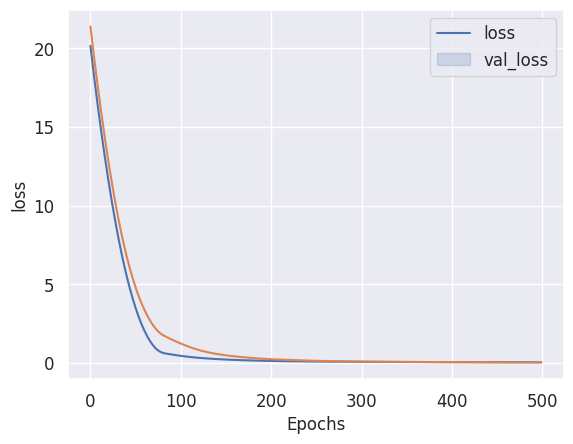

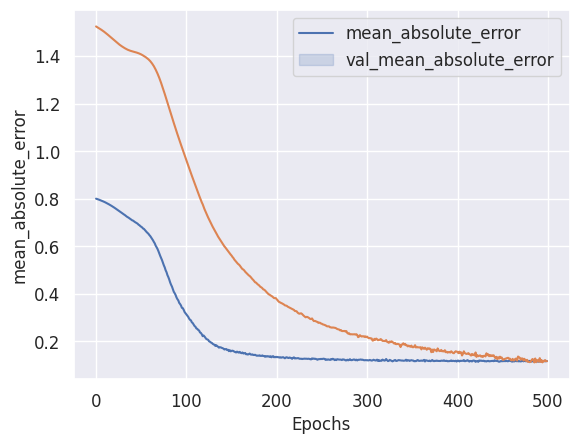

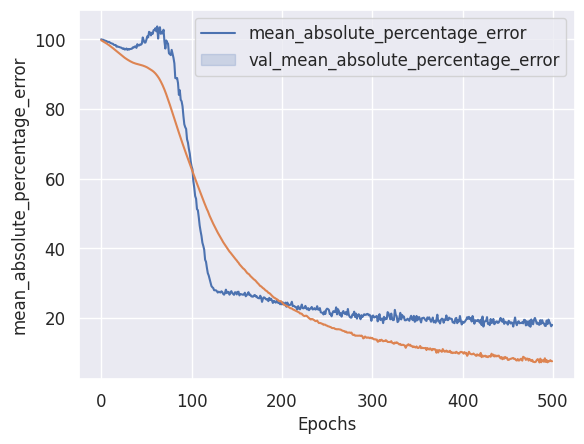

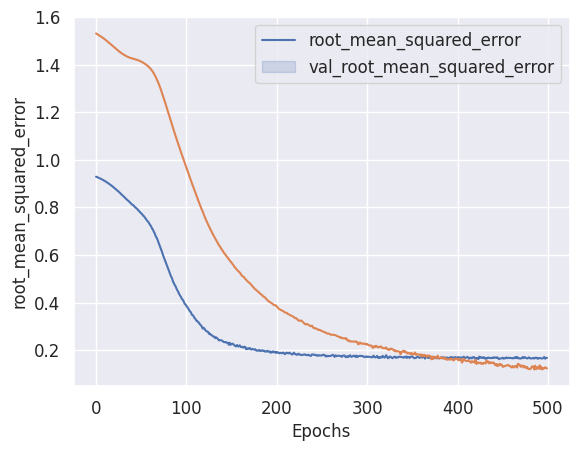

In [7]:
#training dataset
train_loss, train_RMSE, train_MAE, train_MAPE = model.evaluate(x_train, y_train)

print('\n','Evaluation of Training dataset:','\n''\n','train_loss:',round(train_loss,3),'\n','train_RMSE:',round(train_RMSE,3),'\n', 'train_MAE:',round(train_MAE,3),'\n','train_MAPE:',round(train_MAPE,3))


#training dataset
val_loss, val_RMSE, val_MAE, val_MAPE = model.evaluate(x_test, y_test)
print('\n','Evaluation of Testing dataset:','\n''\n','val_loss:',round(val_loss,3),'\n','val_RMSE:',round(val_RMSE,3),'\n', 'val_MAE:',round(val_MAE,3),'\n','val_MAPE:',round(val_MAPE,3))


mlflow.log_metric('train_loss',train_loss)
mlflow.log_metric('RMSE', train_RMSE)
mlflow.log_metric('MAE', train_MAE)
mlflow.log_metric('MAPE',train_MAPE)

mlflow.log_metric('val_loss',val_loss)
mlflow.log_metric('val_RMSE', val_RMSE)
mlflow.log_metric('val_MAE', val_MAE)
mlflow.log_metric('val_MAPE',val_MAPE)

mlflow.keras.save_model(model, path =path_model+'/')

path_metrics+'/'+'data.csv'
df = pd.read_csv(path_metrics+'/'+'data.csv')

metricplot(df, 'epoch', 'loss','val_loss', path_metrics)
metricplot(df, 'epoch', 'mean_absolute_error','val_mean_absolute_error', path_metrics)
metricplot(df, 'epoch', 'mean_absolute_percentage_error','val_mean_absolute_percentage_error', path_metrics)
metricplot(df, 'epoch', 'root_mean_squared_error','val_root_mean_squared_error', path_metrics)

In [8]:
model.save(path_model+'/'+model_name)   


#model_eval = load_model(path_model+'/'+model_name, compile=False)

# get future dates and predict the future close price!
future_days = 10

startdate = list(df_datetime['date'])[-1]
startdate = pd.to_datetime(startdate) + pd.DateOffset(days=1)
enddate = pd.to_datetime(startdate) + pd.DateOffset(days=future_days+1)
forecasting_dates= pd.bdate_range(start=startdate, end=enddate, freq = 'B')
number_of_days = len(forecasting_dates)
forecast = model.predict(train_data_X[-len(forecasting_dates):])
forecast_copies = np.repeat(forecast, df_data.shape[1], axis = -1 )
y_pred_fut = scaler.inverse_transform(forecast_copies)[:,0]
forecast_close = {'dates':forecasting_dates ,'close': y_pred_fut, 'close_orig':data['close'].iloc[-number_of_days:] }
forecasting_df = pd.DataFrame(data = forecast_close)
forecasting_df.to_csv(path_forecast +'/'+ 'forecast.csv')
print('The forecast for the future',number_of_days,'days is:','\n',forecasting_df)

1/1 [==============================] - 1s 684ms/step
The forecast for the future 8 days is: 
           dates        close  close_orig
6428 2022-08-01  1672.408569     1696.53
6429 2022-08-02  1665.089233     1718.22
6430 2022-08-03  1668.608643     1727.38
6431 2022-08-04  1685.034668     1719.64
6432 2022-08-05  1683.554199     1717.20
6433 2022-08-08  1679.561279     1734.33
6434 2022-08-09  1686.895752     1755.83
6435 2022-08-10  1703.781616     1766.00


<AxesSubplot: xlabel='dates', ylabel='close'>

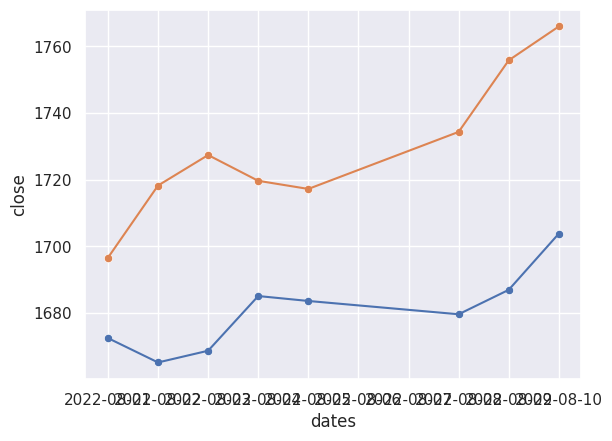

In [9]:
#forecasting_df

sns.lineplot(data = forecasting_df, x  = forecasting_df['dates'], y = forecasting_df['close'])
sns.scatterplot(data = forecasting_df, x  = forecasting_df['dates'], y = forecasting_df['close'])

sns.lineplot(data = forecasting_df, x = forecasting_df['dates'], y = forecasting_df['close_orig'])
sns.scatterplot(data = forecasting_df, x = forecasting_df['dates'], y = forecasting_df['close_orig'])

In [10]:
y = data['close'].iloc[-22:]

In [11]:
y

6413    1817.80
6414    1807.12
6415    1808.94
6417    1764.58
6418    1739.08
6419    1740.09
6420    1742.45
6421    1734.02
6422    1726.09
6423    1735.56
6424    1709.72
6425    1707.32
6426    1708.99
6427    1711.56
6428    1696.53
6429    1718.22
6430    1727.38
6431    1719.64
6432    1717.20
6433    1734.33
6434    1755.83
6435    1766.00
Name: close, dtype: float64